<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Aegon/Aegon_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AGN.AS"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  4.510  4.660  4.480  4.660     3.0014   5159419
2009-01-05  4.720  5.030  4.700  5.030     3.2397  11091570
2009-01-06  5.030  5.450  4.850  5.408     3.4832  11711681
2009-01-07  5.300  5.549  5.140  5.200     3.3492  10401835
2009-01-08  5.000  5.140  4.980  5.095     3.2816   7282417
...           ...    ...    ...    ...        ...       ...
2018-12-21  4.078  4.128  4.051  4.096     3.7874  14647054
2018-12-24  4.050  4.075  3.998  3.998     3.6968   3336314
2018-12-27  4.089  4.095  3.924  3.956     3.6580   7735284
2018-12-28  3.990  4.060  3.968  4.051     3.7458   5215636
2018-12-31  4.089  4.089  4.031  4.079     3.7717   2567930

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean      5.004676     5.068249     4.931841     4.999918     3.681198  1.076641e+07
std       1.019173     1.013415     1.026868     1.020521     0.931110  5.850329e+06
min       1.900000     1.995000     1.827000     1.848000     1.190300  5.433570e+05
25%       4.399250     4.461250     4.325000     4.389000     2.937325  7.082901e+06
50%       5.000000     5.068000     4.932000     4.997500     3.668900  9.462437e+06
75%       5.600000     5.664000     5.536750     5.600750     4.502225  1.295812e+07
max       7.685000     7.699000     7.586000     7.660000     5.626500  8.135267e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8  TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2009-03-13  2.550  2.610  2.386  2.395     1.5426  18489184   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  2.106663  2.618499  1.861967  2.225535  2.361372  2.567890      2.1740      2.2685  2.744073  2.223000  2.354370  2.18290  2.272056  2.223000  2.358000  2.761880                2.694635                 2.223000                1.751365                2.930453                 2.223000                1.515547                3.166271                 2.223000                1.279729                3.402089                 2.223000                1.043911  2.361372  2.363814  2.669946                2.833007                 2.361372                1.889736                3.068825                 2.361372                1.653918                3.304643                 2.361372                1.418101                3.540460                 2.361372   
2009-03-16  2.520  2.609  2.325  2.500     1.6102  18533022   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  2.126329  2.606195  1.878927  2.310488  2.392178  2.567258      2.1740      2.2685  2.670707  2.234500  2.452807  2.25110  2.333611  2.234500  2.447500  2.697878                2.727616                 2.234500                1.741384                2.974173                 2.234500                1.494827                3.220731                 2.234500                1.248269                3.467289                 2.234500                1.001711  2.392178  2.462178  2.611871                2.885294                 2.392178                1.899062                3.131851                 2.392178                1.652505                3.378409                 2.392178                1.405947                3.624967                 2.392178   
2009-03-17  2.460  2.550  2.392  2.450     1.5780  11913635   17          1         76           

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean      5.029626     5.091606     4.959606     5.025573     3.706909  1.071969e+07    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955     5.021206     5.011803    -0.173833     5.025482     5.023125     5.028109     5.019296     5.015489     5.003910     5.023045     5.025685     5.023082     5.023928     5.023045     5.025296     5.018615                5.238119                 5.023045                4.807971                5.345656                 5.023045                4.700434                5.453194                 5.023045                4.592896                5.560731                 5.023045                4.485359     5.023125     5.025162     5.019203                5.238199                 5.023125                4.808051                5.345736                 5.023125                4.700514                5.453274   
std       1.005881     1.001455     1.009863     1.005719     0.918335  5.871197e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     1.006433     0.995843     5.116170     1.008583     0.998852     1.005928     0.999877     0.997481     1.012056     1.002686     1.007337     1.004322     1.002240     1.002686     1.004255     0.996588                0.993591                 1.002686                1.027833                0.995231                 1.002686                1.046093                1.000985                 1.002686                1.067899                1.010784                 1.002686                1.093038     0.998852     1.003455     0.997686                0.989852                 0.998852                1.023967                0.991563                 0.998852                1.042233                0.997404   
min       2.460000     2.547000     2.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.017225  0.012228  0.011595  0.000000   0.000000  18489184   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.022475  0.633163  0.000000  0.000000  0.002447    0.000000    0.000000  0.156177  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.042126                0.000000                 0.000000                0.001736                0.005629                 0.000000                0.003483                0.022496                 0.000000                0.005116                0.044439                 0.000000                0.025687  0.000000  0.000000  0.033356                0.008132                 0.000000                0.000000                0.026452                 0.000000                0.000247                0.043397                 0.000000                0.007656                0.061240                 0.000000   
2009-03-16  0.011483  0.012034  0.000000  0.019943   0.016553  18533022   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.003643  0.019937  0.634286  0.015590  0.005963  0.002318    0.000000    0.000000  0.143683  0.002145  0.018456  0.012612  0.011577  0.002145  0.017001  0.029100                0.006410                 0.002145                0.000000                0.014054                 0.002145                0.000000                0.032343                 0.002145                0.000000                0.055450                 0.002145                0.019168  0.005963  0.018725  0.021675                0.018467                 0.005963                0.001682                0.038680                 0.005963                0.000000                0.057224                 0.005963                0.005620                0.076052                 0.005963   
2009-03-17  0.000000  0.000582  0.012735  0.0104

140181

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5zmpoivp
  JVM stdout: /tmp/tmp5zmpoivp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5zmpoivp/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_7zpzs5
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.515623  0.749575              0.458285  0.521761  0.272235
1  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.500000  0.690294              0.500000  0.498572  0.248574
2  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.493309  2.341453              0.477334  0.625592  0.391365
3  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.489435  1.018483              0.500000  0.573114  0.328459
4  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.472340  0.691313              0.500000  0.499073  0.249074
5  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.468562  0.690460              0.500000  0.498718  0.248720
6  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.464208  0.755442              0.500000  0.526513  0.277216
7  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.455116  0.785198              0.500000  0.537502  0.288909
8              DeepLearning_1_AutoML_20190903_020216  0.450122  0.791449              0.500000  0.525539  0.276192
9  DeepLearning_grid_1_AutoML_20190903_020216_mod...  0.422045  0.693175              0.500000  0.499999  0.249999

variable  relative_importance  scaled_importance  percentage
0                       BETA_8             1.000000           1.000000    0.001596
1                      weekday             0.925366           0.925366    0.001477
2            CDLSTALLEDPATTERN             0.909316           0.909316    0.001452
3                  CDLPIERCING             0.903346           0.903346    0.001442
4              CDLUNIQUE3RIVER             0.881210           0.881210    0.001407
...                        ...                  ...                ...         ...
1037  BBANDS_middleband_14_1_2             0.524977           0.524977    0.000838
1038   BBANDS_upperband_20_5_3             0.520531           0.520531    0.000831
1039                    T3_8_7             0.516190           0.516190    0.000824
1040  BBANDS_middleband_20_6_4             0.514971           0.514971    0.000822
1041   BBANDS_upperband_30_0_2             0.512356           0.512356    0.000818

[1042 rows x 4 columns]

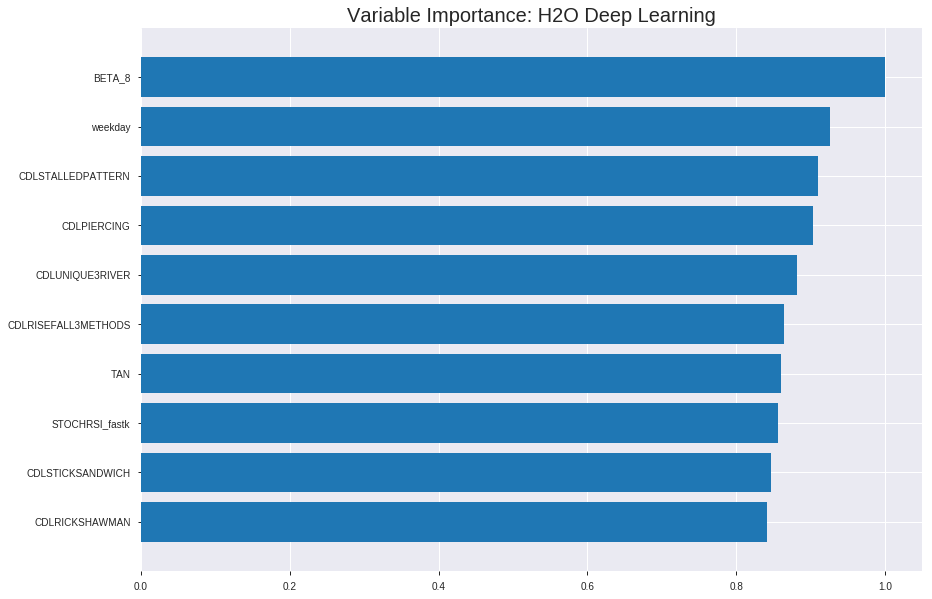

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_020216_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2803748122941238
RMSE: 0.5295043080977943
LogLoss: 0.785071146094864
Mean Per-Class Error: 0.4452464887247496
AUC: 0.5575689079228008
pr_auc: 0.5720189360574105
Gini: 0.11513781584560157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007371037649814355: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    849   0.9976   (849.0/851.0)
1      0    903   0        (0.0/903.0)
Total  2    1752  0.484    (849.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00737104   0.680226  398
max f2                       0.00737104   0.841723  398
max f0point5                 0.114815     0.572133  361
max accuracy                 0.39915      0.551881  195
max precision                0.809811     0.764706  12
max recall                   0.00737104   1         398
max specificity              0.919396     0.998825  0
max absolute_mcc             0.471073     0.11659   154
max min_per_class_accuracy   0.377244     0.542636  210
max mean_per_class_accuracy  0.471073     0.554754  154

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 38.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.803209           1.40285   1.40285            0.722222         0.848094   0.722222                    0.848094            0.0143965       0.0143965                  40.2855   40.2855
    2        0.0205245                   0.748754           1.40285   1.40285            0.722222         0.772393   0.722222                    0.810243            0.0143965       0.0287929                  40.2855   40.2855
    3        0.0302166                   0.723185           1.48538   1.42932            0.764706         0.736293   0.735849                    0.786524            0.0143965       0.0431894                  48.5376   42.9324
    4        0.0404789                   0.706459           1.07912   1.34054            0.555556         0.715542   0.690141                    0.768528            0.0110742       0.0542636                  7.9119    34.0539
    5        0.050171                    0.689311           1.37112   1.34645            0.705882         0.698774   0.693182                    0.755053            0.013289        0.0675526                  37.1116   34.6446
    6        0.100342                    0.638829           1.0595    1.20297            0.545455         0.663098   0.619318                    0.709075            0.0531561       0.120709                   5.94986   20.2972
    7        0.149943                    0.592632           1.094     1.16693            0.563218         0.612988   0.60076                     0.67729             0.0542636       0.174972                   9.40034   16.6926
    8        0.200114                    0.549165           1.14779   1.16213            0.590909         0.571592   0.598291                    0.65079             0.0575858       0.232558                   14.779    16.2128
    9        0.299886                    0.487273           1.13215   1.15215            0.582857         0.517681   0.593156                    0.606505            0.112957        0.345515                   13.215    15.2154
    10       0.400228                    0.431917           1.02639   1.12062            0.528409         0.458006   0.576923                    0.569274            0.10299         0.448505                   2.63893   12.0624
    11       0.5                         0.37653            0.943458  1.08527            0.485714         0.403253   0.558723                    0.536146            0.0941307       0.542636                   -5.65417  8.52713
    12       0.599772                    0.320795           0.821364  1.04137            0.422857         0.349609   0.536122                    0.505115            0.0819491       0.624585                   -17.8636  4.13703
    13       0.700114                    0.270004           1.03743   1.0408             0.534091         0.294038   0.535831                    0.474863            0.104097        0.728682                   3.74258   4.0805
    14       0.799886                    0.224837           0.921259  1.02589            0.474286         0.245746   0.528154                    0.446285            0.0919158       0.820598                   -7.87407  2.58937
    15       0.899658                    0.157525           0.921259  1.01429            0.474286         0.195677   0.52218                     0.418493            0.0919158       0.912514                   -7.87407  1.42898
    16       1                           0.00497636         0.871879  1                  0.448864         0.0990496  0.514823                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2715624049947807
RMSE: 0.5211164984864524
LogLoss: 0.7477856200640373
Mean Per-Class Error: 0.4620453347390616
AUC: 0.5374355042251721
pr_auc: 0.5776190759349101
Gini: 0.07487100845034411
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10835344608851376: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    230  0.9957   (230.0/231.0)
1      0    271  0        (0.0/271.0)
Total  1    501  0.4582   (230.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.108353     0.702073   398
max f2                       0.108353     0.85489    398
max f0point5                 0.189036     0.596604   377
max accuracy                 0.317624     0.545817   319
max precision                0.913291     1          0
max recall                   0.108353     1          398
max specificity              0.913291     1          0
max absolute_mcc             0.669472     0.0929973  88
max min_per_class_accuracy   0.514199     0.519481   206
max mean_per_class_accuracy  0.598025     0.537955   137

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 50.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.877777           1.54367   1.54367            0.833333         0.886572  0.833333                    0.886572            0.0184502       0.0184502                  54.3665    54.3665
    2        0.0219124                   0.841498           1.11144   1.3472             0.6              0.850065  0.727273                    0.869978            0.0110701       0.0295203                  11.1439    34.7199
    3        0.0318725                   0.835263           0.740959  1.15775            0.4              0.836624  0.625                       0.859555            0.00738007      0.0369004                  -25.9041   15.7749
    4        0.0418327                   0.82259            1.11144   1.14672            0.6              0.82783   0.619048                    0.852001            0.0110701       0.0479705                  11.1439    14.6723
    5        0.0517928                   0.810627           1.48192   1.21118            0.8              0.814822  0.653846                    0.844852            0.0147601       0.0627306                  48.1919    21.1184
    6        0.101594                    0.752122           1.03734   1.12597            0.56             0.781807  0.607843                    0.813947            0.0516605       0.114391                   3.73432    12.5968
    7        0.151394                    0.704726           1.11144   1.12119            0.6              0.728141  0.605263                    0.785722            0.0553506       0.169742                   11.1439    12.1189
    8        0.201195                    0.671316           1.25963   1.15546            0.68             0.685999  0.623762                    0.761038            0.0627306       0.232472                   25.9631    15.5457
    9        0.300797                    0.609248           0.963247  1.09181            0.52             0.640159  0.589404                    0.721012            0.095941        0.328413                   -3.67528   9.18111
    10       0.400398                    0.564693           1.0003    1.06905            0.54             0.58576   0.577114                    0.687367            0.099631        0.428044                   0.0295203  6.90459
    11       0.5                         0.515457           0.889151  1.03321            0.48             0.538769  0.557769                    0.657766            0.0885609       0.516605                   -11.0849   3.32103
    12       0.599602                    0.474784           1.0003    1.02774            0.54             0.494335  0.554817                    0.630618            0.099631        0.616236                   0.0295203  2.77427
    13       0.699203                    0.417402           1.0003    1.02383            0.54             0.44967   0.552707                    0.604842            0.099631        0.715867                   0.0295203  2.38328
    14       0.798805                    0.323607           0.926199  1.01166            0.5              0.376836  0.546135                    0.576412            0.0922509       0.808118                   -7.38007   1.1659
    15       0.898406                    0.252205           0.963247  1.00629            0.52             0.282816  0.543237                    0.543863            0.095941        0.904059                   -3.67528   0.629188
    16       1                           0.0974897          0.94436   1                  0.509804         0.186033  0.539841                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:03:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:03:35  1 min 12.222 sec  326 obs/sec       0.22691   1             398        0.675249         5.25097             -0.825449      0.530035        0.525133           1.29494          0.485177                         0.693729           4.33929               -0.937339        0.494066          0.515406             1.32314            0.460159
    2019-09-03 02:03:47  1 min 23.447 sec  372 obs/sec       2.4179    10            4241       0.577577         1.39605             -0.335557      0.577569        0.523031           1.61868          0.485177                         0.603128           1.51563               -0.46435         0.536054          0.561093             1.54367            0.456175
    2019-09-03 02:03:57  1 min 34.119 sec  379 obs/sec       4.55929   19            7997       0.529504         0.785071            -0.122486      0.557569        0.572019           1.40285          0.484036                         0.521116           0.747786              -0.0931904       0.537436          0.577619             1.54367            0.458167
    2019-09-03 02:04:07  1 min 44.020 sec  382 obs/sec       6.52965   27            11453      0.552592         0.909395            -0.222505      0.536968        0.546074           1.40285          0.482326                         0.542593           0.855948              -0.185151        0.532587          0.561615             0.926199           0.458167
    2019-09-03 02:04:18  1 min 54.867 sec  386 obs/sec       8.75941   36            15364      0.579935         1.02047             -0.34648       0.522889        0.535713           1.18703          0.485177                         0.546151           0.839045              -0.200746        0.528857          0.569219             1.23493            0.458167
    2019-09-03 02:04:29  2 min  5.214 sec  392 obs/sec       11.0017   45            19297      0.58592          1.2167              -0.374415      0.50489         0.525142           1.18703          0.485177                         0.620993           1.2903                -0.552384        0.474258          0.514579             0.617466           0.460159
    2019-09-03 02:04:39  2 min 15.943 sec  401 obs/sec       13.4322   55            23560      0.519054         0.759526            -0.0786167     0.565138        0.564948           1.29494          0.481756                         0.525384           0.764307              -0.111169        0.529696          0.567136             1.23493            0.460159
    2019-09-03 02:04:52  2 min 28.481 sec  408 obs/sec       16.3729   67            28718      0.558911         1.03642             -0.250623      0.550715        0.548686           1.29494          0.483466                         0.560434           1.02754               -0.264373        0.543649          0.57215              1.54367            0.460159
    2019-09-03 02:04:53

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BETA_8                    1.0                    1.0                  0.0015963469770001407
weekday                   0.9253658056259155     0.9253658056259155   0.0014772049064302301
CDLSTALLEDPATTERN         0.9093155860900879     0.9093155860900879   0.001451583186994023
CDLPIERCING               0.9033457040786743     0.9033457040786743   0.0014420531838920554
CDLUNIQUE3RIVER           0.8812103271484375     0.8812103271484375   0.0014067174418447132
---                       ---                    ---                  ---
BBANDS_middleband_14_1_2  0.5249766111373901     0.5249766111373901   0.0008380448261849511
BBANDS_upperband_20_5_3   0.5205314755439758     0.5205314755439758   0.0008309488474180485
T3_8_7                    0.5161895751953125     0.5161895751953125   0.0008240176679220239
BBANDS_middleband_20_6_4  0.5149707198143005     0.5149707198143005   0.0008220719518191452
BBANDS_upperband_30_0_2   0.512356162071228      0.512356162071228    0.000817898210469799


See the whole table with table.as_data_frame()


('accuracy', 0.5776892430278885)

('F1', 0.707182320441989)

('auc', 0.5156229991035984)

('logloss', 0.7495749383887481)

('mean_per_class_error', 0.45092201306185176)

('rmse', 0.5217609868181373)

('mse', 0.27223452736543646)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


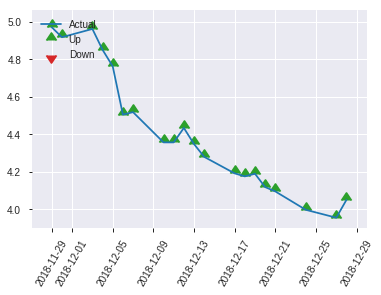


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27223452736543646
RMSE: 0.5217609868181373
LogLoss: 0.7495749383887481
Mean Per-Class Error: 0.45092201306185176
AUC: 0.5156229991035984
pr_auc: 0.5252891454238447
Gini: 0.031245998207196868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35762582718247826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      17   97   0.8509   (97.0/114.0)
1      9    128  0.0657   (9.0/137.0)
Total  26   225  0.4223   (106.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357626     0.707182  224
max f2                       0.170798     0.857322  250
max f0point5                 0.357626     0.617165  224
max accuracy                 0.385616     0.577689  204
max precision                0.504772     0.592233  102
max recall                   0.170798     1         250
max specificity              0.902916     0.991228  0
max absolute_mcc             0.586818     0.146479  47
max min_per_class_accuracy   0.48432      0.535088  126
max mean_per_class_accuracy  0.385616     0.549078  204

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.885602           0.610706  0.610706           0.333333         0.895817  0.333333                    0.895817            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.86098            0.610706  0.610706           0.333333         0.874531  0.333333                    0.885174            0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.856001           0         0.458029           0                0.859166  0.25                        0.878672            0               0.0145985                  -100      -54.1971
    4        0.0438247                   0.834097           1.22141   0.666224           0.666667         0.844913  0.363636                    0.869465            0.0145985       0.0291971                  22.1411   -33.3776
    5        0.0517928                   0.820309           0.916058  0.70466            0.5              0.82655   0.384615                    0.862863            0.00729927      0.0364964                  -8.39416  -29.534
    6        0.103586                    0.67188            0.845592  0.775126           0.461538         0.745752  0.423077                    0.804307            0.0437956       0.080292                   -15.4408  -22.4874
    7        0.151394                    0.600175           0.916058  0.819631           0.5              0.630734  0.447368                    0.749495            0.0437956       0.124088                   -8.39416  -18.0369
    8        0.203187                    0.580428           0.563728  0.754401           0.307692         0.592558  0.411765                    0.709491            0.0291971       0.153285                   -43.6272  -24.5599
    9        0.302789                    0.546749           1.39241   0.964272           0.76             0.561541  0.526316                    0.660823            0.138686        0.291971                   39.2409   -3.5728
    10       0.40239                     0.506051           1.39241   1.07025            0.76             0.520946  0.584158                    0.6262              0.138686        0.430657                   39.2409   7.02464
    11       0.501992                    0.485829           1.02599   1.06146            0.56             0.497457  0.579365                    0.600656            0.10219         0.532847                   2.59854   6.14645
    12       0.601594                    0.458379           0.952701  1.04346            0.52             0.471857  0.569536                    0.579332            0.0948905       0.627737                   -4.72993  4.34572
    13       0.701195                    0.424175           1.02599   1.04098            0.56             0.441096  0.568182                    0.559696            0.10219         0.729927                   2.59854   4.09754
    14       0.800797                    0.392723           1.02599   1.03911            0.56             0.412011  0.567164                    0.541327            0.10219         0.832117                   2.59854   3.9111
    15       0.900398                    0.355515           1.02599   1.03766            0.56             0.373731  0.566372                    0.522788            0.10219         0.934307                   2.59854   3.76591
    16       1                           0.170798           0.659562  1                  0.36             0.311832  0.545817                    0.501776   

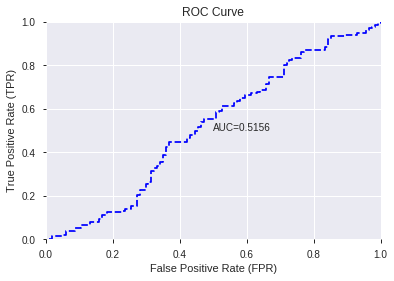

This function is available for GLM models only


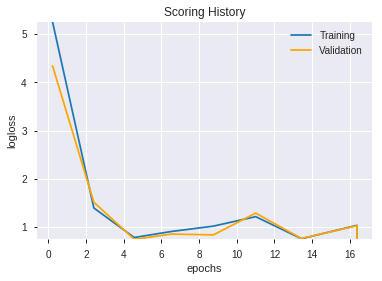

--2019-09-03 02:27:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  21.3MB/s    in 13s     

2019-09-03 02:27:17 (26.7 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_020216_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_020216_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_022731_model_4  0.478871  1.003278              0.486106  0.572274  0.327498
1  DeepLearning_grid_1_AutoML_20190903_022731_model_3  0.477590  0.889460              0.465617  0.542198  0.293979
2  DeepLearning_grid_1_AutoML_20190903_022731_model_1  0.464016  1.258106              0.500000  0.598605  0.358328
3  DeepLearning_grid_1_AutoML_20190903_022731_model_5  0.458573  0.752823              0.494878  0.524195  0.274780
4               DeepLearning_1_AutoML_20190903_022731  0.456973  0.860371              0.475125  0.548854  0.301240
5  DeepLearning_grid_1_AutoML_20190903_022731_model_8  0.455276  0.693370              0.500000  0.500111  0.250112
6  DeepLearning_grid_1_AutoML_20190903_022731_model_7  0.449097  0.760576              0.500000  0.523189  0.273727
7  DeepLearning_grid_1_AutoML_20190903_022731_model_2  0.448649  0.882158              0.500000  0.555451  0.308526
8  DeepLearning_grid_1_AutoML_20190903_022731_model_9  0.446536  0.689618              0.500000  0.498233  0.248237
9  DeepLearning_grid_1_AutoML_20190903_022731_model_6  0.420989  0.731404              0.494878  0.517168  0.267463

variable  relative_importance  scaled_importance  percentage
0    CDLRISEFALL3METHODS             1.000000           1.000000    0.030167
1     CDLMORNINGDOJISTAR             0.970137           0.970137    0.029267
2            CDLPIERCING             0.966417           0.966417    0.029154
3       CDLSTICKSANDWICH             0.965480           0.965480    0.029126
4      CDLSTALLEDPATTERN             0.960053           0.960053    0.028962
5          CDLHIKKAKEMOD             0.941543           0.941543    0.028404
6     CDLUPSIDEGAP2CROWS             0.928312           0.928312    0.028005
7        CDLUNIQUE3RIVER             0.923474           0.923474    0.027859
8              CDLONNECK             0.880887           0.880887    0.026574
9        CDLLADDERBOTTOM             0.804119           0.804119    0.024258
10          CDLTHRUSTING             0.747285           0.747285    0.022544
11                   TAN             0.638209           0.638209    0.019253
12               CDLDOJI             0.619056           0.619056    0.018675
13             CORREL_20             0.616876           0.616876    0.018610
14               BETA_14             0.616365           0.616365    0.018594
15     CDLLONGLEGGEDDOJI             0.613884           0.613884    0.018519
16             CORREL_24             0.609838           0.609838    0.018397
17         days_in_month             0.607630           0.607630    0.018331
18        CDLRICKSHAWMAN             0.606801           0.606801    0.018306
19                  DX_8             0.605126           0.605126    0.018255
20               BETA_30             0.602810           0.602810    0.018185
21            aroonup_30             0.599394           0.599394    0.018082
22          aroondown_30             0.598791           0.598791    0.018064
23               ADXR_14             0.597229           0.597229    0.018017
24             CORREL_14             0.595992           0.595992    0.017980
25          aroondown_20             0.595793           0.595793    0.017974
26             dayofweek             0.595639           0.595639    0.017969
27          HT_TRENDMODE             0.594215           0.594215    0.017926
28             CORREL_30             0.592832           0.592832    0.017884
29            aroonup_24             0.592139           0.592139    0.017863
30                   day             0.592127           0.592127    0.017863
31                 month             0.592056           0.592056    0.017861
32  HT_PHASOR_quadrature             0.589424           0.589424    0.017781
33           AROONOSC_20             0.588833           0.588833    0.017764
34               weekday             0.588759           0.588759    0.017761
35                ATR_30             0.588207           0.588207    0.017745
36                ADXR_8             0.587332           0.587332    0.017718
37          aroondown_24             0.586845           0.586845    0.017704
38                   BOP             0.585751           0.585751    0.017671
39               BETA_20             0.585273           0.585273    0.017656
40        STOCHRSI_fastk             0.580673           0.580673    0.017517
41           AROONOSC_24             0.578843           0.578843    0.017462
42          weekday_name             0.578841           0.578841    0.017462
43             aroonup_8             0.577727           0.577727    0.017429
44           HT_DCPERIOD             0.569419           0.569419    0.017178
45               ADXR_12             0.566197           0.566197    0.017081
46               BETA_24             0.559934           0.559934    0.016892
47                BETA_8             0.555791           0.555791    0.016767
48                SAREXT             0.555335           0.555335    0.016753
49            weekofyear             0.554636           0.554636    0.016732

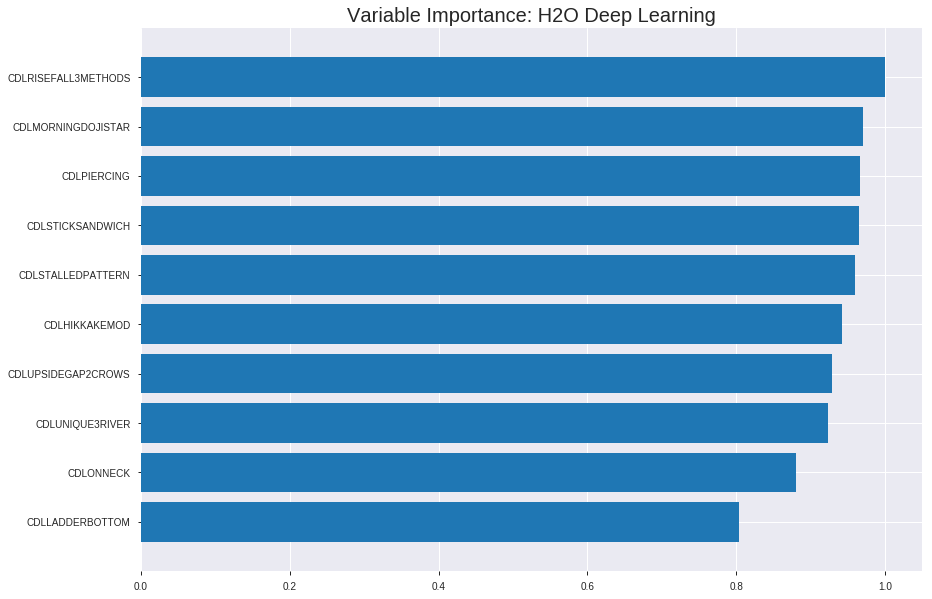

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_022731_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2806489113276078
RMSE: 0.5297630709360627
LogLoss: 0.830263649210687
Mean Per-Class Error: 0.37181519234097593
AUC: 0.6623905430781062
pr_auc: 0.6615640607526643
Gini: 0.3247810861562124
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23367380144684174: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   783   0.9201   (783.0/851.0)
1      16   887   0.0177   (16.0/903.0)
Total  84   1670  0.4555   (799.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233674     0.689468  353
max f2                       0.206651     0.842601  361
max f0point5                 0.813112     0.638718  119
max accuracy                 0.813112     0.626568  119
max precision                0.999971     1         0
max recall                   0.000412329  1         399
max specificity              0.999971     1         0
max absolute_mcc             0.813112     0.257587  119
max min_per_class_accuracy   0.778123     0.61794   138
max mean_per_class_accuracy  0.813112     0.628185  119

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 71.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.989546           1.61868   1.61868            0.833333         0.99389   0.833333                    0.99389             0.0166113       0.0166113                  61.8678   61.8678
    2        0.0205245                   0.984949           1.72659   1.67263            0.888889         0.98695   0.861111                    0.99042             0.0177187       0.03433                    72.659    67.2634
    3        0.0302166                   0.980516           1.37112   1.57592            0.705882         0.982354  0.811321                    0.987833            0.013289        0.047619                   37.1116   57.5921
    4        0.0404789                   0.976091           1.72659   1.61412            0.888889         0.977951  0.830986                    0.985328            0.0177187       0.0653378                  72.659    61.4119
    5        0.050171                    0.973367           1.71389   1.63339            0.882353         0.974846  0.840909                    0.983303            0.0166113       0.0819491                  71.3895   63.3394
    6        0.100342                    0.954121           1.25815   1.44577            0.647727         0.963993  0.744318                    0.973648            0.0631229       0.145072                   25.8155   44.5774
    7        0.149943                    0.938515           1.29494   1.39588            0.666667         0.947149  0.718631                    0.964882            0.0642303       0.209302                   29.4943   39.5879
    8        0.200114                    0.921469           1.21401   1.35028            0.625            0.930619  0.695157                    0.956292            0.0609081       0.27021                    21.4009   35.0282
    9        0.299886                    0.886038           1.29864   1.3331             0.668571         0.903665  0.686312                    0.938783            0.129568        0.399779                   29.8643   33.3102
    10       0.400228                    0.840477           1.14779   1.28664            0.590909         0.865283  0.662393                    0.920356            0.115172        0.51495                    14.779    28.6642
    11       0.5                         0.779574           1.01006   1.23145            0.52             0.810295  0.633979                    0.898394            0.100775        0.615725                   1.00554   23.1451
    12       0.599772                    0.707154           0.943458  1.18354            0.485714         0.746312  0.609316                    0.873095            0.0941307       0.709856                   -5.65417  18.3543
    13       0.700114                    0.622907           0.882916  1.14046            0.454545         0.66828   0.587134                    0.84374             0.0885936       0.79845                    -11.7084  14.0457
    14       0.799886                    0.514652           0.721468  1.08819            0.371429         0.569324  0.560228                    0.809512            0.0719823       0.870432                   -27.8532  8.8195
    15       0.899658                    0.35127            0.732568  1.04876            0.377143         0.438607  0.539924                    0.768378            0.0730897       0.943522                   -26.7432  4.87559
    16       1                           4.39874e-07        0.562859  1                  0.289773         0.22249   0.514823                    0.713603          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2948187773928121
RMSE: 0.5429721699984374
LogLoss: 0.8932745852109542
Mean Per-Class Error: 0.4335633616076421
AUC: 0.5499992012907142
pr_auc: 0.5576351621954899
Gini: 0.09999840258142845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.5347647896320121e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.53476e-06  0.701164  399
max f2                       1.53476e-06  0.854351  399
max f0point5                 0.591791     0.609907  253
max accuracy                 0.634461     0.575697  233
max precision                0.992209     1         0
max recall                   1.53476e-06  1         399
max specificity              0.992209     1         0
max absolute_mcc             0.634461     0.136544  233
max min_per_class_accuracy   0.715796     0.546125  189
max mean_per_class_accuracy  0.634461     0.566437  233

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 67.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.975279           1.54367   1.54367            0.833333         0.980315  0.833333                    0.980315            0.0184502       0.0184502                  54.3665   54.3665
    2        0.0219124                   0.968258           0         0.841999           0                0.97019   0.454545                    0.975713            0               0.0184502                  -100      -15.8001
    3        0.0318725                   0.965178           0.740959  0.810424           0.4              0.965801  0.4375                      0.972615            0.00738007      0.0258303                  -25.9041  -18.9576
    4        0.0418327                   0.962411           1.11144   0.882095           0.6              0.963913  0.47619                     0.970543            0.0110701       0.0369004                  11.1439   -11.7905
    5        0.0517928                   0.956235           1.11144   0.926199           0.6              0.9597    0.5                         0.968458            0.0110701       0.0479705                  11.1439   -7.38007
    6        0.101594                    0.933371           0.889151  0.908038           0.48             0.944029  0.490196                    0.956483            0.0442804       0.0922509                  -11.0849  -9.19615
    7        0.151394                    0.903427           1.11144   0.974947           0.6              0.918616  0.526316                    0.944027            0.0553506       0.147601                   11.1439   -2.50534
    8        0.201195                    0.878401           1.03734   0.990391           0.56             0.888143  0.534653                    0.930194            0.0516605       0.199262                   3.73432   -0.960871
    9        0.300797                    0.837013           1.14849   1.04274            0.62             0.856605  0.562914                    0.905827            0.114391        0.313653                   14.8487   4.27409
    10       0.400398                    0.767051           1.33373   1.11513            0.72             0.80253   0.60199                     0.880131            0.132841        0.446494                   33.3727   11.5125
    11       0.5                         0.716082           0.963247  1.08487            0.52             0.741475  0.585657                    0.85251             0.095941        0.542435                   -3.67528  8.48708
    12       0.599602                    0.644855           1.14849   1.09544            0.62             0.677885  0.591362                    0.823503            0.114391        0.656827                   14.8487   9.54383
    13       0.699203                    0.573341           0.815055  1.0555             0.44             0.608039  0.569801                    0.79281             0.0811808       0.738007                   -18.4945  5.54977
    14       0.798805                    0.469196           0.926199  1.03938            0.5              0.52403   0.561097                    0.759296            0.0922509       0.830258                   -7.38007  3.93757
    15       0.898406                    0.352161           0.852103  1.01861            0.46             0.419119  0.549889                    0.721583            0.0848708       0.915129                   -14.7897  1.86138
    16       1                           1.53476e-06        0.835395  1                  0.45098          0.217339  0.539841                    0.670355 


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:29:13  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:29:18  5.073 sec   330 obs/sec       0.836944  1             1468       0.6102           1.46558             -0.490687      0.545448        0.53301            1.51077          0.478335                         0.631661           1.67649               -0.606182        0.503387          0.542956             1.23493            0.460159
    2019-09-03 02:29:25  12.523 sec  387 obs/sec       2.50399   3             4392       0.580151         1.09654             -0.347485      0.596837        0.603568           1.61868          0.449829                         0.606269           1.22377               -0.479641        0.472988          0.548361             1.8524             0.460159
    2019-09-03 02:29:31  18.435 sec  437 obs/sec       4.15906   5             7295       0.584312         1.17338             -0.366883      0.604909        0.600194           1.51077          0.466363                         0.597552           1.29394               -0.437401        0.511238          0.549603             0.926199           0.460159
    2019-09-03 02:29:38  25.862 sec  495 obs/sec       6.65393   8             11671      0.529763         0.830264            -0.123583      0.662391        0.661564           1.61868          0.45553                          0.542972           0.893275              -0.18681         0.549999          0.557635             1.54367            0.460159
    2019-09-03 02:29:45  32.378 sec  543 obs/sec       9.14994   11            16049      0.479145         0.684154            0.0808715      0.704003        0.706023           1.94241          0.372292                         0.548591           0.95131               -0.211502        0.556676          0.588751             1.23493            0.448207
    2019-09-03 02:29:51  38.307 sec  584 obs/sec       11.6408   14            20418      0.451447         0.59711             0.184065       0.768036        0.771285           1.8345           0.31813                          0.56056            0.933529              -0.264941        0.521326          0.546397             0.617466           0.460159
    2019-09-03 02:29:56  43.801 sec  622 obs/sec       14.142    17            24805      0.496184         0.836956            0.0143384      0.734399        0.762177           1.94241          0.350057                         0.600541           1.29294               -0.451817        0.558761          0.591096             1.8524             0.434263
    2019-09-03 02:30:03  50.514 sec  666 obs/sec       17.4806   21            30661      0.431153         0.572645            0.255775       0.795195        0.794231           1.94241          0.297035                         0.547886           0.949931              -0.20839         0.560638          0.573531             0.926199           0.460159
    2019-09-03 02:30:09  56.527 sec  709 obs/sec       20.8136   25            36507     

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLRISEFALL3METHODS  1.0                    1.0                  0.030167435056666227
CDLMORNINGDOJISTAR   0.9701369404792786     0.9701369404792786   0.029266543147981505
CDLPIERCING          0.966416597366333      0.966416597366333    0.029154309938733206
CDLSTICKSANDWICH     0.9654795527458191     0.9654795527458191   0.029126041705998654
CDLSTALLEDPATTERN    0.9600526094436646     0.9600526094436646   0.028962324746374696
---                  ---                    ---                  ---
ADXR_12              0.5661969184875488     0.5661969184875488   0.01708070876775767
BETA_24              0.5599340200424194     0.5599340200424194   0.016891773185647732
BETA_8               0.5557905435562134     0.5557905435562134   0.016766775127841287
SAREXT               0.5553348660469055     0.5553348660469055   0.01675302850617246
weekofyear           0.5546364784240723     0.5546364784240723   0.01673195994291626


See the whole table with table.as_data_frame()


('accuracy', 0.5577689243027888)

('F1', 0.710182767624021)

('auc', 0.4788705339992317)

('logloss', 1.003278328024804)

('mean_per_class_error', 0.47637341529004995)

('rmse', 0.5722741803658107)

('mse', 0.32749773751336037)

deeplearning prediction progress: |███████████████████████████████████████| 100%


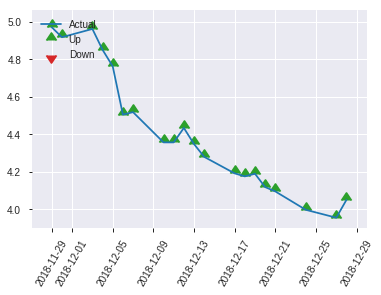


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.32749773751336037
RMSE: 0.5722741803658107
LogLoss: 1.003278328024804
Mean Per-Class Error: 0.47637341529004995
AUC: 0.4788705339992317
pr_auc: 0.50789607823988
Gini: -0.04225893200153663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16508589418420502: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    110  0.9649   (110.0/114.0)
1      1    136  0.0073   (1.0/137.0)
Total  5    246  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.165086     0.710183  245
max f2                       0.002676     0.857322  250
max f0point5                 0.165086     0.606601  245
max accuracy                 0.165086     0.557769  245
max precision                0.550493     0.563636  164
max recall                   0.002676     1         250
max specificity              0.989709     0.991228  0
max absolute_mcc             0.906259     0.199461  44
max min_per_class_accuracy   0.719983     0.517544  125
max mean_per_class_accuracy  0.550493     0.523627  164

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 64.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.986704           0.610706  0.610706           0.333333         0.988616  0.333333                    0.988616            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.980606           0.610706  0.610706           0.333333         0.983475  0.333333                    0.986046            0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.978836           0.916058  0.687044           0.5              0.98033   0.375                       0.984617            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.977217           0.610706  0.666224           0.333333         0.977405  0.363636                    0.98265             0.00729927      0.0291971                  -38.9294  -33.3776
    5        0.0517928                   0.971411           0.916058  0.70466            0.5              0.97349   0.384615                    0.981241            0.00729927      0.0364964                  -8.39416  -29.534
    6        0.103586                    0.952313           1.12746   0.916058           0.615385         0.961066  0.5                         0.971153            0.0583942       0.0948905                  12.7456   -8.39416
    7        0.151394                    0.929745           0.305353  0.723204           0.166667         0.94194   0.394737                    0.961928            0.0145985       0.109489                   -69.4647  -27.6796
    8        0.203187                    0.898806           0.845592  0.754401           0.461538         0.910112  0.411765                    0.94872             0.0437956       0.153285                   -15.4408  -24.5599
    9        0.302789                    0.842725           1.24584   0.916058           0.68             0.868004  0.5                         0.922169            0.124088        0.277372                   24.5839   -8.39416
    10       0.40239                     0.779737           1.02599   0.943268           0.56             0.808058  0.514851                    0.893923            0.10219         0.379562                   2.59854   -5.6732
    11       0.501992                    0.719983           1.39241   1.03238            0.76             0.73882   0.563492                    0.863149            0.138686        0.518248                   39.2409   3.23833
    12       0.601594                    0.624593           0.806131  0.994924           0.44             0.67323   0.543046                    0.831705            0.080292        0.59854                    -19.3869  -0.507565
    13       0.701195                    0.480829           1.17255   1.02016            0.64             0.557263  0.556818                    0.792722            0.116788        0.715328                   17.2555   2.01559
    14       0.800797                    0.371968           0.879416  1.00265            0.48             0.426288  0.547264                    0.747146            0.0875912       0.80292                    -12.0584  0.265098
    15       0.900398                    0.265418           0.952701  0.997126           0.52             0.317966  0.544248                    0.69967             0.0948905       0.89781                    -4.72993  -0.287449
    16       1                           0.002676           1.02599   1                  0.56             0.183666  0.545817                    0.64

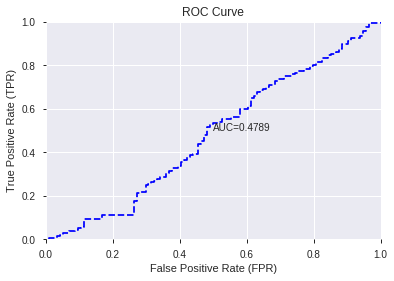

This function is available for GLM models only


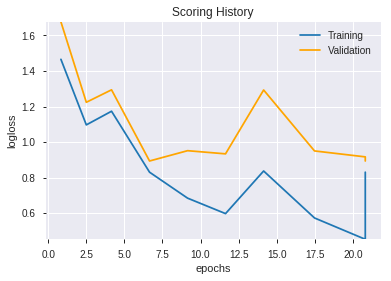

--2019-09-03 02:34:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.73.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.73.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_022731_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_022731_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRISEFALL3METHODS',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'CDLSTICKSANDWICH',
 'CDLSTALLEDPATTERN',
 'CDLHIKKAKEMOD',
 'CDLUPSIDEGAP2CROWS',
 'CDLUNIQUE3RIVER',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'TAN',
 'CDLDOJI',
 'CORREL_20',
 'BETA_14',
 'CDLLONGLEGGEDDOJI',
 'CORREL_24',
 'days_in_month',
 'CDLRICKSHAWMAN',
 'DX_8',
 'BETA_30',
 'aroonup_30',
 'aroondown_30',
 'ADXR_14',
 'CORREL_14',
 'aroondown_20',
 'dayofweek',
 'HT_TRENDMODE',
 'CORREL_30',
 'aroonup_24',
 'day',
 'month',
 'HT_PHASOR_quadrature',
 'AROONOSC_20',
 'weekday',
 'ATR_30',
 'ADXR_8',
 'aroondown_24',
 'BOP',
 'BETA_20',
 'STOCHRSI_fastk',
 'AROONOSC_24',
 'weekday_name',
 'aroonup_8',
 'HT_DCPERIOD',
 'ADXR_12',
 'BETA_24',
 'BETA_8',
 'SAREXT',
 'weekofyear']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023456_model_1  0.403317  0.69337                   0.5  0.500111  0.250111

variable  relative_importance  scaled_importance  percentage
0              dayofweek             0.008612           1.000000    0.061257
1                weekday             0.008608           0.999588    0.061231
2                 BETA_8             0.008372           0.972114    0.059548
3   HT_PHASOR_quadrature             0.008097           0.940235    0.057596
4             aroonup_30             0.006542           0.759680    0.046535
5      CDLSTALLEDPATTERN             0.006193           0.719098    0.044050
6                    BOP             0.005924           0.687888    0.042138
7                BETA_14             0.005281           0.613255    0.037566
8           CDLTHRUSTING             0.005107           0.592997    0.036325
9       CDLSTICKSANDWICH             0.004991           0.579564    0.035502
10    CDLMORNINGDOJISTAR             0.004728           0.549019    0.033631
11                ADXR_8             0.004725           0.548705    0.033612
12          aroondown_20             0.004704           0.546265    0.033462
13               BETA_24             0.004563           0.529835    0.032456
14        STOCHRSI_fastk             0.004338           0.503769    0.030859
15            aroonup_24             0.004230           0.491196    0.030089
16   CDLRISEFALL3METHODS             0.003289           0.381941    0.023396
17             CORREL_20             0.002858           0.331908    0.020332
18          aroondown_24             0.002741           0.318298    0.019498
19          aroondown_30             0.002664           0.309368    0.018951
20               BETA_20             0.002538           0.294761    0.018056
21           AROONOSC_20             0.002253           0.261626    0.016026
22           CDLPIERCING             0.002153           0.250004    0.015314
23                   TAN             0.001968           0.228559    0.014001
24            weekofyear             0.001798           0.208734    0.012786
25         days_in_month             0.001778           0.206503    0.012650
26             CDLONNECK             0.001773           0.205863    0.012610
27             CORREL_30             0.001751           0.203334    0.012456
28        CDLRICKSHAWMAN             0.001585           0.184073    0.011276
29             CORREL_24             0.001474           0.171118    0.010482
30                 month             0.001437           0.166887    0.010223
31         CDLHIKKAKEMOD             0.001436           0.166726    0.010213
32                SAREXT             0.001359           0.157758    0.009664
33             CORREL_14             0.001270           0.147459    0.009033
34             aroonup_8             0.001065           0.123693    0.007577
35                   day             0.001042           0.121046    0.007415
36           AROONOSC_24             0.000921           0.106892    0.006548
37               ADXR_14             0.000915           0.106205    0.006506
38          HT_TRENDMODE             0.000896           0.104046    0.006374
39               BETA_30             0.000894           0.103762    0.006356
40                  DX_8             0.000819           0.095092    0.005825
41           HT_DCPERIOD             0.000707           0.082099    0.005029
42               ADXR_12             0.000554           0.064383    0.003944
43       CDLLADDERBOTTOM             0.000395           0.045868    0.002810
44          weekday_name             0.000384           0.044532    0.002728
45    CDLUPSIDEGAP2CROWS             0.000198           0.022982    0.001408
46     CDLLONGLEGGEDDOJI             0.000194           0.022573    0.001383
47               CDLDOJI             0.000184           0.021344    0.001307
48                ATR_30             0.000139           0.016109    0.000987
49       CDLUNIQUE3RIVER             0.000138           0.016002    0.000980

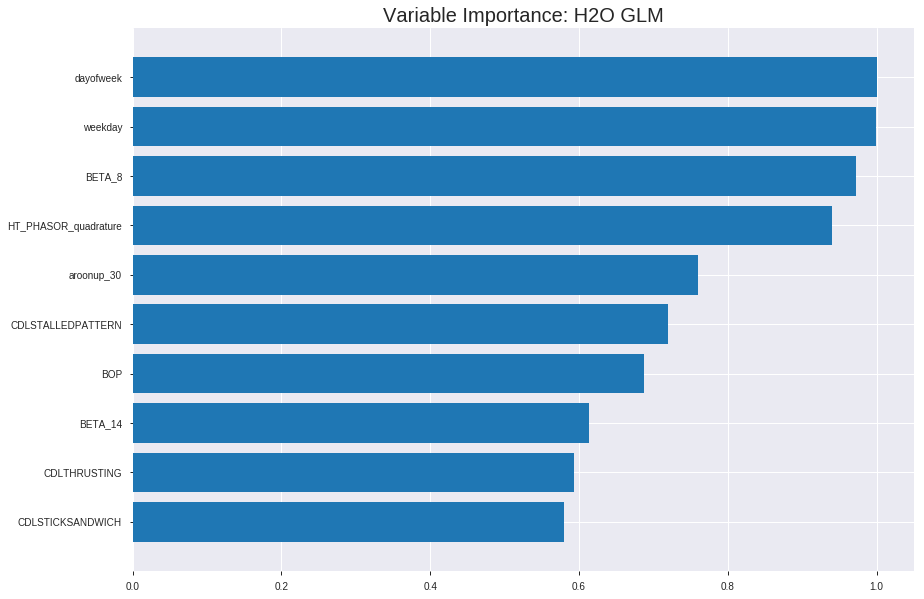

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023456_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24860137759200643
RMSE: 0.4985994159563431
LogLoss: 0.6903471965901674
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2430.0184643429493
Residual deviance: 2421.7379656383073
AIC: 2523.7379656383073
AUC: 0.5735308470394416
pr_auc: 0.5739620311387155
Gini: 0.14706169407888314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4987070904470112: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   812   0.9542   (812.0/851.0)
1      6    897   0.0066   (6.0/903.0)
Total  45   1709  0.4664   (818.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498707     0.68683   369
max f2                       0.497326     0.844411  378
max f0point5                 0.508935     0.59035   282
max accuracy                 0.511059     0.564424  256
max precision                0.5586       1         0
max recall                   0.496063     1         382
max specificity              0.5586       1         0
max absolute_mcc             0.506492     0.133714  311
max min_per_class_accuracy   0.514943     0.550388  204
max mean_per_class_accuracy  0.511922     0.559246  244

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.535783           1.29494   1.29494            0.666667         0.541788  0.666667                    0.541788            0.013289        0.013289                   29.4943   29.4943
    2        0.0205245                   0.533004           1.61868   1.45681            0.833333         0.53418   0.75                        0.537984            0.0166113       0.0299003                  61.8678   45.6811
    3        0.0302166                   0.531735           1.02834   1.31938            0.529412         0.532402  0.679245                    0.536193            0.00996678      0.0398671                  2.83369   31.9376
    4        0.0404789                   0.530379           1.51077   1.3679             0.777778         0.530901  0.704225                    0.534852            0.0155039       0.055371                   51.0767   36.7897
    5        0.050171                    0.528734           1.1426    1.32437            0.588235         0.529626  0.681818                    0.533842            0.0110742       0.0664452                  14.2597   32.4373
    6        0.100342                    0.525371           1.03743   1.1809             0.534091         0.52686   0.607955                    0.530351            0.0520487       0.118494                   3.74258   18.09
    7        0.149943                    0.523163           1.13866   1.16693            0.586207         0.524172  0.60076                     0.528307            0.0564784       0.174972                   13.8657   16.6926
    8        0.200114                    0.521533           1.01535   1.12892            0.522727         0.522295  0.581197                    0.5268              0.0509413       0.225914                   1.53529   12.8924
    9        0.299886                    0.518777           1.05445   1.10415            0.542857         0.52007   0.568441                    0.524561            0.105205        0.331118                   5.44534   10.4148
    10       0.400228                    0.516786           1.10364   1.10402            0.568182         0.517784  0.568376                    0.522862            0.110742        0.44186                    10.3644   10.4022
    11       0.5                         0.514932           1.08775   1.10078            0.56             0.51578   0.566705                    0.521448            0.108527        0.550388                   8.77519   10.0775
    12       0.599772                    0.512801           1.04335   1.09122            0.537143         0.51381   0.561787                    0.520178            0.104097        0.654485                   4.33539   9.12232
    13       0.700114                    0.510692           0.960171  1.07244            0.494318         0.5117    0.552117                    0.518963            0.0963455       0.750831                   -3.98294  7.24404
    14       0.799886                    0.507906           0.921259  1.05358            0.474286         0.50933   0.542409                    0.517761            0.0919158       0.842746                   -7.87407  5.35832
    15       0.899658                    0.504259           0.89906   1.03645            0.462857         0.506304  0.533587                    0.516491            0.089701        0.932447                   -10.094   3.64466
    16       1                           0.472454           0.673223  1                  0.346591         0.499874  0.514823                    0.514823           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2491977112201271
RMSE: 0.4991970665179505
LogLoss: 0.6915399152564179
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 693.9887622709523
Residual deviance: 694.3060749174435
AIC: 796.3060749174435
AUC: 0.4942253318637082
pr_auc: 0.5421482349905202
Gini: -0.011549336272583588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462413052323826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462413     0.701164  399
max f2                       0.462413     0.854351  399
max f0point5                 0.462413     0.594559  399
max accuracy                 0.462413     0.539841  399
max precision                0.557794     1         0
max recall                   0.462413     1         399
max specificity              0.557794     1         0
max absolute_mcc             0.500678     0.10783   385
max min_per_class_accuracy   0.516739     0.505535  194
max mean_per_class_accuracy  0.514229     0.519281  238

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.546561           1.54367   1.54367            0.833333         0.55206   0.833333                    0.55206             0.0184502       0.0184502                  54.3665   54.3665
    2        0.0219124                   0.540267           1.11144   1.3472             0.6              0.542774  0.727273                    0.547839            0.0110701       0.0295203                  11.1439   34.7199
    3        0.0318725                   0.535105           1.11144   1.27352            0.6              0.536539  0.6875                      0.544308            0.0110701       0.0405904                  11.1439   27.3524
    4        0.0418327                   0.532923           0.37048   1.05851            0.2              0.533331  0.571429                    0.541694            0.00369004      0.0442804                  -62.952   5.85134
    5        0.0517928                   0.531601           1.11144   1.06869            0.6              0.531988  0.576923                    0.539828            0.0110701       0.0553506                  11.1439   6.86915
    6        0.101594                    0.526689           0.740959  0.908038           0.4              0.528755  0.490196                    0.5344              0.0369004       0.0922509                  -25.9041  -9.19615
    7        0.151394                    0.525049           1.03734   0.950573           0.56             0.525994  0.513158                    0.531635            0.0516605       0.143911                   3.73432   -4.94271
    8        0.201195                    0.523493           0.963247  0.95371            0.52             0.524253  0.514851                    0.529808            0.0479705       0.191882                   -3.67528  -4.62899
    9        0.300797                    0.520381           1.07439   0.993671           0.58             0.522095  0.536424                    0.527254            0.107011        0.298893                   7.43911   -0.632927
    10       0.400398                    0.518364           0.926199  0.976887           0.5              0.519292  0.527363                    0.525273            0.0922509       0.391144                   -7.38007  -2.31132
    11       0.5                         0.516721           1.14849   1.01107            0.62             0.517524  0.545817                    0.52373             0.114391        0.505535                   14.8487   1.10701
    12       0.599602                    0.514448           1.07439   1.02159            0.58             0.515701  0.551495                    0.522396            0.107011        0.612546                   7.43911   2.15886
    13       0.699203                    0.511842           0.926199  1.008              0.5              0.51329   0.54416                     0.521099            0.0922509       0.704797                   -7.38007  0.800034
    14       0.798805                    0.509682           0.889151  0.993181           0.48             0.510752  0.53616                     0.519809            0.0885609       0.793358                   -11.0849  -0.681875
    15       0.898406                    0.506187           0.963247  0.989863           0.52             0.508128  0.534368                    0.518514            0.095941        0.889299                   -3.67528  -1.01374
    16       1                           0.462413           1.08965   1                  0.588235         0.500378  0.539841                    0.51667


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:34:57  0.000 sec   2            3.2       51            1.38069           1.38308
    2019-09-03 02:34:57  0.092 sec   4            2         51            1.37851           1.38367
    2019-09-03 02:34:57  0.175 sec   6            1.2       51            1.37569           1.38475
    2019-09-03 02:34:57  0.245 sec   8            0.77      51            1.37229           1.38661
    2019-09-03 02:34:58  0.317 sec   10           0.48      51            1.3685            1.38952

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7061855670103092)

('auc', 0.4033166858752721)

('logloss', 0.6933703321598176)

('mean_per_class_error', 0.49490971955436036)

('rmse', 0.5001107235105676)

('mse', 0.25011073577026344)

glm prediction progress: |████████████████████████████████████████████████| 100%


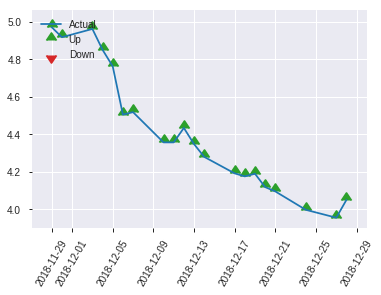


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25011073577026344
RMSE: 0.5001107235105676
LogLoss: 0.6933703321598176
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.81644986094483
Residual deviance: 348.07190674422844
AIC: 450.07190674422844
AUC: 0.4033166858752721
pr_auc: 0.47720567617722826
Gini: -0.19336662824945583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48323758697890173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483238     0.706186  250
max f2                       0.483238     0.857322  250
max f0point5                 0.483238     0.600351  250
max accuracy                 0.500828     0.545817  240
max precision                0.533159     1         0
max recall                   0.483238     1         250
max specificity              0.533159     1         0
max absolute_mcc             0.515815     0.217844  108
max min_per_class_accuracy   0.514931     0.416058  119
max mean_per_class_accuracy  0.529589     0.50509   7

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.53152            0.610706  0.610706           0.333333         0.532361  0.333333                    0.532361            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.530039           1.22141   0.916058           0.666667         0.530762  0.5                         0.531562            0.0145985       0.0218978                  22.1411   -8.39416
    3        0.0318725                   0.52949            1.83212   1.14507            1                0.529754  0.625                       0.53111             0.0145985       0.0364964                  83.2117   14.5073
    4        0.0438247                   0.52805            0         0.83278            0                0.528591  0.454545                    0.530423            0               0.0364964                  -100      -16.722
    5        0.0517928                   0.52628            0.916058  0.845592           0.5              0.526823  0.461538                    0.529869            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.524372           0.563728  0.70466            0.307692         0.525212  0.384615                    0.52754             0.0291971       0.0729927                  -43.6272  -29.534
    7        0.151394                    0.522464           0.916058  0.771418           0.5              0.52352   0.421053                    0.526271            0.0437956       0.116788                   -8.39416  -22.8582
    8        0.203187                    0.521026           0.986524  0.826249           0.538462         0.521587  0.45098                     0.525077            0.0510949       0.167883                   -1.34756  -17.3751
    9        0.302789                    0.518594           0.732847  0.795524           0.4              0.519768  0.434211                    0.523331            0.0729927       0.240876                   -26.7153  -20.4476
    10       0.40239                     0.516358           0.879416  0.81629            0.48             0.517518  0.445545                    0.521892            0.0875912       0.328467                   -12.0584  -18.371
    11       0.501992                    0.514522           1.02599   0.857896           0.56             0.515486  0.468254                    0.520621            0.10219         0.430657                   2.59854   -14.2104
    12       0.601594                    0.512586           1.17255   0.909992           0.64             0.513555  0.496689                    0.519451            0.116788        0.547445                   17.2555   -9.00082
    13       0.701195                    0.510739           1.02599   0.926468           0.56             0.511533  0.505682                    0.518326            0.10219         0.649635                   2.59854   -7.35319
    14       0.800797                    0.508509           1.24584   0.966191           0.68             0.509362  0.527363                    0.517211            0.124088        0.773723                   24.5839   -3.38091
    15       0.900398                    0.504917           1.17255   0.989019           0.64             0.506659  0.539823                    0.516044            0.116788        0.890511                   17.2555   -1.09812
    16       1                           0.483238           1.09927   1                  0.6              0.500235  0.545817                    0.5144

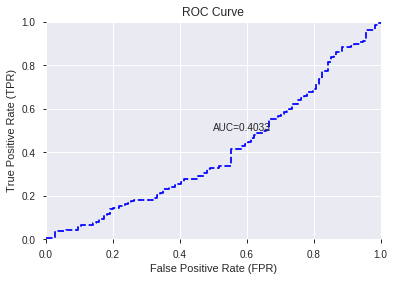

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


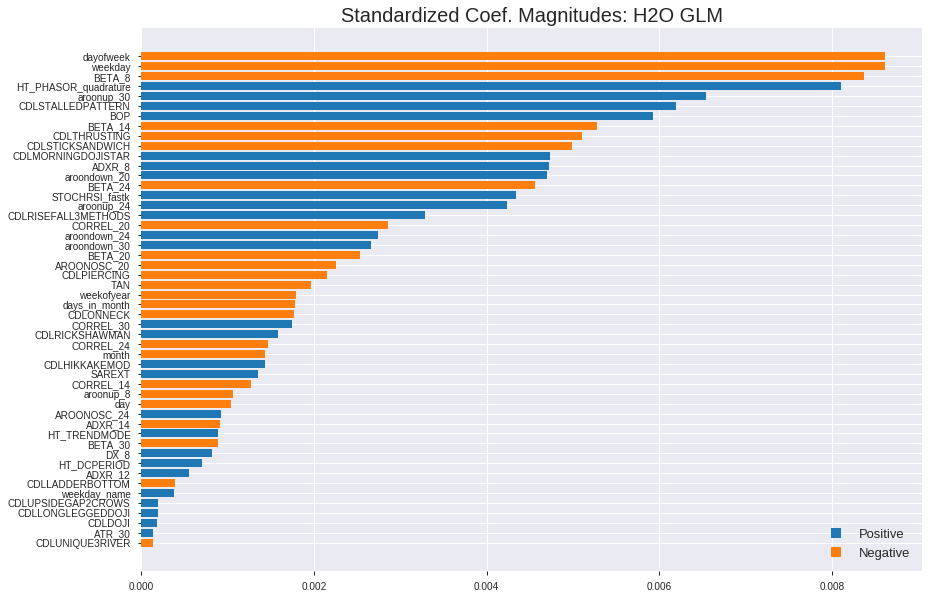

'log_likelihood'
--2019-09-03 02:35:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023456_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023456_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['dayofweek',
 'weekday',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'CDLSTALLEDPATTERN',
 'BOP',
 'BETA_14',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'ADXR_8',
 'aroondown_20',
 'BETA_24',
 'STOCHRSI_fastk',
 'aroonup_24',
 'CDLRISEFALL3METHODS',
 'CORREL_20',
 'aroondown_24',
 'aroondown_30',
 'BETA_20',
 'AROONOSC_20',
 'CDLPIERCING',
 'TAN',
 'weekofyear',
 'days_in_month',
 'CDLONNECK',
 'CORREL_30',
 'CDLRICKSHAWMAN',
 'CORREL_24',
 'month',
 'CDLHIKKAKEMOD',
 'SAREXT',
 'CORREL_14',
 'aroonup_8',
 'day',
 'AROONOSC_24',
 'ADXR_14',
 'HT_TRENDMODE',
 'BETA_30',
 'DX_8',
 'HT_DCPERIOD',
 'ADXR_12',
 'CDLLADDERBOTTOM',
 'weekday_name',
 'CDLUPSIDEGAP2CROWS',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'ATR_30',
 'CDLUNIQUE3RIVER']

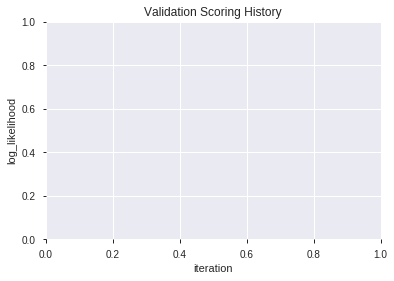

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190903_023514  0.505506  0.710802              0.500000  0.507947  0.258010
1  XGBoost_grid_1_AutoML_20190903_023514_model_3  0.489627  0.708143              0.475125  0.507005  0.257054
2  XGBoost_grid_1_AutoML_20190903_023514_model_5  0.486042  0.735351              0.500000  0.518324  0.268660
3               XGBoost_2_AutoML_20190903_023514  0.465104  0.708143              0.486106  0.507080  0.257130
4  XGBoost_grid_1_AutoML_20190903_023514_model_2  0.455372  0.710526              0.486106  0.508224  0.258292
5  XGBoost_grid_1_AutoML_20190903_023514_model_7  0.444679  0.735887              0.484633  0.519236  0.269606
6               XGBoost_3_AutoML_20190903_023514  0.441990  0.714697              0.482456  0.510258  0.260364
7  XGBoost_grid_1_AutoML_20190903_023514_model_6  0.438276  0.715792              0.484633  0.510732  0.260848
8  XGBoost_grid_1_AutoML_20190903_023514_model_4  0.432386  0.717728              0.490492  0.511806  0.261946
9  XGBoost_grid_1_AutoML_20190903_023514_model_1  0.426367  0.728467              0.500000  0.516467  0.266738

variable  relative_importance  scaled_importance  percentage
0                   DX_8           414.258087           1.000000    0.055710
1   HT_PHASOR_quadrature           357.827118           0.863778    0.048121
2                    BOP           325.316986           0.785300    0.043749
3                 ADXR_8           323.314331           0.780466    0.043480
4                 ATR_30           320.640228           0.774011    0.043120
5              CORREL_24           306.069214           0.738837    0.041160
6              CORREL_20           303.540070           0.732732    0.040820
7              CORREL_30           297.142212           0.717288    0.039960
8                    TAN           293.795868           0.709210    0.039510
9                 SAREXT           288.414429           0.696219    0.038786
10               BETA_14           267.428406           0.645560    0.035964
11                BETA_8           263.998932           0.637281    0.035503
12           HT_DCPERIOD           252.845932           0.610358    0.034003
13               ADXR_14           245.473862           0.592563    0.033011
14            aroonup_30           243.880402           0.588716    0.032797
15           AROONOSC_24           236.862640           0.571776    0.031853
16        STOCHRSI_fastk           222.158615           0.536281    0.029876
17               BETA_24           221.172028           0.533899    0.029743
18               BETA_30           219.508133           0.529883    0.029520
19               ADXR_12           188.512527           0.455061    0.025351
20             CORREL_14           183.532639           0.443039    0.024682
21               BETA_20           179.835556           0.434115    0.024184
22             dayofweek           177.798126           0.429197    0.023910
23             aroonup_8           175.531967           0.423726    0.023606
24           AROONOSC_20           157.289398           0.379689    0.021152
25                   day           147.805649           0.356796    0.019877
26          aroondown_30           138.120331           0.333416    0.018575
27            weekofyear           128.771851           0.310849    0.017317
28            aroonup_24           119.287102           0.287954    0.016042
29          aroondown_20           113.366135           0.273661    0.015246
30          aroondown_24           106.321938           0.256656    0.014298
31          weekday_name            56.590401           0.136607    0.007610
32                 month            54.926094           0.132589    0.007386
33               weekday            42.511971           0.102622    0.005717
34         days_in_month            30.446423           0.073496    0.004094
35          HT_TRENDMODE            24.039848           0.058031    0.003233
36               CDLDOJI             3.931227           0.009490    0.000529
37        CDLRICKSHAWMAN             3.747034           0.009045    0.000504

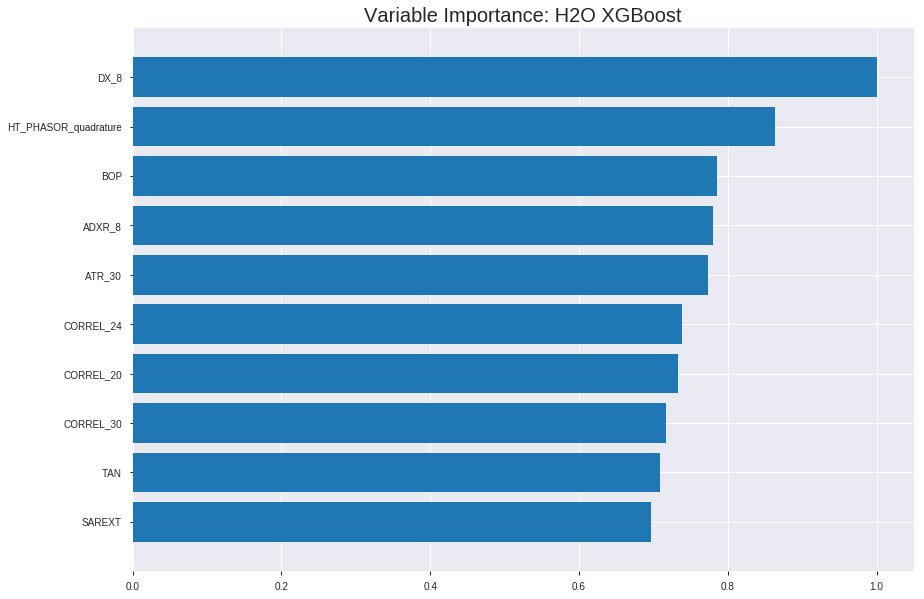

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190903_023514


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15656721276094807
RMSE: 0.3956857500099644
LogLoss: 0.4982131629025335
Mean Per-Class Error: 0.10060276946020119
AUC: 0.9655086257715175
pr_auc: 0.9687101392555794
Gini: 0.931017251543035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5008130818605423: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      743  108  0.1269   (108.0/851.0)
1      71   832  0.0786   (71.0/903.0)
Total  814  940  0.1021   (179.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500813     0.902876  206
max f2                       0.458206     0.927616  238
max f0point5                 0.567494     0.928438  157
max accuracy                 0.540456     0.897948  178
max precision                0.823318     1         0
max recall                   0.367462     1         309
max specificity              0.823318     1         0
max absolute_mcc             0.540456     0.800645  178
max min_per_class_accuracy   0.518456     0.893688  194
max mean_per_class_accuracy  0.540456     0.899397  178

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.777284           1.94241    1.94241            1                0.790264  1                           0.790264            0.0199336       0.0199336                  94.2414   94.2414
    2        0.0205245                   0.761827           1.94241    1.94241            1                0.7697    1                           0.779982            0.0199336       0.0398671                  94.2414   94.2414
    3        0.0302166                   0.747552           1.94241    1.94241            1                0.753438  1                           0.771468            0.0188261       0.0586932                  94.2414   94.2414
    4        0.0404789                   0.737731           1.94241    1.94241            1                0.742723  1                           0.76418             0.0199336       0.0786268                  94.2414   94.2414
    5        0.050171                    0.729414           1.94241    1.94241            1                0.733462  1                           0.758246            0.0188261       0.0974529                  94.2414   94.2414
    6        0.100342                    0.699435           1.94241    1.94241            1                0.714054  1                           0.73615             0.0974529       0.194906                   94.2414   94.2414
    7        0.149943                    0.678332           1.94241    1.94241            1                0.688865  1                           0.720508            0.0963455       0.291251                   94.2414   94.2414
    8        0.200114                    0.655372           1.92034    1.93688            0.988636         0.667131  0.997151                    0.707126            0.0963455       0.387597                   92.0341   93.688
    9        0.299886                    0.612035           1.88692    1.92026            0.971429         0.632211  0.988593                    0.682202            0.188261        0.575858                   88.6917   92.0257
    10       0.400228                    0.569491           1.83205    1.89814            0.943182         0.591436  0.977208                    0.659446            0.183832        0.75969                    83.205    89.8143
    11       0.5                         0.52188            1.25424    1.76966            0.645714         0.546575  0.91106                     0.636923            0.125138        0.884828                   25.4245   76.9657
    12       0.599772                    0.472298           0.710369   1.59344            0.365714         0.495052  0.820342                    0.613323            0.0708749       0.955703                   -28.9631  59.3444
    13       0.700114                    0.426021           0.275911   1.40461            0.142045         0.447343  0.723127                    0.589534            0.0276855       0.983389                   -72.4089  40.4612
    14       0.799886                    0.377251           0.155393   1.24879            0.08             0.402234  0.642908                    0.566172            0.0155039       0.998893                   -84.4607  24.8794
    15       0.899658                    0.314068           0.0110995  1.11153            0.00571429       0.34872   0.572243                    0.542056            0.00110742      1                          -98.89    11.1534
    16       1                           0.167898           0          1                  0                0.27064   0.514823                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2536815914217108
RMSE: 0.5036681361985398
LogLoss: 0.7010393128206058
Mean Per-Class Error: 0.4597450519959745
AUC: 0.5337933898819508
pr_auc: 0.5724460172062071
Gini: 0.0675867797639016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.288480669260025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    226  0.9784   (226.0/231.0)
1      0    271  0        (0.0/271.0)
Total  5    497  0.4502   (226.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288481     0.705729  394
max f2                       0.288481     0.857052  394
max f0point5                 0.288481     0.599823  394
max accuracy                 0.301895     0.549801  386
max precision                0.742313     1         0
max recall                   0.288481     1         394
max specificity              0.742313     1         0
max absolute_mcc             0.288481     0.108639  394
max min_per_class_accuracy   0.520736     0.536797  197
max mean_per_class_accuracy  0.522054     0.540255  195

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 51.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720564           1.23493   1.23493            0.666667         0.734296  0.666667                    0.734296            0.0147601       0.0147601                  23.4932   23.4932
    2        0.0219124                   0.703662           1.11144   1.1788             0.6              0.710134  0.636364                    0.723314            0.0110701       0.0258303                  11.1439   17.8799
    3        0.0318725                   0.688627           1.48192   1.27352            0.8              0.694992  0.6875                      0.714463            0.0147601       0.0405904                  48.1919   27.3524
    4        0.0418327                   0.685057           0.740959  1.14672            0.4              0.686428  0.619048                    0.707788            0.00738007      0.0479705                  -25.9041  14.6723
    5        0.0517928                   0.676497           1.8524    1.28243            1                0.680639  0.692308                    0.702567            0.0184502       0.0664207                  85.2399   28.243
    6        0.101594                    0.642717           0.889151  1.08965            0.48             0.655668  0.588235                    0.679577            0.0442804       0.110701                   -11.0849  8.96462
    7        0.151394                    0.623294           1.11144   1.09681            0.6              0.631839  0.592105                    0.663874            0.0553506       0.166052                   11.1439   9.68149
    8        0.201195                    0.606984           1.25963   1.13712            0.68             0.613697  0.613861                    0.651454            0.0627306       0.228782                   25.9631   13.7116
    9        0.300797                    0.577882           0.926199  1.06728            0.5              0.591486  0.576159                    0.631597            0.0922509       0.321033                   -7.38007  6.7276
    10       0.400398                    0.552966           1.07439   1.06905            0.58             0.56516   0.577114                    0.61507             0.107011        0.428044                   7.43911   6.90459
    11       0.5                         0.521829           1.07439   1.07011            0.58             0.537661  0.577689                    0.59965             0.107011        0.535055                   7.43911   7.01107
    12       0.599602                    0.492628           0.740959  1.01543            0.4              0.507262  0.548173                    0.584303            0.0738007       0.608856                   -25.9041  1.54344
    13       0.699203                    0.451214           1.07439   1.02383            0.58             0.474265  0.552707                    0.568628            0.107011        0.715867                   7.43911   2.38328
    14       0.798805                    0.416558           0.963247  1.01628            0.52             0.435859  0.548628                    0.552073            0.095941        0.811808                   -3.67528  1.62785
    15       0.898406                    0.369125           0.889151  1.00218            0.48             0.393887  0.54102                     0.534536            0.0885609       0.900369                   -11.0849  0.218457
    16       1                           0.216546           0.980682  1                  0.529412         0.324814  0.539841                    0.51323           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:35:14  0.247 sec   0                  0.5              0.693147            0.5             0                  1                0.485177                         0.5                0.693147              0.5               0                    1                  0.460159
    2019-09-03 02:35:15  0.517 sec   5                  0.485388         0.664271            0.801353        0.79849            1.8345           0.258837                         0.49967            0.692491              0.517875          0.540709             1.23493            0.454183
    2019-09-03 02:35:15  0.691 sec   10                 0.472342         0.639039            0.867829        0.870721           1.94241          0.216648                         0.499901           0.692944              0.514177          0.552406             0.926199           0.448207
    2019-09-03 02:35:15  0.834 sec   15                 0.460779         0.616987            0.890183        0.896188           1.94241          0.204105                         0.499371           0.691888              0.530031          0.588939             1.54367            0.460159
    2019-09-03 02:35:15  0.997 sec   20                 0.449497         0.595778            0.912647        0.918113           1.94241          0.172178                         0.498839           0.690809              0.536932          0.583702             1.23493            0.456175
    2019-09-03 02:35:15  1.165 sec   25                 0.439371         0.576961            0.925884        0.933376           1.94241          0.152794                         0.499937           0.692973              0.52841           0.580062             0.926199           0.452191
    2019-09-03 02:35:15  1.326 sec   30                 0.42954          0.558957            0.937249        0.943686           1.94241          0.131129                         0.501676           0.696556              0.522755          0.561958             1.23493            0.450199
    2019-09-03 02:35:16  1.474 sec   35                 0.420157         0.541921            0.947657        0.952613           1.94241          0.124857                         0.501365           0.695944              0.530527          0.576472             1.54367            0.450199
    2019-09-03 02:35:16  1.638 sec   40                 0.411752         0.526809            0.955045        0.959426           1.94241          0.115165                         0.501673           0.696643              0.534928          0.578055             1.23493            0.452191
    2019-09-03 02:35:16  1.789 sec   45                 0.403425         0.511922            0.960382        0.964337           1.94241          0.108324                         0.503078           0.699681              0.532188          0.571418             1.23493            0.450199
    2019-09-03 02:35:16  1.957 sec   50                 0.395686         0.498213            0.965509        0.96871            1.94241          0.102052                         0.503668           0.701039              0.533793          0.572446             1.23493            0.450199

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
DX_8                  414.2580871582031      1.0                   0.05570969924371111
HT_PHASOR_quadrature  357.8271179199219      0.8637782315237444    0.04812082549145247
BOP                   325.3169860839844      0.7853002661110329    0.043748841641051944
ADXR_8                323.3143310546875      0.7804659488306268    0.043479523279311844
ATR_30                320.6402282714844      0.7740107875046346    0.04311990818327119
---                   ---                    ---                   ---
weekday               42.51197052001953      0.10262194471965594   0.00571703767613678
days_in_month         30.446422576904297     0.07349626602528331   0.004094454875804316
HT_TRENDMODE          24.03984832763672      0.05803108997231482   0.003232894569142398
CDLDOJI               3.9312267303466797     0.009489800808270917  0.0005286739489114993
CDLRICKSHAWMAN        3.7470343112945557     0.009045168766647594  0.0005039036315985468


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.7061855670103092)

('auc', 0.5055064668971699)

('logloss', 0.7108019891552612)

('mean_per_class_error', 0.46027020105007044)

('rmse', 0.5079472359503552)

('mse', 0.2580103945096058)

xgboost prediction progress: |████████████████████████████████████████████| 100%


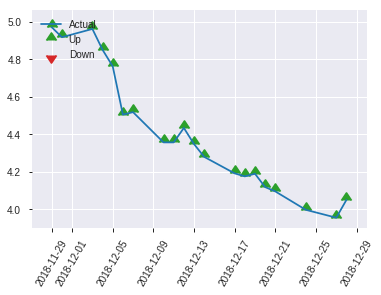


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2580103945096058
RMSE: 0.5079472359503552
LogLoss: 0.7108019891552612
Mean Per-Class Error: 0.46027020105007044
AUC: 0.5055064668971699
pr_auc: 0.5263138392681003
Gini: 0.011012933794339874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24345442652702332: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243454     0.706186  250
max f2                       0.243454     0.857322  250
max f0point5                 0.388152     0.612536  228
max accuracy                 0.407598     0.569721  218
max precision                0.789741     1         0
max recall                   0.243454     1         250
max specificity              0.789741     1         0
max absolute_mcc             0.388152     0.113411  228
max min_per_class_accuracy   0.526803     0.510949  124
max mean_per_class_accuracy  0.498352     0.53973   153

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.73945            0.610706  0.610706           0.333333         0.759813  0.333333                    0.759813            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.729005           0.610706  0.610706           0.333333         0.732373  0.333333                    0.746093            0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.725312           0.916058  0.687044           0.5              0.726674  0.375                       0.741238            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.706094           1.22141   0.83278            0.666667         0.713708  0.454545                    0.73373             0.0145985       0.0364964                  22.1411   -16.722
    5        0.0517928                   0.691732           0.916058  0.845592           0.5              0.699366  0.461538                    0.728443            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.660429           0.986524  0.916058           0.538462         0.674376  0.5                         0.70141             0.0510949       0.0948905                  -1.34756  -8.39416
    7        0.151394                    0.639082           0.458029  0.771418           0.25             0.648259  0.421053                    0.684625            0.0218978       0.116788                   -54.1971  -22.8582
    8        0.203187                    0.620896           1.26839   0.898096           0.692308         0.629482  0.490196                    0.670569            0.0656934       0.182482                   26.8389   -10.1904
    9        0.302789                    0.595238           0.952701  0.916058           0.52             0.606485  0.5                         0.649489            0.0948905       0.277372                   -4.72993  -8.39416
    10       0.40239                     0.553968           1.39241   1.03397            0.76             0.569888  0.564356                    0.629786            0.138686        0.416058                   39.2409   3.39669
    11       0.501992                    0.52312            0.952701  1.01784            0.52             0.542294  0.555556                    0.612426            0.0948905       0.510949                   -4.72993  1.78427
    12       0.601594                    0.500201           1.17255   1.04346            0.64             0.512356  0.569536                    0.595858            0.116788        0.627737                   17.2555   4.34572
    13       0.701195                    0.481875           0.879416  1.02016            0.48             0.490957  0.556818                    0.580957            0.0875912       0.715328                   -12.0584  2.01559
    14       0.800797                    0.443376           0.952701  1.01177            0.52             0.460269  0.552239                    0.565946            0.0948905       0.810219                   -4.72993  1.1766
    15       0.900398                    0.393209           1.09927   1.02145            0.6              0.420371  0.557522                    0.549843            0.109489        0.919708                   9.92701   2.14456
    16       1                           0.243454           0.806131  1                  0.44             0.355612  0.545817                    0.530497  

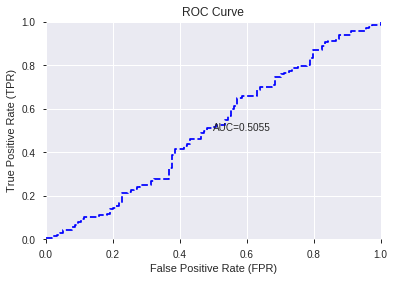

This function is available for GLM models only


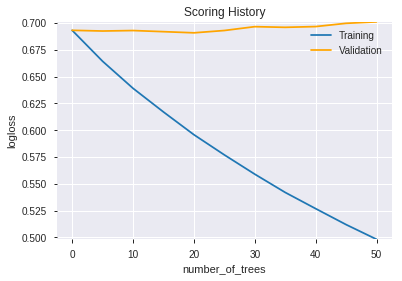

--2019-09-03 02:35:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190903_023514',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190903_023514',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_984b',
   'type

['DX_8',
 'HT_PHASOR_quadrature',
 'BOP',
 'ADXR_8',
 'ATR_30',
 'CORREL_24',
 'CORREL_20',
 'CORREL_30',
 'TAN',
 'SAREXT',
 'BETA_14',
 'BETA_8',
 'HT_DCPERIOD',
 'ADXR_14',
 'aroonup_30',
 'AROONOSC_24',
 'STOCHRSI_fastk',
 'BETA_24',
 'BETA_30',
 'ADXR_12',
 'CORREL_14',
 'BETA_20',
 'dayofweek',
 'aroonup_8',
 'AROONOSC_20',
 'day',
 'aroondown_30',
 'weekofyear',
 'aroonup_24',
 'aroondown_20',
 'aroondown_24',
 'weekday_name',
 'month',
 'weekday',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLRICKSHAWMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023548_model_1  0.43818  0.696031                   0.5  0.501433  0.251435

variable  relative_importance  scaled_importance    percentage
0                      weekday         1.108373e-02           1.000000  1.488353e-02
1                    dayofweek         1.106441e-02           0.998257  1.485758e-02
2                       BETA_8         1.097223e-02           0.989940  1.473379e-02
3         HT_PHASOR_quadrature         1.050676e-02           0.947944  1.410875e-02
4                   aroonup_30         9.250079e-03           0.834563  1.242125e-02
...                        ...                  ...                ...           ...
1037   BBANDS_upperband_24_2_2         1.111007e-06           0.000100  1.491889e-06
1038  BBANDS_middleband_30_1_4         6.166945e-07           0.000056  8.281136e-07
1039   BBANDS_upperband_20_5_3         5.599934e-07           0.000051  7.519738e-07
1040  BBANDS_middleband_30_0_4         3.891296e-07           0.000035  5.225334e-07
1041   BBANDS_lowerband_14_7_4         1.132228e-07           0.000010  1.520386e-07

[1042 rows x 4 columns]

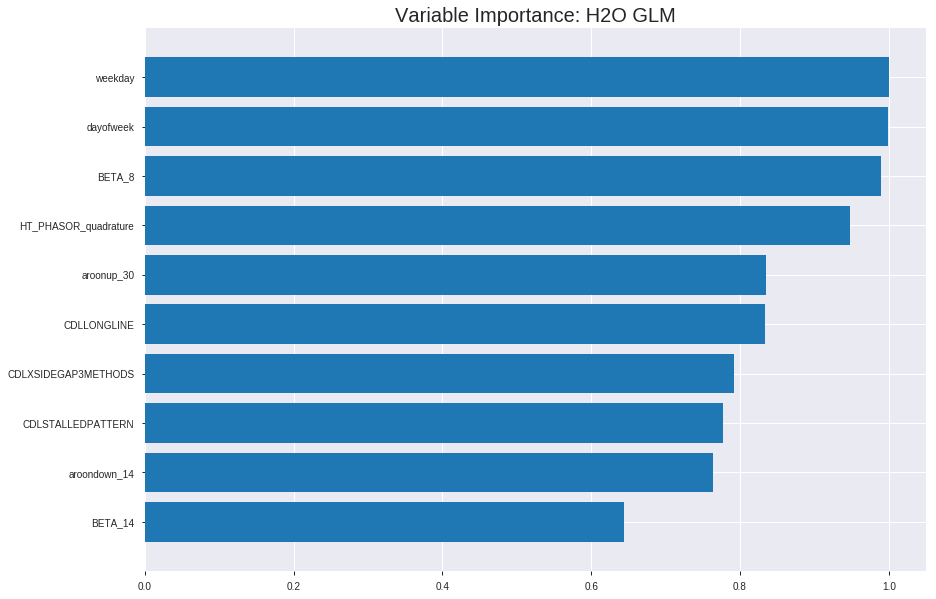

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023548_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2463873928136636
RMSE: 0.496374246726866
LogLoss: 0.6858984001912245
Null degrees of freedom: 1753
Residual degrees of freedom: 711
Null deviance: 2430.0184643429493
Residual deviance: 2406.1315878708156
AIC: 4492.131587870816
AUC: 0.5899528012773715
pr_auc: 0.601925008562306
Gini: 0.17990560255474297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4767683879117792: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      63   788   0.926    (788.0/851.0)
1      24   879   0.0266   (24.0/903.0)
Total  87   1667  0.4629   (812.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476768     0.684047  352
max f2                       0.456474     0.843295  390
max f0point5                 0.491284     0.589007  305
max accuracy                 0.520466     0.564424  172
max precision                0.578181     0.888889  8
max recall                   0.456474     1         390
max specificity              0.624136     0.998825  0
max absolute_mcc             0.536797     0.13791   100
max min_per_class_accuracy   0.514715     0.553467  199
max mean_per_class_accuracy  0.520466     0.567154  172

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.572482           1.51077   1.51077            0.777778         0.585231  0.777778                    0.585231            0.0155039       0.0155039                  51.0767    51.0767
    2        0.0205245                   0.562032           1.61868   1.56472            0.833333         0.565668  0.805556                    0.57545             0.0166113       0.0321152                  61.8678    56.4723
    3        0.0302166                   0.556662           1.02834   1.39267            0.529412         0.558987  0.716981                    0.570169            0.00996678      0.0420819                  2.83369    39.2674
    4        0.0404789                   0.553932           1.51077   1.42261            0.777778         0.554869  0.732394                    0.56629             0.0155039       0.0575858                  51.0767    42.2613
    5        0.050171                    0.552213           1.25686   1.39059            0.647059         0.553182  0.715909                    0.563758            0.0121816       0.0697674                  25.6856    39.0592
    6        0.100342                    0.543726           1.3023    1.34645            0.670455         0.547334  0.693182                    0.555546            0.0653378       0.135105                   30.23      34.6446
    7        0.149943                    0.539364           1.13866   1.27771            0.586207         0.541455  0.657795                    0.550885            0.0564784       0.191584                   13.8657    27.771
    8        0.200114                    0.535633           1.19194   1.25621            0.613636         0.537646  0.646724                    0.547565            0.0598007       0.251384                   19.1936    25.6205
    9        0.299886                    0.527267           1.02115   1.178              0.525714         0.531295  0.606464                    0.542152            0.101883        0.353267                   2.11549    17.8004
    10       0.400228                    0.520891           1.10364   1.15936            0.568182         0.523994  0.596866                    0.5376              0.110742        0.464009                   10.3644    15.9361
    11       0.5                         0.514731           0.876861  1.10299            0.451429         0.517945  0.567845                    0.533678            0.0874862       0.551495                   -12.3139   10.299
    12       0.599772                    0.508553           0.976757  1.08199            0.502857         0.511458  0.557034                    0.529982            0.0974529       0.648948                   -2.32432   8.19912
    13       0.700114                    0.502159           0.971207  1.06611            0.5              0.505313  0.54886                     0.526446            0.0974529       0.746401                   -2.87929   6.61133
    14       0.799886                    0.495224           0.998956  1.05774            0.514286         0.498756  0.544547                    0.522992            0.0996678       0.846069                   -0.104414  5.77366
    15       0.899658                    0.48507            0.887961  1.03891            0.457143         0.490592  0.534854                    0.519399            0.0885936       0.934662                   -11.2039   3.89085
    16       1                           0.416364           0.65115   1                  0.335227         0.473798  0.514823                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24779320002378982
RMSE: 0.49778830844425204
LogLoss: 0.6887096099178481
Null degrees of freedom: 501
Residual degrees of freedom: -541
Null deviance: 693.9887622709523
Residual deviance: 691.4644483575195
AIC: 2777.4644483575194
AUC: 0.5372997236465872
pr_auc: 0.5902489915083227
Gini: 0.07459944729317436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4352907336741921: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435291     0.701164  399
max f2                       0.435291     0.854351  399
max f0point5                 0.500085     0.599045  355
max accuracy                 0.504979     0.553785  331
max precision                0.592102     1         0
max recall                   0.435291     1         399
max specificity              0.592102     1         0
max absolute_mcc             0.575869     0.131625  9
max min_per_class_accuracy   0.525914     0.519481  203
max mean_per_class_accuracy  0.523178     0.547811  224

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.58011            1.8524    1.8524             1                0.586411  1                           0.586411            0.0221402       0.0221402                  85.2399    85.2399
    2        0.0219124                   0.57557            1.48192   1.684              0.8              0.576933  0.909091                    0.582103            0.0147601       0.0369004                  48.1919    68.3999
    3        0.0318725                   0.571553           1.11144   1.50507            0.6              0.573442  0.8125                      0.579396            0.0110701       0.0479705                  11.1439    50.5074
    4        0.0418327                   0.567963           1.11144   1.41135            0.6              0.569333  0.761905                    0.577               0.0110701       0.0590406                  11.1439    41.1351
    5        0.0517928                   0.564942           1.48192   1.42492            0.8              0.56612   0.769231                    0.574908            0.0147601       0.0738007                  48.1919    42.4922
    6        0.101594                    0.557856           0.740959  1.08965            0.4              0.561112  0.588235                    0.568145            0.0369004       0.110701                   -25.9041   8.96462
    7        0.151394                    0.549376           1.25963   1.14556            0.68             0.55314   0.618421                    0.563209            0.0627306       0.173432                   25.9631    14.5562
    8        0.201195                    0.545684           0.815055  1.06375            0.44             0.547239  0.574257                    0.559256            0.0405904       0.214022                   -18.4945   6.37536
    9        0.300797                    0.538742           1.0003    1.04274            0.54             0.542284  0.562914                    0.553636            0.099631        0.313653                   0.0295203  4.27409
    10       0.400398                    0.531885           0.963247  1.02297            0.52             0.534956  0.552239                    0.548989            0.095941        0.409594                   -3.67528   2.29663
    11       0.5                         0.525951           1.07439   1.03321            0.58             0.528831  0.557769                    0.544974            0.107011        0.516605                   7.43911    3.32103
    12       0.599602                    0.521163           1.07439   1.04005            0.58             0.523441  0.561462                    0.541397            0.107011        0.623616                   7.43911    4.0051
    13       0.699203                    0.516141           0.889151  1.01856            0.48             0.518709  0.549858                    0.538165            0.0885609       0.712177                   -11.0849   1.85553
    14       0.798805                    0.509432           1.03734   1.0209             0.56             0.513184  0.551122                    0.53505             0.103321        0.815498                   3.73432    2.08979
    15       0.898406                    0.500265           0.963247  1.01451            0.52             0.504829  0.547672                    0.5317              0.095941        0.911439                   -3.67528   1.45065
    16       1                           0.435291           0.871717  1                  0.470588         0.488323  0.539841                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:35:52  0.000 sec   2            3.2       1040          1.37459           1.37756
    2019-09-03 02:35:54  2.273 sec   4            2.3       1043          1.3718            1.37742
    2019-09-03 02:35:57  4.533 sec   6            1.7       1043          1.3685            1.37761
    2019-09-03 02:35:59  6.827 sec   8            1.2       1043          1.36465           1.37817
    2019-09-03 02:36:01  9.091 sec   10           0.9       1043          1.36022           1.3793
    2019-09-03 02:36:03  11.339 sec  12           0.66      1043          1.35525           1.3812
    2019-09-03 02:36:06  13.725 sec  14           0.48      1043          1.34981           1.38409

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.7061855670103092)

('auc', 0.4381803047765399)

('logloss', 0.6960310005488157)

('mean_per_class_error', 0.4838647714175951)

('rmse', 0.5014326427211825)

('mse', 0.2514346951863491)

glm prediction progress: |████████████████████████████████████████████████| 100%


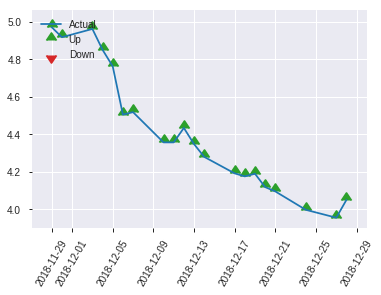


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514346951863491
RMSE: 0.5014326427211825
LogLoss: 0.6960310005488157
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 346.81644986094483
Residual deviance: 349.4075622755055
AIC: 2435.4075622755054
AUC: 0.4381803047765399
pr_auc: 0.4953355822688185
Gini: -0.12363939044692018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47112377062453775: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471124     0.706186  249
max f2                       0.471124     0.857322  249
max f0point5                 0.489171     0.603039  227
max accuracy                 0.489171     0.553785  227
max precision                0.578955     1         0
max recall                   0.471124     1         249
max specificity              0.578955     1         0
max absolute_mcc             0.520827     0.165972  78
max min_per_class_accuracy   0.513327     0.429825  122
max mean_per_class_accuracy  0.489171     0.516135  227

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.574302           1.22141   1.22141            0.666667         0.577519  0.666667                    0.577519            0.0145985       0.0145985                  22.1411   22.1411
    2        0.0239044                   0.568995           0         0.610706           0                0.570599  0.333333                    0.574059            0               0.0145985                  -100      -38.9294
    3        0.0318725                   0.562107           0.916058  0.687044           0.5              0.562741  0.375                       0.57123             0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.557553           0.610706  0.666224           0.333333         0.560031  0.363636                    0.568175            0.00729927      0.0291971                  -38.9294  -33.3776
    5        0.0517928                   0.553185           0.916058  0.70466            0.5              0.55542   0.384615                    0.566213            0.00729927      0.0364964                  -8.39416  -29.534
    6        0.103586                    0.540747           0.845592  0.775126           0.461538         0.546188  0.423077                    0.556201            0.0437956       0.080292                   -15.4408  -22.4874
    7        0.151394                    0.534761           0.916058  0.819631           0.5              0.537875  0.447368                    0.550414            0.0437956       0.124088                   -8.39416  -18.0369
    8        0.203187                    0.529823           0.70466   0.790325           0.384615         0.532131  0.431373                    0.545753            0.0364964       0.160584                   -29.534   -20.9675
    9        0.302789                    0.522893           0.806131  0.795524           0.44             0.525659  0.434211                    0.539143            0.080292        0.240876                   -19.3869  -20.4476
    10       0.40239                     0.517961           1.17255   0.888849           0.64             0.519509  0.485149                    0.534283            0.116788        0.357664                   17.2555   -11.1151
    11       0.501992                    0.513037           0.879416  0.886977           0.48             0.515377  0.484127                    0.530532            0.0875912       0.445255                   -12.0584  -11.3023
    12       0.601594                    0.508539           1.17255   0.934258           0.64             0.510797  0.509934                    0.527265            0.116788        0.562044                   17.2555   -6.57418
    13       0.701195                    0.502201           1.39241   0.999336           0.76             0.505358  0.545455                    0.524153            0.138686        0.70073                    39.2409   -0.066357
    14       0.800797                    0.495829           0.952701  0.993536           0.52             0.498557  0.542289                    0.520969            0.0948905       0.79562                    -4.72993  -0.646403
    15       0.900398                    0.489369           1.09927   1.00523            0.6              0.493334  0.548673                    0.517912            0.109489        0.905109                   9.92701   0.523222
    16       1                           0.471124           0.952701  1                  0.52             0.483997  0.545817                    0.

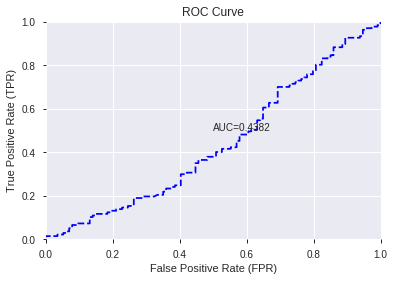

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


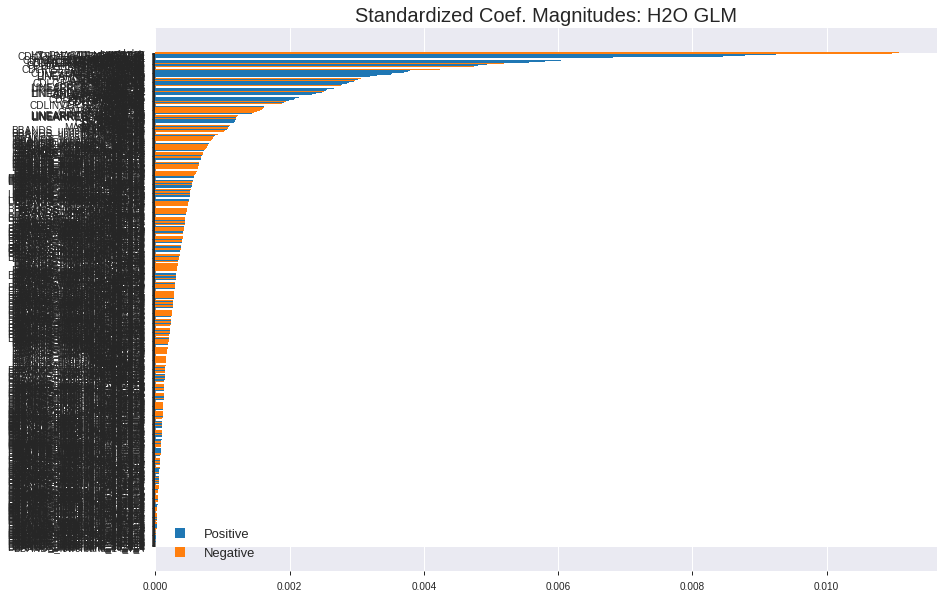

'log_likelihood'
--2019-09-03 02:36:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023548_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023548_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

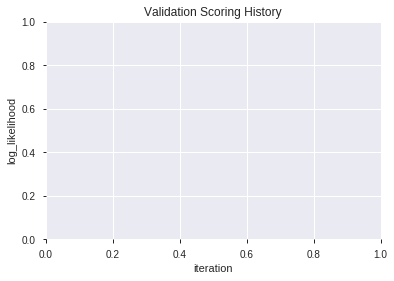

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_023641_model_6  0.519785  0.697234              0.486106  0.501808  0.251811
1               XGBoost_2_AutoML_20190903_023641  0.487322  0.707724              0.457581  0.506934  0.256982
2  XGBoost_grid_1_AutoML_20190903_023641_model_1  0.482744  0.705336              0.467826  0.505716  0.255749
3  XGBoost_grid_1_AutoML_20190903_023641_model_3  0.475349  0.707970              0.491228  0.506908  0.256956
4  XGBoost_grid_1_AutoML_20190903_023641_model_7  0.472532  0.729038              0.482456  0.515991  0.266247
5  XGBoost_grid_1_AutoML_20190903_023641_model_4  0.467153  0.708574              0.494878  0.507449  0.257504
6               XGBoost_1_AutoML_20190903_023641  0.455692  0.717970              0.461967  0.511575  0.261709
7               XGBoost_3_AutoML_20190903_023641  0.446728  0.719844              0.486842  0.512110  0.262256
8  XGBoost_grid_1_AutoML_20190903_023641_model_5  0.435011  0.754476              0.490492  0.527074  0.277807
9  XGBoost_grid_1_AutoML_20190903_023641_model_2  0.406262  0.718924              0.490492  0.512431  0.262585

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8           136.268082           1.000000    0.019330
1                        BOP           122.807892           0.901223    0.017420
2                     ADX_24           117.269585           0.860580    0.016635
3                     Volume           107.347954           0.787770    0.015227
4                     ADXR_8           105.977135           0.777711    0.015033
..                       ...                  ...                ...         ...
303  BBANDS_lowerband_24_1_4             2.823604           0.020721    0.000401
304   BBANDS_lowerband_8_1_3             2.738153           0.020094    0.000388
305   BBANDS_lowerband_8_8_5             2.523397           0.018518    0.000358
306  BBANDS_upperband_14_1_3             2.429855           0.017831    0.000345
307              aroondown_8             2.175873           0.015968    0.000309

[308 rows x 4 columns]

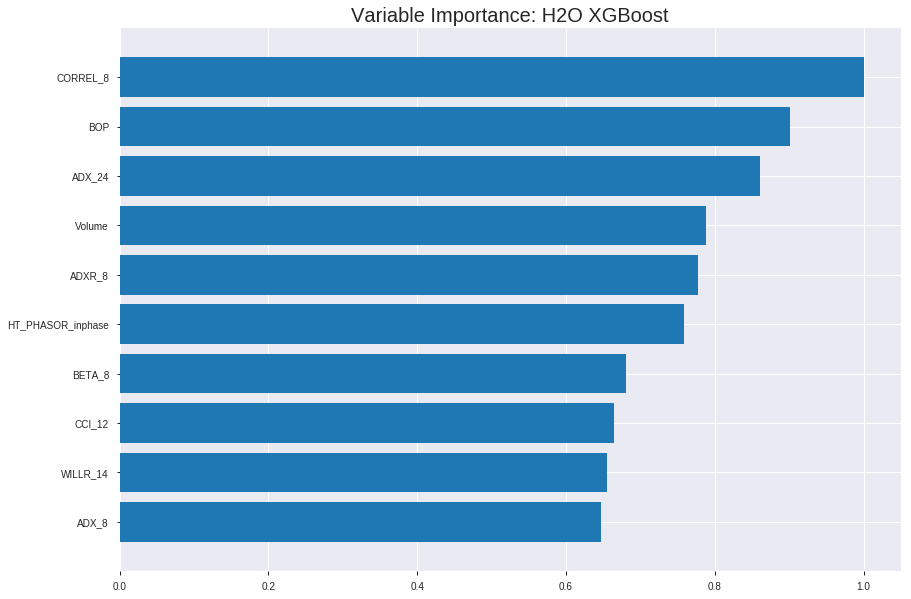

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_023641_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17921112960749697
RMSE: 0.4233333551794578
LogLoss: 0.5475429970441168
Mean Per-Class Error: 0.1264208741458488
AUC: 0.9459368367356233
pr_auc: 0.9449027701523244
Gini: 0.8918736734712467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48996271938085556: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      686  165  0.1939   (165.0/851.0)
1      69   834  0.0764   (69.0/903.0)
Total  755  999  0.1334   (234.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489963     0.876972  222
max f2                       0.459093     0.924607  252
max f0point5                 0.548467     0.892127  168
max accuracy                 0.516553     0.872862  197
max precision                0.814713     1         0
max recall                   0.354082     1         355
max specificity              0.814713     1         0
max absolute_mcc             0.516553     0.747087  197
max min_per_class_accuracy   0.508395     0.870432  204
max mean_per_class_accuracy  0.516553     0.873579  197

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.752727           1.94241    1.94241            1                0.772746  1                           0.772746            0.0199336       0.0199336                  94.2414   94.2414
    2        0.0205245                   0.733792           1.94241    1.94241            1                0.741944  1                           0.757345            0.0199336       0.0398671                  94.2414   94.2414
    3        0.0302166                   0.715954           1.94241    1.94241            1                0.722746  1                           0.746247            0.0188261       0.0586932                  94.2414   94.2414
    4        0.0404789                   0.705086           1.94241    1.94241            1                0.711699  1                           0.737488            0.0199336       0.0786268                  94.2414   94.2414
    5        0.050171                    0.693573           1.94241    1.94241            1                0.700092  1                           0.730264            0.0188261       0.0974529                  94.2414   94.2414
    6        0.100342                    0.661784           1.89827    1.92034            0.977273         0.675882  0.988636                    0.703073            0.0952381       0.192691                   89.8268   92.0341
    7        0.149943                    0.636023           1.92009    1.92026            0.988506         0.647928  0.988593                    0.684831            0.0952381       0.287929                   92.0088   92.0257
    8        0.200114                    0.615483           1.80998    1.89261            0.931818         0.625427  0.974359                    0.669938            0.0908084       0.378738                   80.9977   89.2609
    9        0.299886                    0.581376           1.85362    1.87964            0.954286         0.598439  0.967681                    0.64615             0.184939        0.563677                   85.3618   87.9637
    10       0.400228                    0.546058           1.67754    1.82897            0.863636         0.563806  0.941595                    0.625506            0.168328        0.732004                   67.754    82.8968
    11       0.5                         0.51189            1.29864    1.72315            0.668571         0.52909   0.887115                    0.606267            0.129568        0.861573                   29.8643   72.3145
    12       0.599772                    0.480254           0.821364   1.57313            0.422857         0.495609  0.809886                    0.587859            0.0819491       0.943522                   -17.8636  57.3134
    13       0.700114                    0.44768            0.419385   1.40778            0.215909         0.463741  0.724756                    0.57007             0.0420819       0.985604                   -58.0615  40.7776
    14       0.799886                    0.410586           0.0998956  1.24464            0.0514286        0.429072  0.64077                     0.552483            0.00996678      0.99557                    -90.0104  24.464
    15       0.899658                    0.366048           0.0332985  1.1103             0.0171429        0.389252  0.57161                     0.534381            0.00332226      0.998893                   -96.6701  11.0303
    16       1                           0.217788           0.0110364  1                  0.00568182       0.333695  0.514823                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2517085792209544
RMSE: 0.5017056699111088
LogLoss: 0.6967594120426474
Mean Per-Class Error: 0.470879059439945
AUC: 0.5136739029727959
pr_auc: 0.5492459055505546
Gini: 0.02734780594559183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3172776401042938: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    230  0.9957   (230.0/231.0)
1      0    271  0        (0.0/271.0)
Total  1    501  0.4582   (230.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.317278     0.702073   398
max f2                       0.317278     0.85489    398
max f0point5                 0.415645     0.601017   371
max accuracy                 0.442683     0.553785   347
max precision                0.748982     1          0
max recall                   0.317278     1          398
max specificity              0.748982     1          0
max absolute_mcc             0.415645     0.0797514  371
max min_per_class_accuracy   0.520845     0.510823   196
max mean_per_class_accuracy  0.559694     0.529121   121

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.696341           0.926199  0.926199           0.5              0.721787  0.5                         0.721787            0.0110701       0.0110701                  -7.38007   -7.38007
    2        0.0219124                   0.686808           1.48192   1.1788             0.8              0.692072  0.636364                    0.70828             0.0147601       0.0258303                  48.1919    17.8799
    3        0.0318725                   0.664152           0.740959  1.04197            0.4              0.671371  0.5625                      0.696746            0.00738007      0.0332103                  -25.9041   4.19742
    4        0.0418327                   0.654291           1.11144   1.05851            0.6              0.656932  0.571429                    0.687266            0.0110701       0.0442804                  11.1439    5.85134
    5        0.0517928                   0.649886           0.740959  0.997445           0.4              0.650838  0.538462                    0.680261            0.00738007      0.0516605                  -25.9041   -0.255464
    6        0.101594                    0.618364           0.889151  0.94436            0.48             0.634017  0.509804                    0.657592            0.0442804       0.095941                   -11.0849   -5.564
    7        0.151394                    0.601821           1.25963   1.04807            0.68             0.60915   0.565789                    0.641657            0.0627306       0.158672                   25.9631    4.80676
    8        0.201195                    0.585129           0.889151  1.00873            0.48             0.59213   0.544554                    0.629398            0.0442804       0.202952                   -11.0849   0.873187
    9        0.300797                    0.554913           1.14849   1.05501            0.62             0.568859  0.569536                    0.609352            0.114391        0.317343                   14.8487    5.50084
    10       0.400398                    0.536792           1.0003    1.0414             0.54             0.544238  0.562189                    0.593154            0.099631        0.416974                   0.0295203  4.13982
    11       0.5                         0.520845           0.926199  1.01845            0.5              0.52827   0.549801                    0.580229            0.0922509       0.509225                   -7.38007   1.84502
    12       0.599602                    0.50414            0.778007  0.97851            0.42             0.512849  0.528239                    0.569037            0.0774908       0.586716                   -22.1993   -2.14905
    13       0.699203                    0.484124           1.18554   1.008              0.64             0.49334   0.54416                     0.558254            0.118081        0.704797                   18.5535    0.800034
    14       0.798805                    0.465066           0.963247  1.00242            0.52             0.474608  0.541147                    0.547824            0.095941        0.800738                   -3.67528   0.242015
    15       0.898406                    0.439104           1.11144   1.01451            0.6              0.452536  0.547672                    0.53726             0.110701        0.911439                   11.1439    1.45065
    16       1                           0.275051           0.871717  1                  0.470588         0.402409  0.539841              


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:37:30  30.189 sec  0                  0.5              0.693147            0.5             0                  1                0.485177                         0.5                0.693147              0.5               0                    1                  0.460159
    2019-09-03 02:37:31  31.340 sec  5                  0.49013          0.673559            0.752088        0.767481           1.94241          0.333523                         0.499188           0.691521              0.517875          0.550485             0.926199           0.440239
    2019-09-03 02:37:31  31.577 sec  10                 0.480979         0.655661            0.822804        0.833927           1.94241          0.285063                         0.498832           0.690797              0.520151          0.576853             1.54367            0.460159
    2019-09-03 02:37:32  31.812 sec  15                 0.473246         0.640694            0.854823        0.865699           1.94241          0.22862                          0.49947            0.692109              0.518123          0.543896             0.926199           0.458167
    2019-09-03 02:37:32  32.055 sec  20                 0.465988         0.626742            0.875927        0.883309           1.94241          0.205245                         0.499538           0.692223              0.514033          0.557767             1.23493            0.460159
    2019-09-03 02:37:32  32.300 sec  25                 0.458692         0.612877            0.889242        0.892307           1.94241          0.188712                         0.500607           0.694382              0.509585          0.555607             1.54367            0.458167
    2019-09-03 02:37:32  32.538 sec  30                 0.451229         0.598828            0.905398        0.907996           1.94241          0.168187                         0.500603           0.694404              0.51107           0.553923             0.926199           0.458167
    2019-09-03 02:37:32  32.782 sec  35                 0.444534         0.586351            0.917512        0.918876           1.94241          0.161345                         0.499621           0.692429              0.525             0.561794             1.23493            0.458167
    2019-09-03 02:37:33  33.022 sec  40                 0.437659         0.573591            0.92713         0.928014           1.94241          0.149943                         0.500417           0.694039              0.517787          0.558115             0.926199           0.458167
    2019-09-03 02:37:33  33.273 sec  45                 0.431323         0.561987            0.937071        0.936095           1.94241          0.141961                         0.499781           0.692723              0.525519          0.561914             1.23493            0.458167
    2019-09-03 02:37:33  33.526 sec  50                 0.423333         0.547543            0.945937        0.944903           1.94241          0.133409                         0.501706           0.696759              0.513674          0.549246             0.926199           0.458167

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_8                 136.26808166503906     1.0                   0.019329524676597445
BOP                      122.80789184570312     0.9012227246845489    0.017420206895900375
ADX_24                   117.26958465576172     0.8605799921952553    0.016634602195324224
Volume                   107.34795379638672     0.7877703456650913    0.015227226336025083
ADXR_8                   105.97713470458984     0.7777106231310463    0.015032776681063538
---                      ---                    ---                   ---
BBANDS_lowerband_24_1_4  2.823603630065918      0.020720946501665928  0.00040052604672640704
BBANDS_lowerband_8_1_3   2.7381534576416016     0.020093872491522     0.0003884050041732771
BBANDS_lowerband_8_8_5   2.5233969688415527     0.018517887226477008  0.000357941958102636
BBANDS_upperband_14_1_3  2.4298553466796875     0.01783143430941166   0.00034467314950289903
aroondown_8              2.175873041152954      0.01596759134322793   0.000308645950894748


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.710182767624021)

('auc', 0.5197848636189013)

('logloss', 0.6972338093844799)

('mean_per_class_error', 0.43770008964015883)

('rmse', 0.501808114019438)

('mse', 0.2518113832957454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


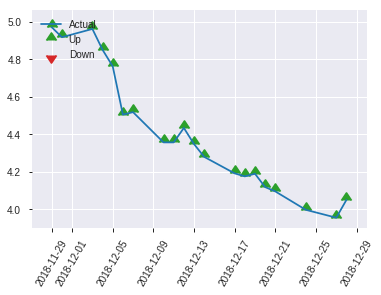


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2518113832957454
RMSE: 0.501808114019438
LogLoss: 0.6972338093844799
Mean Per-Class Error: 0.43770008964015883
AUC: 0.5197848636189013
pr_auc: 0.5306405614916367
Gini: 0.03956972723780261
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3807324171066284: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    110  0.9649   (110.0/114.0)
1      1    136  0.0073   (1.0/137.0)
Total  5    246  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380732     0.710183  245
max f2                       0.369004     0.859473  248
max f0point5                 0.479676     0.618497  181
max accuracy                 0.480441     0.581673  179
max precision                0.48439      0.589595  172
max recall                   0.369004     1         248
max specificity              0.716145     0.991228  0
max absolute_mcc             0.480441     0.137741  179
max min_per_class_accuracy   0.520816     0.525547  125
max mean_per_class_accuracy  0.480441     0.5623    179

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.678398           0.610706  0.610706           0.333333         0.69952   0.333333                    0.69952             0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.66224            0.610706  0.610706           0.333333         0.668859  0.333333                    0.68419             0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.651071           0.916058  0.687044           0.5              0.654327  0.375                       0.676724            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.649749           1.22141   0.83278            0.666667         0.650095  0.454545                    0.669462            0.0145985       0.0364964                  22.1411   -16.722
    5        0.0517928                   0.643333           0         0.70466            0                0.645506  0.384615                    0.665776            0               0.0364964                  -100      -29.534
    6        0.103586                    0.626143           0.845592  0.775126           0.461538         0.633732  0.423077                    0.649754            0.0437956       0.080292                   -15.4408  -22.4874
    7        0.151394                    0.604339           1.06873   0.867845           0.583333         0.613624  0.473684                    0.638344            0.0510949       0.131387                   6.87348   -13.2155
    8        0.203187                    0.589913           0.986524  0.898096           0.538462         0.596597  0.490196                    0.627703            0.0510949       0.182482                   -1.34756  -10.1904
    9        0.302789                    0.567589           0.952701  0.916058           0.52             0.577229  0.5                         0.6111              0.0948905       0.277372                   -4.72993  -8.39416
    10       0.40239                     0.54253            1.17255   0.979548           0.64             0.553329  0.534653                    0.5968              0.116788        0.394161                   17.2555   -2.04524
    11       0.501992                    0.520816           1.31912   1.04692            0.72             0.53064   0.571429                    0.583673            0.131387        0.525547                   31.9124   4.69239
    12       0.601594                    0.501658           1.09927   1.05559            0.6              0.510526  0.576159                    0.571563            0.109489        0.635036                   9.92701   5.55905
    13       0.701195                    0.481507           1.09927   1.06179            0.6              0.491742  0.579545                    0.560225            0.109489        0.744526                   9.92701   6.1795
    14       0.800797                    0.458288           0.806131  1.03               0.44             0.471216  0.562189                    0.549154            0.080292        0.824818                   -19.3869  2.9996
    15       0.900398                    0.433265           1.09927   1.03766            0.6              0.446     0.566372                    0.537743            0.109489        0.934307                   9.92701   3.76591
    16       1                           0.356434           0.659562  1                  0.36             0.405738  0.545817                    0.524595   

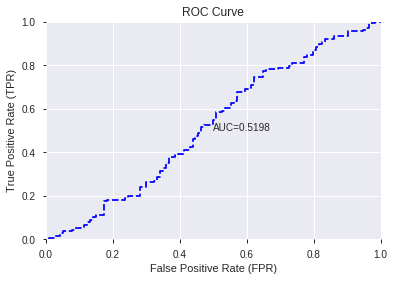

This function is available for GLM models only


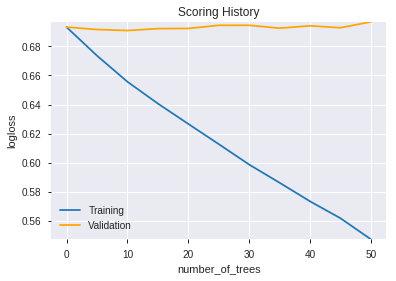

--2019-09-03 02:37:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_023641_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_023641_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023758_model_1  0.502881  1.365053              0.471475  0.596312  0.355588
1  DeepLearning_grid_1_AutoML_20190903_023758_model_2  0.484761  1.118916              0.461967  0.589513  0.347525
2  DeepLearning_grid_1_AutoML_20190903_023758_model_5  0.483865  0.702399              0.495614  0.504558  0.254579
3  DeepLearning_grid_1_AutoML_20190903_023758_model_3  0.480407  1.060933              0.494878  0.572877  0.328188
4  DeepLearning_grid_1_AutoML_20190903_023758_model_4  0.463055  1.032126              0.490492  0.580136  0.336557
5  DeepLearning_grid_1_AutoML_20190903_023758_model_7  0.453035  0.894023              0.500000  0.558584  0.312016
6  DeepLearning_grid_1_AutoML_20190903_023758_model_9  0.447945  0.689932              0.481720  0.498390  0.248392
7               DeepLearning_1_AutoML_20190903_023758  0.434883  0.895506              0.490492  0.550586  0.303145
8  DeepLearning_grid_1_AutoML_20190903_023758_model_6  0.425599  0.795196              0.500000  0.537116  0.288494
9  DeepLearning_grid_1_AutoML_20190903_023758_model_8  0.413977  0.689693              0.495614  0.498268  0.248271

variable  relative_importance  scaled_importance  percentage
0      CDLSTALLEDPATTERN             1.000000           1.000000    0.021209
1                  month             0.986202           0.986202    0.020916
2              dayofweek             0.985544           0.985544    0.020902
3    CDLRISEFALL3METHODS             0.982008           0.982008    0.020827
4              CDLONNECK             0.980112           0.980112    0.020787
5                BETA_14             0.976550           0.976550    0.020711
6                    BOP             0.973213           0.973213    0.020640
7             aroonup_30             0.972603           0.972603    0.020628
8                 ADXR_8             0.971868           0.971868    0.020612
9                    day             0.963916           0.963916    0.020443
10               BETA_30             0.963193           0.963193    0.020428
11        STOCHRSI_fastk             0.961995           0.961995    0.020403
12    CDLMORNINGDOJISTAR             0.961581           0.961581    0.020394
13      CDLSTICKSANDWICH             0.960574           0.960574    0.020372
14         days_in_month             0.960403           0.960403    0.020369
15             CORREL_20             0.959560           0.959560    0.020351
16                  DX_8             0.959502           0.959502    0.020350
17               ADXR_12             0.956985           0.956985    0.020296
18               weekday             0.956822           0.956822    0.020293
19             CORREL_30             0.955330           0.955330    0.020261
20          weekday_name             0.955326           0.955326    0.020261
21                SAREXT             0.953939           0.953939    0.020232
22             aroonup_8             0.953883           0.953883    0.020231
23       CDLUNIQUE3RIVER             0.950075           0.950075    0.020150
24               ADXR_14             0.943146           0.943146    0.020003
25            aroonup_24             0.941548           0.941548    0.019969
26    CDLUPSIDEGAP2CROWS             0.935074           0.935074    0.019832
27               BETA_20             0.934939           0.934939    0.019829
28        CDLRICKSHAWMAN             0.934759           0.934759    0.019825
29               CDLDOJI             0.934099           0.934099    0.019811
30          aroondown_20             0.934094           0.934094    0.019811
31          aroondown_30             0.932523           0.932523    0.019778
32             CORREL_24             0.931950           0.931950    0.019765
33           AROONOSC_24             0.930633           0.930633    0.019737
34         CDLHIKKAKEMOD             0.928120           0.928120    0.019684
35           CDLPIERCING             0.927916           0.927916    0.019680
36          aroondown_24             0.927834           0.927834    0.019678
37                   TAN             0.927476           0.927476    0.019670
38                ATR_30             0.926710           0.926710    0.019654
39            weekofyear             0.921012           0.921012    0.019533
40           HT_DCPERIOD             0.919225           0.919225    0.019495
41           AROONOSC_20             0.917428           0.917428    0.019457
42     CDLLONGLEGGEDDOJI             0.912386           0.912386    0.019350
43             CORREL_14             0.911307           0.911307    0.019328
44          HT_TRENDMODE             0.910258           0.910258    0.019305
45          CDLTHRUSTING             0.909211           0.909211    0.019283
46  HT_PHASOR_quadrature             0.905649           0.905649    0.019208
47                BETA_8             0.898413           0.898413    0.019054
48       CDLLADDERBOTTOM             0.884249           0.884249    0.018754
49               BETA_24             0.869532           0.869532    0.018442

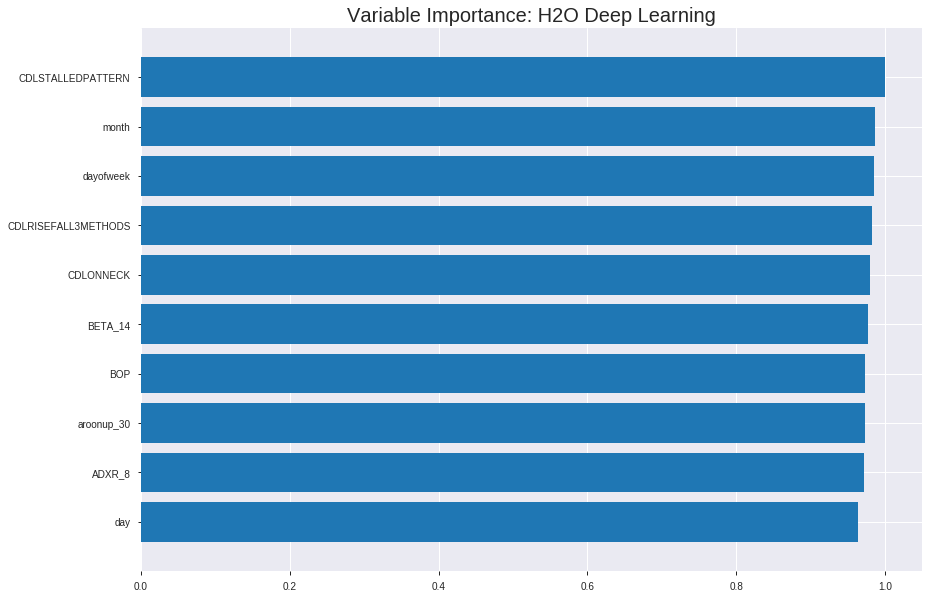

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023758_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.29678728203310467
RMSE: 0.5447818664686855
LogLoss: 1.0071600076277252
Mean Per-Class Error: 0.38620579267697575
AUC: 0.6291289122431691
pr_auc: 0.6435954201185515
Gini: 0.25825782448633827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00014144863283298303: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    851   1        (851.0/851.0)
1      0    903   0        (0.0/903.0)
Total  0    1754  0.4852   (851.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000141449  0.679714  399
max f2                       0.000141449  0.841409  399
max f0point5                 0.746856     0.619413  127
max accuracy                 0.830592     0.608894  91
max precision                0.996278     0.892857  2
max recall                   0.000141449  1         399
max specificity              0.99953      0.996475  0
max absolute_mcc             0.830592     0.240445  91
max min_per_class_accuracy   0.671886     0.587544  159
max mean_per_class_accuracy  0.830592     0.613794  91

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 60.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.997365           1.61868   1.61868            0.833333         0.999039   0.833333                    0.999039            0.0166113       0.0166113                  61.8678   61.8678
    2        0.0205245                   0.99498            1.8345    1.72659            0.944444         0.99604    0.888889                    0.99754             0.0188261       0.0354374                  83.4502   72.659
    3        0.0302166                   0.992075           1.37112   1.61257            0.705882         0.993333   0.830189                    0.99619             0.013289        0.0487265                  37.1116   61.257
    4        0.0404789                   0.989195           1.40285   1.5594             0.722222         0.990905   0.802817                    0.99485             0.0143965       0.0631229                  40.2855   55.9403
    5        0.050171                    0.986351           1.25686   1.50096            0.647059         0.987257   0.772727                    0.993383            0.0121816       0.0753045                  25.6856   50.0956
    6        0.100342                    0.972273           1.50096   1.50096            0.772727         0.980073   0.772727                    0.986728            0.0753045       0.150609                   50.0956   50.0956
    7        0.149943                    0.950883           1.36192   1.45496            0.701149         0.962932   0.749049                    0.978857            0.0675526       0.218162                   36.1923   45.4964
    8        0.200114                    0.930207           1.23608   1.40009            0.636364         0.940475   0.720798                    0.969234            0.0620155       0.280177                   23.6082   40.0088
    9        0.299886                    0.863412           1.22095   1.34049            0.628571         0.90003    0.690114                    0.94621             0.121816        0.401993                   22.0946   34.0487
    10       0.400228                    0.777659           0.982244  1.25067            0.505682         0.817358   0.643875                    0.913905            0.0985604       0.500554                   -1.77565  25.0671
    11       0.5                         0.675363           0.843563  1.16944            0.434286         0.727111   0.602052                    0.876631            0.0841639       0.584718                   -15.6437  16.9435
    12       0.599772                    0.567208           0.887961  1.12261            0.457143         0.623209   0.577947                    0.834475            0.0885936       0.673311                   -11.2039  12.2612
    13       0.700114                    0.422895           0.816697  1.07877            0.420455         0.495195   0.555375                    0.785848            0.0819491       0.75526                    -18.3303  7.87675
    14       0.799886                    0.271607           0.965657  1.06466            0.497143         0.335462   0.548111                    0.72967             0.0963455       0.851606                   -3.43427  6.46589
    15       0.899658                    0.083024           0.721468  1.0266             0.371429         0.178606   0.528517                    0.668557            0.0719823       0.923588                   -27.8532  2.65991
    16       1                           3.56536e-07        0.761515  1                  0.392045         0.0213431  0.514823                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.323794020680324
RMSE: 0.5690290156752325
LogLoss: 1.1825891860576347
Mean Per-Class Error: 0.44193383492276483
AUC: 0.5501190076835833
pr_auc: 0.5700077206327124
Gini: 0.1002380153671667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.72688436061539e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       7.72688e-05  0.701164  399
max f2                       7.72688e-05  0.854351  399
max f0point5                 0.467069     0.598377  237
max accuracy                 0.467069     0.563745  237
max precision                0.912386     0.654321  50
max recall                   7.72688e-05  1         399
max specificity              0.99973      0.995671  0
max absolute_mcc             0.564561     0.115919  203
max min_per_class_accuracy   0.60721      0.549815  190
max mean_per_class_accuracy  0.564561     0.558066  203

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 56.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.998828           0.617466  0.617466           0.333333         0.99934    0.333333                    0.99934             0.00738007      0.00738007                 -38.2534   -38.2534
    2        0.0219124                   0.996419           1.11144   0.841999           0.6              0.997837   0.454545                    0.998657            0.0110701       0.0184502                  11.1439    -15.8001
    3        0.0318725                   0.992177           0.740959  0.810424           0.4              0.992822   0.4375                      0.996833            0.00738007      0.0258303                  -25.9041   -18.9576
    4        0.0418327                   0.990805           1.11144   0.882095           0.6              0.991351   0.47619                     0.995528            0.0110701       0.0369004                  11.1439    -11.7905
    5        0.0517928                   0.985025           0.37048   0.783707           0.2              0.986342   0.423077                    0.993762            0.00369004      0.0405904                  -62.952    -21.6293
    6        0.101594                    0.960927           1.40782   1.08965            0.76             0.973522   0.588235                    0.98384             0.0701107       0.110701                   40.7823    8.96462
    7        0.151394                    0.923451           1.33373   1.16994            0.72             0.938441   0.631579                    0.968906            0.0664207       0.177122                   33.3727    16.9936
    8        0.201195                    0.887078           1.11144   1.15546            0.6              0.901493   0.623762                    0.95222             0.0553506       0.232472                   11.1439    15.5457
    9        0.300797                    0.816791           1.07439   1.12861            0.58             0.853111   0.609272                    0.919402            0.107011        0.339483                   7.43911    12.8614
    10       0.400398                    0.722513           1.0003    1.09669            0.54             0.771741   0.59204                     0.882671            0.099631        0.439114                   0.0295203  9.66937
    11       0.5                         0.603986           1.11144   1.09963            0.6              0.667657   0.593625                    0.839839            0.110701        0.549815                   11.1439    9.9631
    12       0.599602                    0.469849           1.0003    1.08313            0.54             0.536422   0.584718                    0.789438            0.099631        0.649446                   0.0295203  8.313
    13       0.699203                    0.355657           0.592768  1.01328            0.32             0.413949   0.547009                    0.735949            0.0590406       0.708487                   -40.7232   1.32778
    14       0.798805                    0.220602           1.03734   1.01628            0.56             0.285725   0.548628                    0.679812            0.103321        0.811808                   3.73432    1.62785
    15       0.898406                    0.0833897          0.815055  0.99397            0.44             0.149255   0.536585                    0.620992            0.0811808       0.892989                   -18.4945   -0.603006
    16       1                           4.81412e-16        1.05332   1                  0.568627         0.0224359  0.5398


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:38:00  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:38:06  6.156 sec   2897 obs/sec      10        1             17540      0.544782         1.00716             -0.188193      0.629129        0.643595           1.61868          0.485177                         0.569029           1.18259               -0.303452        0.550119          0.570008             0.617466           0.460159
    2019-09-03 02:38:11  11.873 sec  2999 obs/sec      20        2             35080      0.52009          0.928017            -0.0829251     0.665797        0.678364           1.51077          0.431015                         0.581723           1.28596               -0.362254        0.550454          0.56966              0.926199           0.460159
    2019-09-03 02:38:17  17.434 sec  3063 obs/sec      30        3             52620      0.485667         0.797227            0.0556799      0.723729        0.708127           1.8345           0.336944                         0.585356           1.29893               -0.379324        0.553585          0.566518             1.54367            0.454183
    2019-09-03 02:38:22  22.763 sec  3128 obs/sec      40        4             70160      0.462099         0.756529            0.145108       0.763945        0.744757           1.72659          0.294755                         0.591696           1.37308               -0.409367        0.553178          0.574538             1.23493            0.460159
    2019-09-03 02:38:27  27.981 sec  3181 obs/sec      50        5             87700      0.445961         0.695877            0.203774       0.786735        0.763965           1.61868          0.27081                          0.601715           1.46843               -0.457499        0.547947          0.577771             1.23493            0.460159
    2019-09-03 02:38:33  33.117 sec  3226 obs/sec      60        6             105240     0.43636          0.684922            0.237689       0.812843        0.783751           1.8345           0.251995                         0.612766           1.53174               -0.511524        0.549536          0.571718             0.926199           0.460159
    2019-09-03 02:38:33  33.210 sec  3225 obs/sec      60        6             105240     0.544782         1.00716             -0.188193      0.629129        0.643595           1.61868          0.485177                         0.569029           1.18259               -0.303452        0.550119          0.570008             0.617466           0.460159

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN     1.0                    1.0                  0.021208603019933707
month                 0.9862021803855896     0.9862021803855896   0.02091597054119102
dayofweek             0.9855442047119141     0.9855442047119141   0.020902015796331264
CDLRISEFALL3METHODS   0.9820082783699036     0.9820082783699036   0.020827023738235837
CDLONNECK             0.980111837387085      0.980111837387085    0.020786802874280502
---                   ---                    ---                  ---
CDLTHRUSTING          0.9092110991477966     0.9092110991477966   0.019283097263143204
HT_PHASOR_quadrature  0.9056494235992432     0.9056494235992432   0.019207559100348128
BETA_8                0.8984127640724182     0.8984127640724182   0.019054079661253276
CDLLADDERBOTTOM       0.8842488527297974     0.8842488527297974   0.018753682888378094
BETA_24               0.8695319294929504     0.8695319294929504   0.018441557505772973


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.7127659574468084)

('auc', 0.5028812908182866)

('logloss', 1.3650529410829124)

('mean_per_class_error', 0.4516263285952107)

('rmse', 0.5963120723626649)

('mse', 0.3555880876454561)

deeplearning prediction progress: |███████████████████████████████████████| 100%


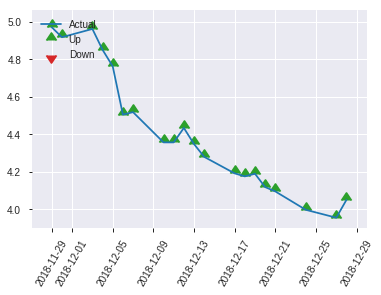


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3555880876454561
RMSE: 0.5963120723626649
LogLoss: 1.3650529410829124
Mean Per-Class Error: 0.4516263285952107
AUC: 0.5028812908182866
pr_auc: 0.5161343178742717
Gini: 0.005762581636573172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.010928941401060488: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    105  0.9211   (105.0/114.0)
1      3    134  0.0219   (3.0/137.0)
Total  12   239  0.4303   (108.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0109289    0.712766  238
max f2                       1.97426e-07  0.857322  250
max f0point5                 0.310135     0.613464  195
max accuracy                 0.310135     0.573705  195
max precision                0.999752     1         0
max recall                   1.97426e-07  1         250
max specificity              0.999752     1         0
max absolute_mcc             0.975871     0.162404  36
max min_per_class_accuracy   0.736919     0.508772  125
max mean_per_class_accuracy  0.310135     0.548374  195

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 63.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.9992             0.610706  0.610706           0.333333         0.999545   0.333333                    0.999545            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.999037           0         0.305353           0                0.99912    0.166667                    0.999333            0               0.00729927                 -100      -69.4647
    3        0.0318725                   0.998249           0.916058  0.458029           0.5              0.998684   0.25                        0.999171            0.00729927      0.0145985                  -8.39416  -54.1971
    4        0.0438247                   0.997136           1.83212   0.83278            1                0.997689   0.454545                    0.998767            0.0218978       0.0364964                  83.2117   -16.722
    5        0.0517928                   0.994519           0.916058  0.845592           0.5              0.995334   0.461538                    0.998238            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.983242           0.422796  0.634194           0.230769         0.988804   0.346154                    0.993521            0.0218978       0.0656934                  -57.7204  -36.5806
    7        0.151394                    0.974767           0.763382  0.67499            0.416667         0.978456   0.368421                    0.988764            0.0364964       0.10219                    -23.6618  -32.501
    8        0.203187                    0.956003           1.12746   0.790325           0.615385         0.965118   0.431373                    0.982736            0.0583942       0.160584                   12.7456   -20.9675
    9        0.302789                    0.913143           1.24584   0.940165           0.68             0.933304   0.513158                    0.966476            0.124088        0.284672                   24.5839   -5.98348
    10       0.40239                     0.845677           1.17255   0.997687           0.64             0.884567   0.544554                    0.946201            0.116788        0.40146                    17.2555   -0.231264
    11       0.501992                    0.736919           1.09927   1.01784            0.6              0.790619   0.555556                    0.915332            0.109489        0.510949                   9.92701   1.78427
    12       0.601594                    0.635743           1.09927   1.03132            0.6              0.686699   0.562914                    0.877479            0.109489        0.620438                   9.92701   3.1324
    13       0.701195                    0.479014           1.02599   1.03057            0.56             0.551685   0.5625                      0.831201            0.10219         0.722628                   2.59854   3.05657
    14       0.800797                    0.260934           1.09927   1.03911            0.6              0.352797   0.567164                    0.771698            0.109489        0.832117                   9.92701   3.9111
    15       0.900398                    0.0470525          0.952701  1.02955            0.52             0.136129   0.561947                    0.701392            0.0948905       0.927007                   -4.72993  2.95524
    16       1                           1.97426e-07        0.732847  1                  0.4              0.0119462  0.545817            

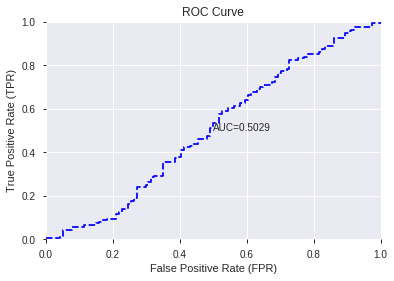

This function is available for GLM models only


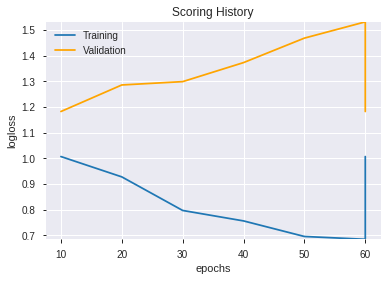

--2019-09-03 02:45:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023758_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023758_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'month',
 'dayofweek',
 'CDLRISEFALL3METHODS',
 'CDLONNECK',
 'BETA_14',
 'BOP',
 'aroonup_30',
 'ADXR_8',
 'day',
 'BETA_30',
 'STOCHRSI_fastk',
 'CDLMORNINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'days_in_month',
 'CORREL_20',
 'DX_8',
 'ADXR_12',
 'weekday',
 'CORREL_30',
 'weekday_name',
 'SAREXT',
 'aroonup_8',
 'CDLUNIQUE3RIVER',
 'ADXR_14',
 'aroonup_24',
 'CDLUPSIDEGAP2CROWS',
 'BETA_20',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'aroondown_20',
 'aroondown_30',
 'CORREL_24',
 'AROONOSC_24',
 'CDLHIKKAKEMOD',
 'CDLPIERCING',
 'aroondown_24',
 'TAN',
 'ATR_30',
 'weekofyear',
 'HT_DCPERIOD',
 'AROONOSC_20',
 'CDLLONGLEGGEDDOJI',
 'CORREL_14',
 'HT_TRENDMODE',
 'CDLTHRUSTING',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'CDLLADDERBOTTOM',
 'BETA_24']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024518_model_1  0.403317  0.69337                   0.5  0.500111  0.250111

variable  relative_importance  scaled_importance  percentage
0              dayofweek             0.008612           1.000000    0.061257
1                weekday             0.008608           0.999588    0.061231
2                 BETA_8             0.008372           0.972114    0.059548
3   HT_PHASOR_quadrature             0.008097           0.940235    0.057596
4             aroonup_30             0.006542           0.759680    0.046535
5      CDLSTALLEDPATTERN             0.006193           0.719098    0.044050
6                    BOP             0.005924           0.687888    0.042138
7                BETA_14             0.005281           0.613255    0.037566
8           CDLTHRUSTING             0.005107           0.592997    0.036325
9       CDLSTICKSANDWICH             0.004991           0.579564    0.035502
10    CDLMORNINGDOJISTAR             0.004728           0.549019    0.033631
11                ADXR_8             0.004725           0.548705    0.033612
12          aroondown_20             0.004704           0.546265    0.033462
13               BETA_24             0.004563           0.529835    0.032456
14        STOCHRSI_fastk             0.004338           0.503769    0.030859
15            aroonup_24             0.004230           0.491196    0.030089
16   CDLRISEFALL3METHODS             0.003289           0.381941    0.023396
17             CORREL_20             0.002858           0.331908    0.020332
18          aroondown_24             0.002741           0.318298    0.019498
19          aroondown_30             0.002664           0.309368    0.018951
20               BETA_20             0.002538           0.294761    0.018056
21           AROONOSC_20             0.002253           0.261626    0.016026
22           CDLPIERCING             0.002153           0.250004    0.015314
23                   TAN             0.001968           0.228559    0.014001
24            weekofyear             0.001798           0.208734    0.012786
25         days_in_month             0.001778           0.206503    0.012650
26             CDLONNECK             0.001773           0.205863    0.012610
27             CORREL_30             0.001751           0.203334    0.012456
28        CDLRICKSHAWMAN             0.001585           0.184073    0.011276
29             CORREL_24             0.001474           0.171118    0.010482
30                 month             0.001437           0.166887    0.010223
31         CDLHIKKAKEMOD             0.001436           0.166726    0.010213
32                SAREXT             0.001359           0.157758    0.009664
33             CORREL_14             0.001270           0.147459    0.009033
34             aroonup_8             0.001065           0.123693    0.007577
35                   day             0.001042           0.121046    0.007415
36           AROONOSC_24             0.000921           0.106892    0.006548
37               ADXR_14             0.000915           0.106205    0.006506
38          HT_TRENDMODE             0.000896           0.104046    0.006374
39               BETA_30             0.000894           0.103762    0.006356
40                  DX_8             0.000819           0.095092    0.005825
41           HT_DCPERIOD             0.000707           0.082099    0.005029
42               ADXR_12             0.000554           0.064383    0.003944
43       CDLLADDERBOTTOM             0.000395           0.045868    0.002810
44          weekday_name             0.000384           0.044532    0.002728
45    CDLUPSIDEGAP2CROWS             0.000198           0.022982    0.001408
46     CDLLONGLEGGEDDOJI             0.000194           0.022573    0.001383
47               CDLDOJI             0.000184           0.021344    0.001307
48                ATR_30             0.000139           0.016109    0.000987
49       CDLUNIQUE3RIVER             0.000138           0.016002    0.000980

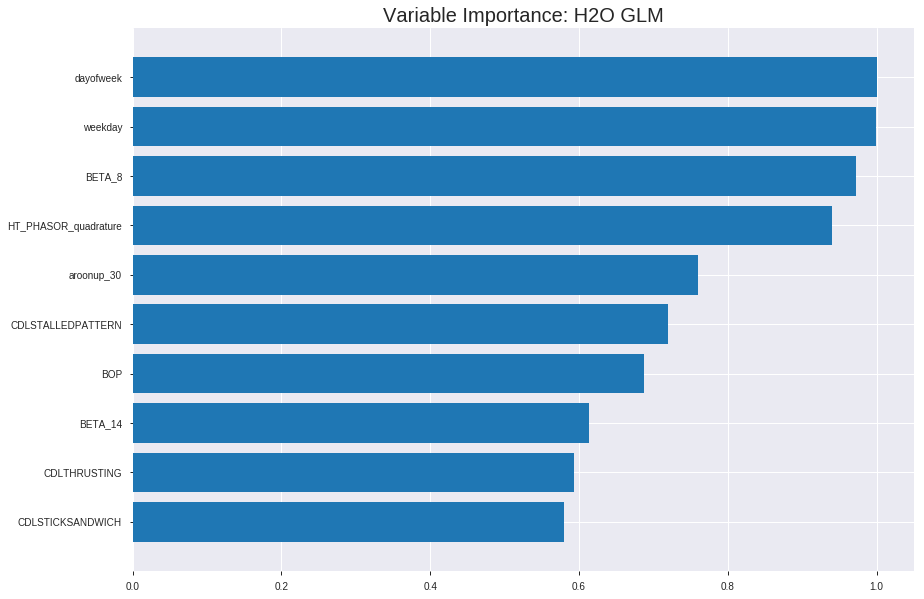

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024518_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24860137759200643
RMSE: 0.4985994159563431
LogLoss: 0.6903471965901674
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2430.0184643429493
Residual deviance: 2421.7379656383073
AIC: 2523.7379656383073
AUC: 0.5735308470394416
pr_auc: 0.5739620311387155
Gini: 0.14706169407888314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4987070904470112: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   812   0.9542   (812.0/851.0)
1      6    897   0.0066   (6.0/903.0)
Total  45   1709  0.4664   (818.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498707     0.68683   369
max f2                       0.497326     0.844411  378
max f0point5                 0.508935     0.59035   282
max accuracy                 0.511059     0.564424  256
max precision                0.5586       1         0
max recall                   0.496063     1         382
max specificity              0.5586       1         0
max absolute_mcc             0.506492     0.133714  311
max min_per_class_accuracy   0.514943     0.550388  204
max mean_per_class_accuracy  0.511922     0.559246  244

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.535783           1.29494   1.29494            0.666667         0.541788  0.666667                    0.541788            0.013289        0.013289                   29.4943   29.4943
    2        0.0205245                   0.533004           1.61868   1.45681            0.833333         0.53418   0.75                        0.537984            0.0166113       0.0299003                  61.8678   45.6811
    3        0.0302166                   0.531735           1.02834   1.31938            0.529412         0.532402  0.679245                    0.536193            0.00996678      0.0398671                  2.83369   31.9376
    4        0.0404789                   0.530379           1.51077   1.3679             0.777778         0.530901  0.704225                    0.534852            0.0155039       0.055371                   51.0767   36.7897
    5        0.050171                    0.528734           1.1426    1.32437            0.588235         0.529626  0.681818                    0.533842            0.0110742       0.0664452                  14.2597   32.4373
    6        0.100342                    0.525371           1.03743   1.1809             0.534091         0.52686   0.607955                    0.530351            0.0520487       0.118494                   3.74258   18.09
    7        0.149943                    0.523163           1.13866   1.16693            0.586207         0.524172  0.60076                     0.528307            0.0564784       0.174972                   13.8657   16.6926
    8        0.200114                    0.521533           1.01535   1.12892            0.522727         0.522295  0.581197                    0.5268              0.0509413       0.225914                   1.53529   12.8924
    9        0.299886                    0.518777           1.05445   1.10415            0.542857         0.52007   0.568441                    0.524561            0.105205        0.331118                   5.44534   10.4148
    10       0.400228                    0.516786           1.10364   1.10402            0.568182         0.517784  0.568376                    0.522862            0.110742        0.44186                    10.3644   10.4022
    11       0.5                         0.514932           1.08775   1.10078            0.56             0.51578   0.566705                    0.521448            0.108527        0.550388                   8.77519   10.0775
    12       0.599772                    0.512801           1.04335   1.09122            0.537143         0.51381   0.561787                    0.520178            0.104097        0.654485                   4.33539   9.12232
    13       0.700114                    0.510692           0.960171  1.07244            0.494318         0.5117    0.552117                    0.518963            0.0963455       0.750831                   -3.98294  7.24404
    14       0.799886                    0.507906           0.921259  1.05358            0.474286         0.50933   0.542409                    0.517761            0.0919158       0.842746                   -7.87407  5.35832
    15       0.899658                    0.504259           0.89906   1.03645            0.462857         0.506304  0.533587                    0.516491            0.089701        0.932447                   -10.094   3.64466
    16       1                           0.472454           0.673223  1                  0.346591         0.499874  0.514823                    0.514823           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2491977112201271
RMSE: 0.4991970665179505
LogLoss: 0.6915399152564179
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 693.9887622709523
Residual deviance: 694.3060749174435
AIC: 796.3060749174435
AUC: 0.4942253318637082
pr_auc: 0.5421482349905202
Gini: -0.011549336272583588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.462413052323826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462413     0.701164  399
max f2                       0.462413     0.854351  399
max f0point5                 0.462413     0.594559  399
max accuracy                 0.462413     0.539841  399
max precision                0.557794     1         0
max recall                   0.462413     1         399
max specificity              0.557794     1         0
max absolute_mcc             0.500678     0.10783   385
max min_per_class_accuracy   0.516739     0.505535  194
max mean_per_class_accuracy  0.514229     0.519281  238

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.546561           1.54367   1.54367            0.833333         0.55206   0.833333                    0.55206             0.0184502       0.0184502                  54.3665   54.3665
    2        0.0219124                   0.540267           1.11144   1.3472             0.6              0.542774  0.727273                    0.547839            0.0110701       0.0295203                  11.1439   34.7199
    3        0.0318725                   0.535105           1.11144   1.27352            0.6              0.536539  0.6875                      0.544308            0.0110701       0.0405904                  11.1439   27.3524
    4        0.0418327                   0.532923           0.37048   1.05851            0.2              0.533331  0.571429                    0.541694            0.00369004      0.0442804                  -62.952   5.85134
    5        0.0517928                   0.531601           1.11144   1.06869            0.6              0.531988  0.576923                    0.539828            0.0110701       0.0553506                  11.1439   6.86915
    6        0.101594                    0.526689           0.740959  0.908038           0.4              0.528755  0.490196                    0.5344              0.0369004       0.0922509                  -25.9041  -9.19615
    7        0.151394                    0.525049           1.03734   0.950573           0.56             0.525994  0.513158                    0.531635            0.0516605       0.143911                   3.73432   -4.94271
    8        0.201195                    0.523493           0.963247  0.95371            0.52             0.524253  0.514851                    0.529808            0.0479705       0.191882                   -3.67528  -4.62899
    9        0.300797                    0.520381           1.07439   0.993671           0.58             0.522095  0.536424                    0.527254            0.107011        0.298893                   7.43911   -0.632927
    10       0.400398                    0.518364           0.926199  0.976887           0.5              0.519292  0.527363                    0.525273            0.0922509       0.391144                   -7.38007  -2.31132
    11       0.5                         0.516721           1.14849   1.01107            0.62             0.517524  0.545817                    0.52373             0.114391        0.505535                   14.8487   1.10701
    12       0.599602                    0.514448           1.07439   1.02159            0.58             0.515701  0.551495                    0.522396            0.107011        0.612546                   7.43911   2.15886
    13       0.699203                    0.511842           0.926199  1.008              0.5              0.51329   0.54416                     0.521099            0.0922509       0.704797                   -7.38007  0.800034
    14       0.798805                    0.509682           0.889151  0.993181           0.48             0.510752  0.53616                     0.519809            0.0885609       0.793358                   -11.0849  -0.681875
    15       0.898406                    0.506187           0.963247  0.989863           0.52             0.508128  0.534368                    0.518514            0.095941        0.889299                   -3.67528  -1.01374
    16       1                           0.462413           1.08965   1                  0.588235         0.500378  0.539841                    0.51667


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:45:19  0.000 sec   2            3.2       51            1.38069           1.38308
    2019-09-03 02:45:19  0.014 sec   4            2         51            1.37851           1.38367
    2019-09-03 02:45:19  0.034 sec   6            1.2       51            1.37569           1.38475
    2019-09-03 02:45:19  0.061 sec   8            0.77      51            1.37229           1.38661
    2019-09-03 02:45:19  0.087 sec   10           0.48      51            1.3685            1.38952

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7061855670103092)

('auc', 0.4033166858752721)

('logloss', 0.6933703321598176)

('mean_per_class_error', 0.49490971955436036)

('rmse', 0.5001107235105676)

('mse', 0.25011073577026344)

glm prediction progress: |████████████████████████████████████████████████| 100%


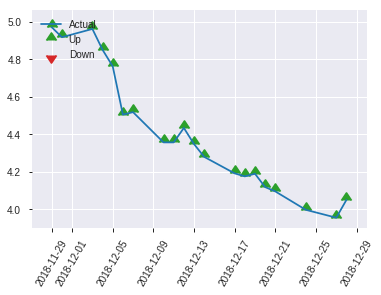


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25011073577026344
RMSE: 0.5001107235105676
LogLoss: 0.6933703321598176
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.81644986094483
Residual deviance: 348.07190674422844
AIC: 450.07190674422844
AUC: 0.4033166858752721
pr_auc: 0.47720567617722826
Gini: -0.19336662824945583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48323758697890173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483238     0.706186  250
max f2                       0.483238     0.857322  250
max f0point5                 0.483238     0.600351  250
max accuracy                 0.500828     0.545817  240
max precision                0.533159     1         0
max recall                   0.483238     1         250
max specificity              0.533159     1         0
max absolute_mcc             0.515815     0.217844  108
max min_per_class_accuracy   0.514931     0.416058  119
max mean_per_class_accuracy  0.529589     0.50509   7

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.53152            0.610706  0.610706           0.333333         0.532361  0.333333                    0.532361            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.530039           1.22141   0.916058           0.666667         0.530762  0.5                         0.531562            0.0145985       0.0218978                  22.1411   -8.39416
    3        0.0318725                   0.52949            1.83212   1.14507            1                0.529754  0.625                       0.53111             0.0145985       0.0364964                  83.2117   14.5073
    4        0.0438247                   0.52805            0         0.83278            0                0.528591  0.454545                    0.530423            0               0.0364964                  -100      -16.722
    5        0.0517928                   0.52628            0.916058  0.845592           0.5              0.526823  0.461538                    0.529869            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.524372           0.563728  0.70466            0.307692         0.525212  0.384615                    0.52754             0.0291971       0.0729927                  -43.6272  -29.534
    7        0.151394                    0.522464           0.916058  0.771418           0.5              0.52352   0.421053                    0.526271            0.0437956       0.116788                   -8.39416  -22.8582
    8        0.203187                    0.521026           0.986524  0.826249           0.538462         0.521587  0.45098                     0.525077            0.0510949       0.167883                   -1.34756  -17.3751
    9        0.302789                    0.518594           0.732847  0.795524           0.4              0.519768  0.434211                    0.523331            0.0729927       0.240876                   -26.7153  -20.4476
    10       0.40239                     0.516358           0.879416  0.81629            0.48             0.517518  0.445545                    0.521892            0.0875912       0.328467                   -12.0584  -18.371
    11       0.501992                    0.514522           1.02599   0.857896           0.56             0.515486  0.468254                    0.520621            0.10219         0.430657                   2.59854   -14.2104
    12       0.601594                    0.512586           1.17255   0.909992           0.64             0.513555  0.496689                    0.519451            0.116788        0.547445                   17.2555   -9.00082
    13       0.701195                    0.510739           1.02599   0.926468           0.56             0.511533  0.505682                    0.518326            0.10219         0.649635                   2.59854   -7.35319
    14       0.800797                    0.508509           1.24584   0.966191           0.68             0.509362  0.527363                    0.517211            0.124088        0.773723                   24.5839   -3.38091
    15       0.900398                    0.504917           1.17255   0.989019           0.64             0.506659  0.539823                    0.516044            0.116788        0.890511                   17.2555   -1.09812
    16       1                           0.483238           1.09927   1                  0.6              0.500235  0.545817                    0.5144

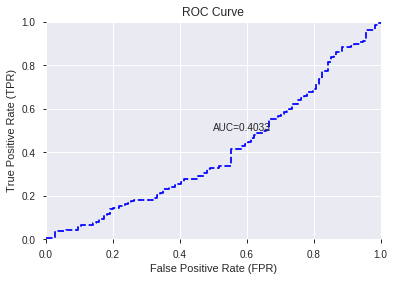

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


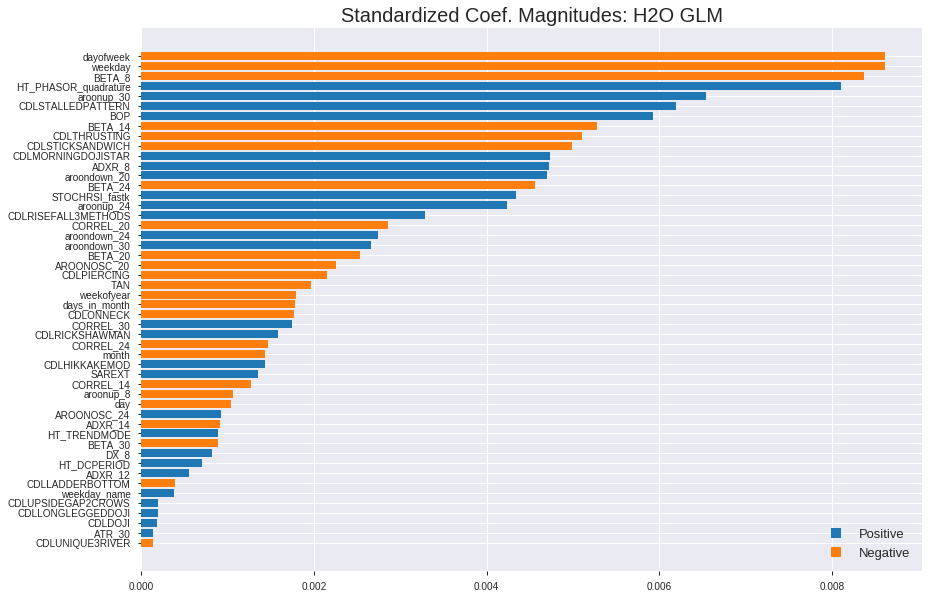

'log_likelihood'
--2019-09-03 02:45:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024518_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024518_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['dayofweek',
 'weekday',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'CDLSTALLEDPATTERN',
 'BOP',
 'BETA_14',
 'CDLTHRUSTING',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'ADXR_8',
 'aroondown_20',
 'BETA_24',
 'STOCHRSI_fastk',
 'aroonup_24',
 'CDLRISEFALL3METHODS',
 'CORREL_20',
 'aroondown_24',
 'aroondown_30',
 'BETA_20',
 'AROONOSC_20',
 'CDLPIERCING',
 'TAN',
 'weekofyear',
 'days_in_month',
 'CDLONNECK',
 'CORREL_30',
 'CDLRICKSHAWMAN',
 'CORREL_24',
 'month',
 'CDLHIKKAKEMOD',
 'SAREXT',
 'CORREL_14',
 'aroonup_8',
 'day',
 'AROONOSC_24',
 'ADXR_14',
 'HT_TRENDMODE',
 'BETA_30',
 'DX_8',
 'HT_DCPERIOD',
 'ADXR_12',
 'CDLLADDERBOTTOM',
 'weekday_name',
 'CDLUPSIDEGAP2CROWS',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'ATR_30',
 'CDLUNIQUE3RIVER']

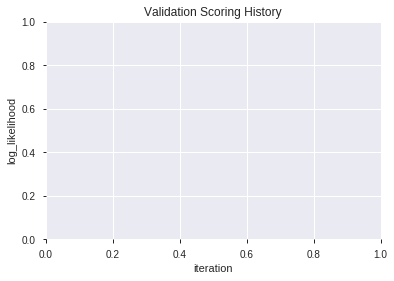

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190903_024532  0.505506  0.710802              0.500000  0.507947  0.258010
1  XGBoost_grid_1_AutoML_20190903_024532_model_3  0.489627  0.708143              0.475125  0.507005  0.257054
2  XGBoost_grid_1_AutoML_20190903_024532_model_5  0.486042  0.735351              0.500000  0.518324  0.268660
3               XGBoost_2_AutoML_20190903_024532  0.465104  0.708143              0.486106  0.507080  0.257130
4  XGBoost_grid_1_AutoML_20190903_024532_model_2  0.455372  0.710526              0.486106  0.508224  0.258292
5  XGBoost_grid_1_AutoML_20190903_024532_model_7  0.444679  0.735887              0.484633  0.519236  0.269606
6               XGBoost_3_AutoML_20190903_024532  0.441990  0.714697              0.482456  0.510258  0.260364
7  XGBoost_grid_1_AutoML_20190903_024532_model_6  0.438276  0.715792              0.484633  0.510732  0.260848
8  XGBoost_grid_1_AutoML_20190903_024532_model_4  0.432386  0.717728              0.490492  0.511806  0.261946
9  XGBoost_grid_1_AutoML_20190903_024532_model_1  0.426367  0.728467              0.500000  0.516467  0.266738

variable  relative_importance  scaled_importance  percentage
0                   DX_8           414.258087           1.000000    0.055710
1   HT_PHASOR_quadrature           357.827118           0.863778    0.048121
2                    BOP           325.316986           0.785300    0.043749
3                 ADXR_8           323.314331           0.780466    0.043480
4                 ATR_30           320.640228           0.774011    0.043120
5              CORREL_24           306.069214           0.738837    0.041160
6              CORREL_20           303.540070           0.732732    0.040820
7              CORREL_30           297.142212           0.717288    0.039960
8                    TAN           293.795868           0.709210    0.039510
9                 SAREXT           288.414429           0.696219    0.038786
10               BETA_14           267.428406           0.645560    0.035964
11                BETA_8           263.998932           0.637281    0.035503
12           HT_DCPERIOD           252.845932           0.610358    0.034003
13               ADXR_14           245.473862           0.592563    0.033011
14            aroonup_30           243.880402           0.588716    0.032797
15           AROONOSC_24           236.862640           0.571776    0.031853
16        STOCHRSI_fastk           222.158615           0.536281    0.029876
17               BETA_24           221.172028           0.533899    0.029743
18               BETA_30           219.508133           0.529883    0.029520
19               ADXR_12           188.512527           0.455061    0.025351
20             CORREL_14           183.532639           0.443039    0.024682
21               BETA_20           179.835556           0.434115    0.024184
22             dayofweek           177.798126           0.429197    0.023910
23             aroonup_8           175.531967           0.423726    0.023606
24           AROONOSC_20           157.289398           0.379689    0.021152
25                   day           147.805649           0.356796    0.019877
26          aroondown_30           138.120331           0.333416    0.018575
27            weekofyear           128.771851           0.310849    0.017317
28            aroonup_24           119.287102           0.287954    0.016042
29          aroondown_20           113.366135           0.273661    0.015246
30          aroondown_24           106.321938           0.256656    0.014298
31          weekday_name            56.590401           0.136607    0.007610
32                 month            54.926094           0.132589    0.007386
33               weekday            42.511971           0.102622    0.005717
34         days_in_month            30.446423           0.073496    0.004094
35          HT_TRENDMODE            24.039848           0.058031    0.003233
36               CDLDOJI             3.931227           0.009490    0.000529
37        CDLRICKSHAWMAN             3.747034           0.009045    0.000504

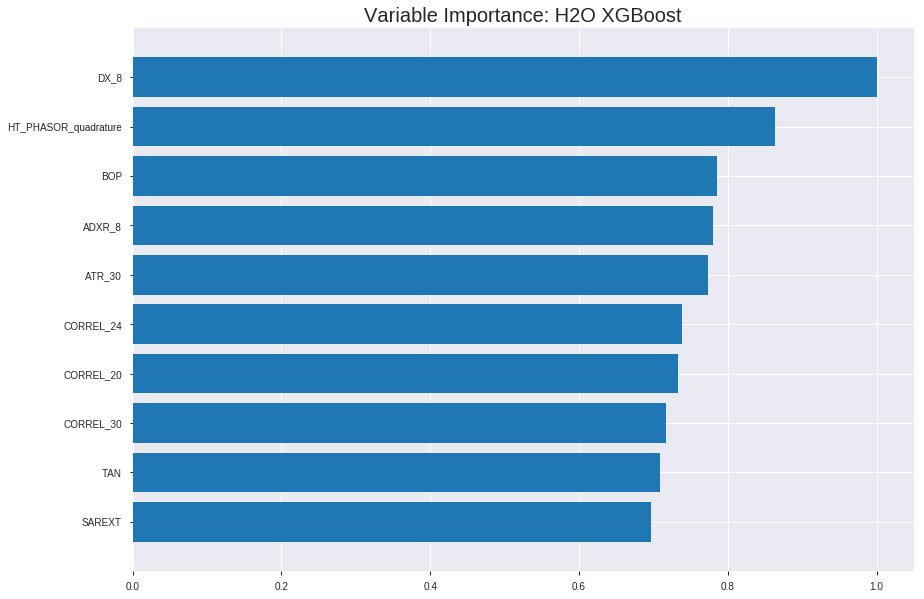

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190903_024532


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15656721276094807
RMSE: 0.3956857500099644
LogLoss: 0.4982131629025335
Mean Per-Class Error: 0.10060276946020119
AUC: 0.9655086257715175
pr_auc: 0.9687101392555794
Gini: 0.931017251543035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5008130818605423: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      743  108  0.1269   (108.0/851.0)
1      71   832  0.0786   (71.0/903.0)
Total  814  940  0.1021   (179.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.500813     0.902876  206
max f2                       0.458206     0.927616  238
max f0point5                 0.567494     0.928438  157
max accuracy                 0.540456     0.897948  178
max precision                0.823318     1         0
max recall                   0.367462     1         309
max specificity              0.823318     1         0
max absolute_mcc             0.540456     0.800645  178
max min_per_class_accuracy   0.518456     0.893688  194
max mean_per_class_accuracy  0.540456     0.899397  178

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.777284           1.94241    1.94241            1                0.790264  1                           0.790264            0.0199336       0.0199336                  94.2414   94.2414
    2        0.0205245                   0.761827           1.94241    1.94241            1                0.7697    1                           0.779982            0.0199336       0.0398671                  94.2414   94.2414
    3        0.0302166                   0.747552           1.94241    1.94241            1                0.753438  1                           0.771468            0.0188261       0.0586932                  94.2414   94.2414
    4        0.0404789                   0.737731           1.94241    1.94241            1                0.742723  1                           0.76418             0.0199336       0.0786268                  94.2414   94.2414
    5        0.050171                    0.729414           1.94241    1.94241            1                0.733462  1                           0.758246            0.0188261       0.0974529                  94.2414   94.2414
    6        0.100342                    0.699435           1.94241    1.94241            1                0.714054  1                           0.73615             0.0974529       0.194906                   94.2414   94.2414
    7        0.149943                    0.678332           1.94241    1.94241            1                0.688865  1                           0.720508            0.0963455       0.291251                   94.2414   94.2414
    8        0.200114                    0.655372           1.92034    1.93688            0.988636         0.667131  0.997151                    0.707126            0.0963455       0.387597                   92.0341   93.688
    9        0.299886                    0.612035           1.88692    1.92026            0.971429         0.632211  0.988593                    0.682202            0.188261        0.575858                   88.6917   92.0257
    10       0.400228                    0.569491           1.83205    1.89814            0.943182         0.591436  0.977208                    0.659446            0.183832        0.75969                    83.205    89.8143
    11       0.5                         0.52188            1.25424    1.76966            0.645714         0.546575  0.91106                     0.636923            0.125138        0.884828                   25.4245   76.9657
    12       0.599772                    0.472298           0.710369   1.59344            0.365714         0.495052  0.820342                    0.613323            0.0708749       0.955703                   -28.9631  59.3444
    13       0.700114                    0.426021           0.275911   1.40461            0.142045         0.447343  0.723127                    0.589534            0.0276855       0.983389                   -72.4089  40.4612
    14       0.799886                    0.377251           0.155393   1.24879            0.08             0.402234  0.642908                    0.566172            0.0155039       0.998893                   -84.4607  24.8794
    15       0.899658                    0.314068           0.0110995  1.11153            0.00571429       0.34872   0.572243                    0.542056            0.00110742      1                          -98.89    11.1534
    16       1                           0.167898           0          1                  0                0.27064   0.514823                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2536815914217108
RMSE: 0.5036681361985398
LogLoss: 0.7010393128206058
Mean Per-Class Error: 0.4597450519959745
AUC: 0.5337933898819508
pr_auc: 0.5724460172062071
Gini: 0.0675867797639016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.288480669260025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    226  0.9784   (226.0/231.0)
1      0    271  0        (0.0/271.0)
Total  5    497  0.4502   (226.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.288481     0.705729  394
max f2                       0.288481     0.857052  394
max f0point5                 0.288481     0.599823  394
max accuracy                 0.301895     0.549801  386
max precision                0.742313     1         0
max recall                   0.288481     1         394
max specificity              0.742313     1         0
max absolute_mcc             0.288481     0.108639  394
max min_per_class_accuracy   0.520736     0.536797  197
max mean_per_class_accuracy  0.522054     0.540255  195

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 51.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.720564           1.23493   1.23493            0.666667         0.734296  0.666667                    0.734296            0.0147601       0.0147601                  23.4932   23.4932
    2        0.0219124                   0.703662           1.11144   1.1788             0.6              0.710134  0.636364                    0.723314            0.0110701       0.0258303                  11.1439   17.8799
    3        0.0318725                   0.688627           1.48192   1.27352            0.8              0.694992  0.6875                      0.714463            0.0147601       0.0405904                  48.1919   27.3524
    4        0.0418327                   0.685057           0.740959  1.14672            0.4              0.686428  0.619048                    0.707788            0.00738007      0.0479705                  -25.9041  14.6723
    5        0.0517928                   0.676497           1.8524    1.28243            1                0.680639  0.692308                    0.702567            0.0184502       0.0664207                  85.2399   28.243
    6        0.101594                    0.642717           0.889151  1.08965            0.48             0.655668  0.588235                    0.679577            0.0442804       0.110701                   -11.0849  8.96462
    7        0.151394                    0.623294           1.11144   1.09681            0.6              0.631839  0.592105                    0.663874            0.0553506       0.166052                   11.1439   9.68149
    8        0.201195                    0.606984           1.25963   1.13712            0.68             0.613697  0.613861                    0.651454            0.0627306       0.228782                   25.9631   13.7116
    9        0.300797                    0.577882           0.926199  1.06728            0.5              0.591486  0.576159                    0.631597            0.0922509       0.321033                   -7.38007  6.7276
    10       0.400398                    0.552966           1.07439   1.06905            0.58             0.56516   0.577114                    0.61507             0.107011        0.428044                   7.43911   6.90459
    11       0.5                         0.521829           1.07439   1.07011            0.58             0.537661  0.577689                    0.59965             0.107011        0.535055                   7.43911   7.01107
    12       0.599602                    0.492628           0.740959  1.01543            0.4              0.507262  0.548173                    0.584303            0.0738007       0.608856                   -25.9041  1.54344
    13       0.699203                    0.451214           1.07439   1.02383            0.58             0.474265  0.552707                    0.568628            0.107011        0.715867                   7.43911   2.38328
    14       0.798805                    0.416558           0.963247  1.01628            0.52             0.435859  0.548628                    0.552073            0.095941        0.811808                   -3.67528  1.62785
    15       0.898406                    0.369125           0.889151  1.00218            0.48             0.393887  0.54102                     0.534536            0.0885609       0.900369                   -11.0849  0.218457
    16       1                           0.216546           0.980682  1                  0.529412         0.324814  0.539841                    0.51323           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:45:32  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.485177                         0.5                0.693147              0.5               0                    1                  0.460159
    2019-09-03 02:45:33  0.167 sec   5                  0.485388         0.664271            0.801353        0.79849            1.8345           0.258837                         0.49967            0.692491              0.517875          0.540709             1.23493            0.454183
    2019-09-03 02:45:33  0.273 sec   10                 0.472342         0.639039            0.867829        0.870721           1.94241          0.216648                         0.499901           0.692944              0.514177          0.552406             0.926199           0.448207
    2019-09-03 02:45:33  0.378 sec   15                 0.460779         0.616987            0.890183        0.896188           1.94241          0.204105                         0.499371           0.691888              0.530031          0.588939             1.54367            0.460159
    2019-09-03 02:45:33  0.487 sec   20                 0.449497         0.595778            0.912647        0.918113           1.94241          0.172178                         0.498839           0.690809              0.536932          0.583702             1.23493            0.456175
    2019-09-03 02:45:33  0.709 sec   25                 0.439371         0.576961            0.925884        0.933376           1.94241          0.152794                         0.499937           0.692973              0.52841           0.580062             0.926199           0.452191
    2019-09-03 02:45:33  0.829 sec   30                 0.42954          0.558957            0.937249        0.943686           1.94241          0.131129                         0.501676           0.696556              0.522755          0.561958             1.23493            0.450199
    2019-09-03 02:45:33  0.937 sec   35                 0.420157         0.541921            0.947657        0.952613           1.94241          0.124857                         0.501365           0.695944              0.530527          0.576472             1.54367            0.450199
    2019-09-03 02:45:34  1.053 sec   40                 0.411752         0.526809            0.955045        0.959426           1.94241          0.115165                         0.501673           0.696643              0.534928          0.578055             1.23493            0.452191
    2019-09-03 02:45:34  1.169 sec   45                 0.403425         0.511922            0.960382        0.964337           1.94241          0.108324                         0.503078           0.699681              0.532188          0.571418             1.23493            0.450199
    2019-09-03 02:45:34  1.292 sec   50                 0.395686         0.498213            0.965509        0.96871            1.94241          0.102052                         0.503668           0.701039              0.533793          0.572446             1.23493            0.450199

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
DX_8                  414.2580871582031      1.0                   0.05570969924371111
HT_PHASOR_quadrature  357.8271179199219      0.8637782315237444    0.04812082549145247
BOP                   325.3169860839844      0.7853002661110329    0.043748841641051944
ADXR_8                323.3143310546875      0.7804659488306268    0.043479523279311844
ATR_30                320.6402282714844      0.7740107875046346    0.04311990818327119
---                   ---                    ---                   ---
weekday               42.51197052001953      0.10262194471965594   0.00571703767613678
days_in_month         30.446422576904297     0.07349626602528331   0.004094454875804316
HT_TRENDMODE          24.03984832763672      0.05803108997231482   0.003232894569142398
CDLDOJI               3.9312267303466797     0.009489800808270917  0.0005286739489114993
CDLRICKSHAWMAN        3.7470343112945557     0.009045168766647594  0.0005039036315985468


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.7061855670103092)

('auc', 0.5055064668971699)

('logloss', 0.7108019891552612)

('mean_per_class_error', 0.46027020105007044)

('rmse', 0.5079472359503552)

('mse', 0.2580103945096058)

xgboost prediction progress: |████████████████████████████████████████████| 100%


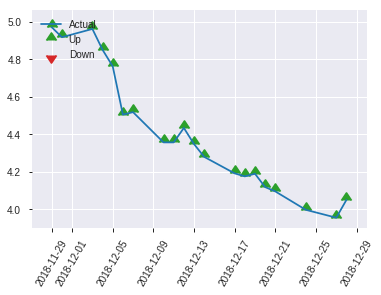


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2580103945096058
RMSE: 0.5079472359503552
LogLoss: 0.7108019891552612
Mean Per-Class Error: 0.46027020105007044
AUC: 0.5055064668971699
pr_auc: 0.5263138392681003
Gini: 0.011012933794339874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24345442652702332: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243454     0.706186  250
max f2                       0.243454     0.857322  250
max f0point5                 0.388152     0.612536  228
max accuracy                 0.407598     0.569721  218
max precision                0.789741     1         0
max recall                   0.243454     1         250
max specificity              0.789741     1         0
max absolute_mcc             0.388152     0.113411  228
max min_per_class_accuracy   0.526803     0.510949  124
max mean_per_class_accuracy  0.498352     0.53973   153

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 53.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.73945            0.610706  0.610706           0.333333         0.759813  0.333333                    0.759813            0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.729005           0.610706  0.610706           0.333333         0.732373  0.333333                    0.746093            0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.725312           0.916058  0.687044           0.5              0.726674  0.375                       0.741238            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.706094           1.22141   0.83278            0.666667         0.713708  0.454545                    0.73373             0.0145985       0.0364964                  22.1411   -16.722
    5        0.0517928                   0.691732           0.916058  0.845592           0.5              0.699366  0.461538                    0.728443            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.660429           0.986524  0.916058           0.538462         0.674376  0.5                         0.70141             0.0510949       0.0948905                  -1.34756  -8.39416
    7        0.151394                    0.639082           0.458029  0.771418           0.25             0.648259  0.421053                    0.684625            0.0218978       0.116788                   -54.1971  -22.8582
    8        0.203187                    0.620896           1.26839   0.898096           0.692308         0.629482  0.490196                    0.670569            0.0656934       0.182482                   26.8389   -10.1904
    9        0.302789                    0.595238           0.952701  0.916058           0.52             0.606485  0.5                         0.649489            0.0948905       0.277372                   -4.72993  -8.39416
    10       0.40239                     0.553968           1.39241   1.03397            0.76             0.569888  0.564356                    0.629786            0.138686        0.416058                   39.2409   3.39669
    11       0.501992                    0.52312            0.952701  1.01784            0.52             0.542294  0.555556                    0.612426            0.0948905       0.510949                   -4.72993  1.78427
    12       0.601594                    0.500201           1.17255   1.04346            0.64             0.512356  0.569536                    0.595858            0.116788        0.627737                   17.2555   4.34572
    13       0.701195                    0.481875           0.879416  1.02016            0.48             0.490957  0.556818                    0.580957            0.0875912       0.715328                   -12.0584  2.01559
    14       0.800797                    0.443376           0.952701  1.01177            0.52             0.460269  0.552239                    0.565946            0.0948905       0.810219                   -4.72993  1.1766
    15       0.900398                    0.393209           1.09927   1.02145            0.6              0.420371  0.557522                    0.549843            0.109489        0.919708                   9.92701   2.14456
    16       1                           0.243454           0.806131  1                  0.44             0.355612  0.545817                    0.530497  

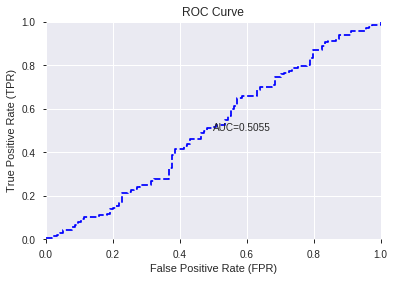

This function is available for GLM models only


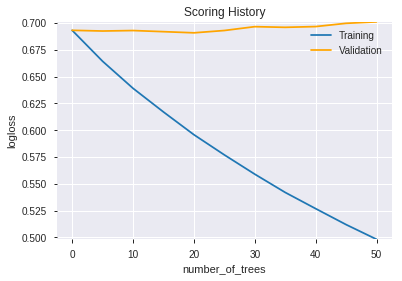

--2019-09-03 02:45:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190903_024532',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190903_024532',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_984b',
   'type

['DX_8',
 'HT_PHASOR_quadrature',
 'BOP',
 'ADXR_8',
 'ATR_30',
 'CORREL_24',
 'CORREL_20',
 'CORREL_30',
 'TAN',
 'SAREXT',
 'BETA_14',
 'BETA_8',
 'HT_DCPERIOD',
 'ADXR_14',
 'aroonup_30',
 'AROONOSC_24',
 'STOCHRSI_fastk',
 'BETA_24',
 'BETA_30',
 'ADXR_12',
 'CORREL_14',
 'BETA_20',
 'dayofweek',
 'aroonup_8',
 'AROONOSC_20',
 'day',
 'aroondown_30',
 'weekofyear',
 'aroonup_24',
 'aroondown_20',
 'aroondown_24',
 'weekday_name',
 'month',
 'weekday',
 'days_in_month',
 'HT_TRENDMODE',
 'CDLDOJI',
 'CDLRICKSHAWMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024604_model_4  0.524011  1.085482              0.485369  0.577187  0.333144
1  DeepLearning_grid_1_AutoML_20190903_024604_model_1  0.512870  2.250478              0.500000  0.652048  0.425167
2  DeepLearning_grid_1_AutoML_20190903_024604_model_5  0.509092  0.696060              0.500000  0.501454  0.251456
3  DeepLearning_grid_1_AutoML_20190903_024604_model_6  0.501857  0.690642              0.500000  0.498762  0.248763
4  DeepLearning_grid_1_AutoML_20190903_024604_model_8  0.500000  0.689913              0.500000  0.498381  0.248384
5  DeepLearning_grid_1_AutoML_20190903_024604_model_7  0.482488  0.750459              0.495614  0.523565  0.274121
6  DeepLearning_grid_1_AutoML_20190903_024604_model_9  0.479767  0.689200              0.500000  0.498024  0.248028
7               DeepLearning_1_AutoML_20190903_024604  0.473108  0.762194              0.500000  0.527062  0.277795
8  DeepLearning_grid_1_AutoML_20190903_024604_model_2  0.472532  0.775385              0.494878  0.536105  0.287409
9  DeepLearning_grid_1_AutoML_20190903_024604_model_3  0.451786  0.801429              0.476598  0.539040  0.290564

variable  relative_importance  scaled_importance  percentage
0          CDLRISEFALL3METHODS             1.000000           1.000000    0.002602
1              CDLUNIQUE3RIVER             0.992155           0.992155    0.002581
2             CDLSTICKSANDWICH             0.992149           0.992149    0.002581
3          CDLGAPSIDESIDEWHITE             0.989623           0.989623    0.002575
4            CDLSTALLEDPATTERN             0.982868           0.982868    0.002557
...                        ...                  ...                ...         ...
1037  BBANDS_middleband_12_3_5             0.325103           0.325103    0.000846
1038                   KAMA_24             0.324939           0.324939    0.000845
1039                    MIN_24             0.324136           0.324136    0.000843
1040               MIDPOINT_14             0.319429           0.319429    0.000831
1041   BBANDS_upperband_20_1_4             0.318340           0.318340    0.000828

[1042 rows x 4 columns]

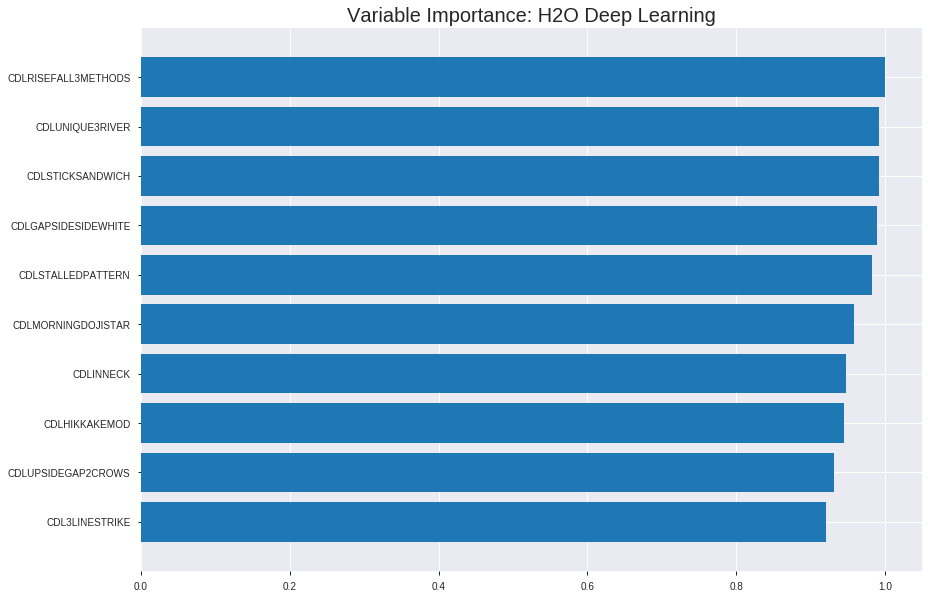

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024604_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22183888718712655
RMSE: 0.4709977570935201
LogLoss: 0.6713559208634649
Mean Per-Class Error: 0.3117471075003937
AUC: 0.7474107069658131
pr_auc: 0.7481594751427894
Gini: 0.49482141393162626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16485430527445322: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      293  558   0.6557   (558.0/851.0)
1      83   820   0.0919   (83.0/903.0)
Total  376  1378  0.3655   (641.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.164854     0.718983  318
max f2                       0.0207852    0.846038  388
max f0point5                 0.712118     0.705946  135
max accuracy                 0.663055     0.686431  156
max precision                0.98826      0.90625   7
max recall                   0.00406779   1         397
max specificity              0.999559     0.99765   0
max absolute_mcc             0.663055     0.378712  156
max min_per_class_accuracy   0.575855     0.675676  186
max mean_per_class_accuracy  0.663055     0.688253  156

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 53.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.997487           1.61868   1.61868            0.833333         0.998661   0.833333                    0.998661            0.0166113       0.0166113                  61.8678   61.8678
    2        0.0205245                   0.993657           1.8345    1.72659            0.944444         0.99514    0.888889                    0.996901            0.0188261       0.0354374                  83.4502   72.659
    3        0.0302166                   0.990369           1.82815   1.75917            0.941176         0.992057   0.90566                     0.995347            0.0177187       0.0531561                  82.8155   75.9168
    4        0.0404789                   0.985884           1.61868   1.72355            0.833333         0.988053   0.887324                    0.993498            0.0166113       0.0697674                  61.8678   72.3551
    5        0.050171                    0.979653           1.71389   1.72169            0.882353         0.981883   0.886364                    0.991254            0.0166113       0.0863787                  71.3895   72.1685
    6        0.100342                    0.952308           1.72169   1.72169            0.886364         0.965687   0.886364                    0.978471            0.0863787       0.172757                   72.1685   72.1685
    7        0.149943                    0.922617           1.49588   1.64699            0.770115         0.937306   0.847909                    0.964853            0.0741971       0.246955                   49.5882   64.699
    8        0.200114                    0.887381           1.47888   1.60484            0.761364         0.905505   0.826211                    0.949974            0.0741971       0.321152                   47.8884   60.4844
    9        0.299886                    0.80866            1.35414   1.52143            0.697143         0.84753    0.78327                     0.915891            0.135105        0.456257                   35.414    52.1435
    10       0.400228                    0.705052           1.22505   1.44713            0.630682         0.760415   0.745014                    0.876911            0.122924        0.579181                   22.5045   44.7126
    11       0.5                         0.584093           0.921259  1.34219            0.474286         0.652604   0.690992                    0.832152            0.0919158       0.671096                   -7.87407  34.2193
    12       0.599772                    0.413387           0.876861  1.26478            0.451429         0.498454   0.651141                    0.776641            0.0874862       0.758583                   -12.3139  26.4785
    13       0.700114                    0.269563           0.783588  1.19582            0.403409         0.333813   0.615635                    0.713174            0.0786268       0.837209                   -21.6412  19.5818
    14       0.799886                    0.148849           0.788065  1.14496            0.405714         0.204797   0.589451                    0.649763            0.0786268       0.915836                   -21.1935  14.4958
    15       0.899658                    0.0640811          0.532776  1.07707            0.274286         0.105953   0.554499                    0.589454            0.0531561       0.968992                   -46.7224  7.70674
    16       1                           0.000472821        0.30902   1                  0.159091         0.0329729  0.514823                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3231089303079661
RMSE: 0.5684267149844087
LogLoss: 1.0089426298749788
Mean Per-Class Error: 0.44970527627354207
AUC: 0.5206546221306368
pr_auc: 0.5328083876801795
Gini: 0.04130924426127369
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.7239546780921645e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.72395e-05  0.701164  399
max f2                       1.72395e-05  0.854351  399
max f0point5                 0.214699     0.596026  331
max accuracy                 0.610616     0.553785  205
max precision                0.610616     0.585455  205
max recall                   1.72395e-05  1         399
max specificity              0.996375     0.995671  0
max absolute_mcc             0.970569     0.114398  13
max min_per_class_accuracy   0.6628       0.523985  185
max mean_per_class_accuracy  0.610616     0.550295  205

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 59.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.983766           0.617466  0.617466           0.333333         0.990002   0.333333                    0.990002            0.00738007      0.00738007                 -38.2534   -38.2534
    2        0.0219124                   0.978274           0.740959  0.673599           0.4              0.98011    0.363636                    0.985506            0.00738007      0.0147601                  -25.9041   -32.6401
    3        0.0318725                   0.972832           0         0.4631             0                0.974788   0.25                        0.982156            0               0.0147601                  -100       -53.69
    4        0.0418327                   0.966937           0.740959  0.529257           0.4              0.968927   0.285714                    0.979007            0.00738007      0.0221402                  -25.9041   -47.0743
    5        0.0517928                   0.961997           1.48192   0.712461           0.8              0.964653   0.384615                    0.976246            0.0147601       0.0369004                  48.1919    -28.7539
    6        0.101594                    0.934066           0.740959  0.726431           0.4              0.949345   0.392157                    0.963059            0.0369004       0.0738007                  -25.9041   -27.3569
    7        0.151394                    0.896921           1.48192   0.974947           0.8              0.913745   0.526316                    0.946838            0.0738007       0.147601                   48.1919    -2.50534
    8        0.201195                    0.865642           1.03734   0.990391           0.56             0.878049   0.534653                    0.929811            0.0516605       0.199262                   3.73432    -0.960871
    9        0.300797                    0.813481           1.07439   1.01821            0.58             0.839221   0.549669                    0.899814            0.107011        0.306273                   7.43911    1.82058
    10       0.400398                    0.766095           1.14849   1.05061            0.62             0.788071   0.567164                    0.872017            0.114391        0.420664                   14.8487    5.06141
    11       0.5                         0.662288           1.03734   1.04797            0.56             0.714701   0.565737                    0.840679            0.103321        0.523985                   3.73432    4.79705
    12       0.599602                    0.540233           1.03734   1.04621            0.56             0.605757   0.564784                    0.801656            0.103321        0.627306                   3.73432    4.62051
    13       0.699203                    0.420245           1.0003    1.03967            0.54             0.479534   0.561254                    0.755769            0.099631        0.726937                   0.0295203  3.96653
    14       0.798805                    0.260795           0.889151  1.0209             0.48             0.34786    0.551122                    0.704908            0.0885609       0.815498                   -11.0849   2.08979
    15       0.898406                    0.150247           0.926199  1.0104             0.5              0.204793   0.545455                    0.649463            0.0922509       0.907749                   -7.38007   1.03992
    16       1                           1.72395e-05        0.908038  1                  0.490196         0.0773619  0.5


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:51:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:51:06  5.847 sec         139 obs/sec       0.27252   1             478        0.648824         2.24708             -0.685371      0.529911        0.509651           1.51077          0.485177                         0.6294             1.79258               -0.594704        0.524049          0.561405             1.23493            0.460159
    2019-09-03 02:51:33  32.141 sec        149 obs/sec       2.33466   8             4095       0.604807         1.51243             -0.464454      0.562856        0.521154           1.29494          0.465792                         0.600747           1.21625               -0.452812        0.512572          0.551246             1.54367            0.458167
    2019-09-03 02:51:57  56.990 sec        151 obs/sec       4.3244    15            7585       0.630519         1.43676             -0.591616      0.612055        0.598961           1.07912          0.428734                         0.682681           2.01613               -0.876125        0.530319          0.551695             0.308733           0.460159
    2019-09-03 02:52:23  1 min 22.452 sec  160 obs/sec       6.69897   23            11750      0.552547         1.01417             -0.222306      0.619808        0.639373           1.72659          0.485177                         0.593049           1.12977               -0.415816        0.491677          0.524505             0.617466           0.460159
    2019-09-03 02:52:47  1 min 46.182 sec  167 obs/sec       9.01995   31            15821      0.574454         1.14955             -0.321152      0.641843        0.624437           1.51077          0.40935                          0.606698           1.3209                -0.48174         0.528809          0.555213             1.23493            0.460159
    2019-09-03 02:53:12  2 min 11.643 sec  173 obs/sec       11.6357   40            20409      0.532353         0.917389            -0.134597      0.670427        0.689246           1.94241          0.441847                         0.573821           1.13747               -0.325496        0.547292          0.56217              0.617466           0.460159
    2019-09-03 02:53:37  2 min 36.500 sec  178 obs/sec       14.2548   49            25003      0.548095         1.16834             -0.202689      0.652981        0.616162           1.51077          0.458951                         0.585278           1.20651               -0.378956        0.536677          0.554991             1.54367            0.452191
    2019-09-03 02:54:01  3 min  0.666 sec  182 obs/sec       16.8746   58            29598      0.470998         0.671356            0.111864       0.747411        0.748159           1.61868          0.36545                          0.568427           1.00894               -0.300694        0.520655          0.532808             0.617466           0.460159
    2019-09-03 02:54:24

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLRISEFALL3METHODS       1.0                    1.0                  0.002601779376684703
CDLUNIQUE3RIVER           0.992155134677887      0.992155134677887    0.0025813687678767606
CDLSTICKSANDWICH          0.9921494126319885     0.9921494126319885   0.0025813538803757495
CDLGAPSIDESIDEWHITE       0.9896234273910522     0.9896234273910522   0.0025747818240700717
CDLSTALLEDPATTERN         0.9828681349754333     0.9828681349754333   0.0025572060435796397
---                       ---                    ---                  ---
BBANDS_middleband_12_3_5  0.32510337233543396    0.32510337233543396  0.0008458472494329804
KAMA_24                   0.3249385356903076     0.3249385356903076   0.0008454183808491687
MIN_24                    0.32413649559020996    0.32413649559020996  0.0008433316494574605
MIDPOINT_14               0.31942930817604065    0.31942930817604065  0.000831084586321085
BBANDS_upperband_20_1_4   0.31833967566490173    0.31833967566490173  0.0008282496029254386


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.7086614173228347)

('auc', 0.524010756819055)

('logloss', 1.085481555520835)

('mean_per_class_error', 0.44199001152516326)

('rmse', 0.5771866503132159)

('mse', 0.33314442929979055)

deeplearning prediction progress: |███████████████████████████████████████| 100%


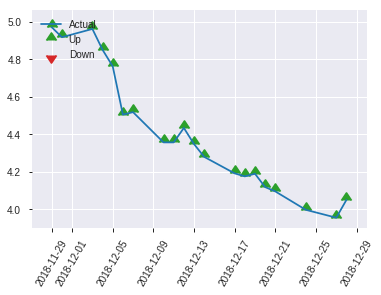


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.33314442929979055
RMSE: 0.5771866503132159
LogLoss: 1.085481555520835
Mean Per-Class Error: 0.44199001152516326
AUC: 0.524010756819055
pr_auc: 0.5426428383807362
Gini: 0.048021513638109914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06750813570999546: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    109  0.9561   (109.0/114.0)
1      2    135  0.0146   (2.0/137.0)
Total  7    244  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0675081    0.708661  243
max f2                       0.0174136    0.857322  250
max f0point5                 0.315496     0.610302  188
max accuracy                 0.315496     0.569721  188
max precision                0.995688     1         0
max recall                   0.0174136    1         250
max specificity              0.995688     1         0
max absolute_mcc             0.504321     0.117435  147
max min_per_class_accuracy   0.643661     0.535088  126
max mean_per_class_accuracy  0.504321     0.55801   147

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 61.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.993735           1.22141   1.22141            0.666667         0.994925   0.666667                    0.994925            0.0145985       0.0145985                  22.1411   22.1411
    2        0.0239044                   0.99199            0         0.610706           0                0.992484   0.333333                    0.993704            0               0.0145985                  -100      -38.9294
    3        0.0318725                   0.990897           0.916058  0.687044           0.5              0.991563   0.375                       0.993169            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.989026           1.22141   0.83278            0.666667         0.989684   0.454545                    0.992219            0.0145985       0.0364964                  22.1411   -16.722
    5        0.0517928                   0.98802            0.916058  0.845592           0.5              0.988308   0.461538                    0.991617            0.00729927      0.0437956                  -8.39416  -15.4408
    6        0.103586                    0.98043            0.986524  0.916058           0.538462         0.984194   0.5                         0.987906            0.0510949       0.0948905                  -1.34756  -8.39416
    7        0.151394                    0.960997           0.763382  0.867845           0.416667         0.970429   0.473684                    0.982387            0.0364964       0.131387                   -23.6618  -13.2155
    8        0.203187                    0.945049           0.845592  0.862173           0.461538         0.955103   0.470588                    0.975432            0.0437956       0.175182                   -15.4408  -13.7827
    9        0.302789                    0.89676            1.24584   0.988379           0.68             0.920453   0.539474                    0.957347            0.124088        0.29927                    24.5839   -1.16212
    10       0.40239                     0.825175           0.952701  0.979548           0.52             0.862693   0.534653                    0.933918            0.0948905       0.394161                   -4.72993  -2.04524
    11       0.501992                    0.646338           1.39241   1.06146            0.76             0.754291   0.579365                    0.898278            0.138686        0.532847                   39.2409   6.14645
    12       0.601594                    0.496521           1.17255   1.07986            0.64             0.562534   0.589404                    0.842691            0.116788        0.649635                   17.2555   7.98569
    13       0.701195                    0.363528           0.806131  1.04098            0.44             0.437186   0.568182                    0.785091            0.080292        0.729927                   -19.3869  4.09754
    14       0.800797                    0.247084           0.879416  1.02088            0.48             0.307137   0.557214                    0.725644            0.0875912       0.817518                   -12.0584  2.0881
    15       0.900398                    0.160954           0.879416  1.00523            0.48             0.212566   0.548673                    0.668887            0.0875912       0.905109                   -12.0584  0.523222
    16       1                           0.0174136          0.952701  1                  0.52             0.0932963  0.545817           

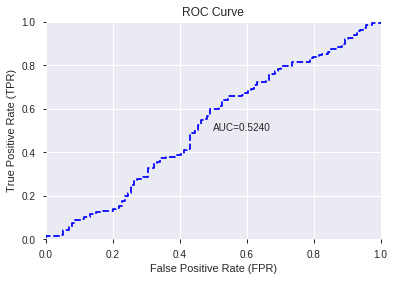

This function is available for GLM models only


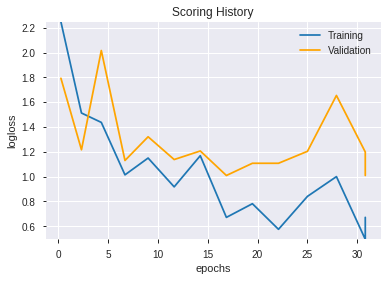

--2019-09-03 03:12:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.234.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.234.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024604_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024604_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRISEFALL3METHODS',
 'CDLUNIQUE3RIVER',
 'CDLSTICKSANDWICH',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGDOJISTAR',
 'CDLINNECK',
 'CDLHIKKAKEMOD',
 'CDLUPSIDEGAP2CROWS',
 'CDL3LINESTRIKE',
 'CDLPIERCING',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLEVENINGSTAR',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLMATCHINGLOW',
 'is_quarter_end',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'CDL3INSIDE',
 'weekday',
 'CDLDOJISTAR',
 'CDLHARAMICROSS',
 'HT_TRENDMODE',
 'dayofweek',
 'TANH',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'HT_PHASOR_quadrature',
 'BOP',
 'days_in_month',
 'aroondown_20',
 'weekday_name',
 'CDLLONGLEGGEDDOJI',
 'BETA_8',
 'ADXR_14',
 'day',
 'BETA_14',
 'HT_PHASOR_inphase',
 'aroonup_24',
 'ADX_24',
 'aro

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_031222_model_1  0.43818  0.696031                   0.5  0.501433  0.251435

variable  relative_importance  scaled_importance    percentage
0                      weekday         1.108373e-02           1.000000  1.488353e-02
1                    dayofweek         1.106441e-02           0.998257  1.485758e-02
2                       BETA_8         1.097223e-02           0.989940  1.473379e-02
3         HT_PHASOR_quadrature         1.050676e-02           0.947944  1.410875e-02
4                   aroonup_30         9.250079e-03           0.834563  1.242125e-02
...                        ...                  ...                ...           ...
1037   BBANDS_upperband_24_2_2         1.111007e-06           0.000100  1.491889e-06
1038  BBANDS_middleband_30_1_4         6.166945e-07           0.000056  8.281136e-07
1039   BBANDS_upperband_20_5_3         5.599934e-07           0.000051  7.519738e-07
1040  BBANDS_middleband_30_0_4         3.891296e-07           0.000035  5.225334e-07
1041   BBANDS_lowerband_14_7_4         1.132228e-07           0.000010  1.520386e-07

[1042 rows x 4 columns]

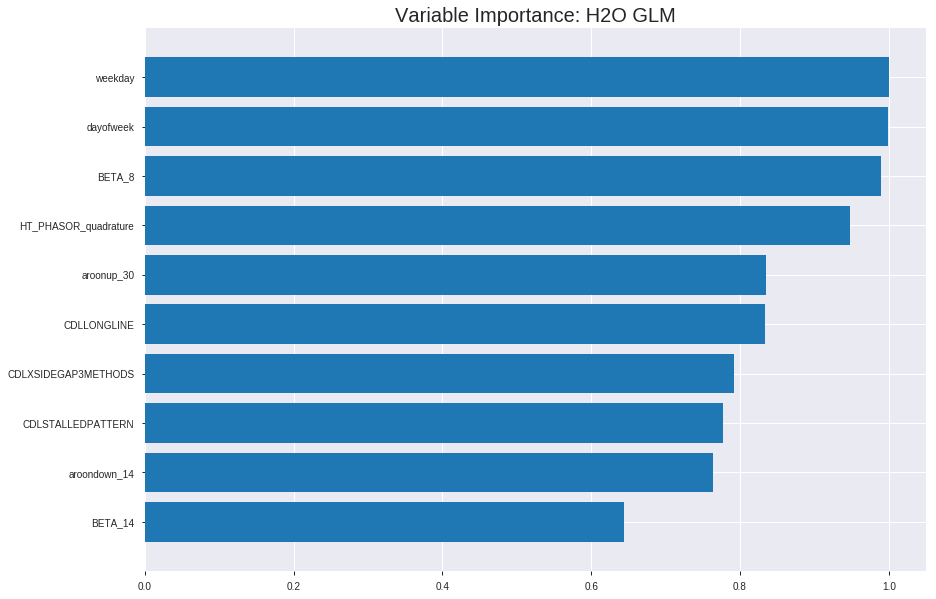

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_031222_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2463873928136636
RMSE: 0.496374246726866
LogLoss: 0.6858984001912245
Null degrees of freedom: 1753
Residual degrees of freedom: 711
Null deviance: 2430.0184643429493
Residual deviance: 2406.1315878708156
AIC: 4492.131587870816
AUC: 0.5899528012773715
pr_auc: 0.601925008562306
Gini: 0.17990560255474297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4767683879117792: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      63   788   0.926    (788.0/851.0)
1      24   879   0.0266   (24.0/903.0)
Total  87   1667  0.4629   (812.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476768     0.684047  352
max f2                       0.456474     0.843295  390
max f0point5                 0.491284     0.589007  305
max accuracy                 0.520466     0.564424  172
max precision                0.578181     0.888889  8
max recall                   0.456474     1         390
max specificity              0.624136     0.998825  0
max absolute_mcc             0.536797     0.13791   100
max min_per_class_accuracy   0.514715     0.553467  199
max mean_per_class_accuracy  0.520466     0.567154  172

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.572482           1.51077   1.51077            0.777778         0.585231  0.777778                    0.585231            0.0155039       0.0155039                  51.0767    51.0767
    2        0.0205245                   0.562032           1.61868   1.56472            0.833333         0.565668  0.805556                    0.57545             0.0166113       0.0321152                  61.8678    56.4723
    3        0.0302166                   0.556662           1.02834   1.39267            0.529412         0.558987  0.716981                    0.570169            0.00996678      0.0420819                  2.83369    39.2674
    4        0.0404789                   0.553932           1.51077   1.42261            0.777778         0.554869  0.732394                    0.56629             0.0155039       0.0575858                  51.0767    42.2613
    5        0.050171                    0.552213           1.25686   1.39059            0.647059         0.553182  0.715909                    0.563758            0.0121816       0.0697674                  25.6856    39.0592
    6        0.100342                    0.543726           1.3023    1.34645            0.670455         0.547334  0.693182                    0.555546            0.0653378       0.135105                   30.23      34.6446
    7        0.149943                    0.539364           1.13866   1.27771            0.586207         0.541455  0.657795                    0.550885            0.0564784       0.191584                   13.8657    27.771
    8        0.200114                    0.535633           1.19194   1.25621            0.613636         0.537646  0.646724                    0.547565            0.0598007       0.251384                   19.1936    25.6205
    9        0.299886                    0.527267           1.02115   1.178              0.525714         0.531295  0.606464                    0.542152            0.101883        0.353267                   2.11549    17.8004
    10       0.400228                    0.520891           1.10364   1.15936            0.568182         0.523994  0.596866                    0.5376              0.110742        0.464009                   10.3644    15.9361
    11       0.5                         0.514731           0.876861  1.10299            0.451429         0.517945  0.567845                    0.533678            0.0874862       0.551495                   -12.3139   10.299
    12       0.599772                    0.508553           0.976757  1.08199            0.502857         0.511458  0.557034                    0.529982            0.0974529       0.648948                   -2.32432   8.19912
    13       0.700114                    0.502159           0.971207  1.06611            0.5              0.505313  0.54886                     0.526446            0.0974529       0.746401                   -2.87929   6.61133
    14       0.799886                    0.495224           0.998956  1.05774            0.514286         0.498756  0.544547                    0.522992            0.0996678       0.846069                   -0.104414  5.77366
    15       0.899658                    0.48507            0.887961  1.03891            0.457143         0.490592  0.534854                    0.519399            0.0885936       0.934662                   -11.2039   3.89085
    16       1                           0.416364           0.65115   1                  0.335227         0.473798  0.514823                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24779320002378982
RMSE: 0.49778830844425204
LogLoss: 0.6887096099178481
Null degrees of freedom: 501
Residual degrees of freedom: -541
Null deviance: 693.9887622709523
Residual deviance: 691.4644483575195
AIC: 2777.4644483575194
AUC: 0.5372997236465872
pr_auc: 0.5902489915083227
Gini: 0.07459944729317436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4352907336741921: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435291     0.701164  399
max f2                       0.435291     0.854351  399
max f0point5                 0.500085     0.599045  355
max accuracy                 0.504979     0.553785  331
max precision                0.592102     1         0
max recall                   0.435291     1         399
max specificity              0.592102     1         0
max absolute_mcc             0.575869     0.131625  9
max min_per_class_accuracy   0.525914     0.519481  203
max mean_per_class_accuracy  0.523178     0.547811  224

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 52.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.58011            1.8524    1.8524             1                0.586411  1                           0.586411            0.0221402       0.0221402                  85.2399    85.2399
    2        0.0219124                   0.57557            1.48192   1.684              0.8              0.576933  0.909091                    0.582103            0.0147601       0.0369004                  48.1919    68.3999
    3        0.0318725                   0.571553           1.11144   1.50507            0.6              0.573442  0.8125                      0.579396            0.0110701       0.0479705                  11.1439    50.5074
    4        0.0418327                   0.567963           1.11144   1.41135            0.6              0.569333  0.761905                    0.577               0.0110701       0.0590406                  11.1439    41.1351
    5        0.0517928                   0.564942           1.48192   1.42492            0.8              0.56612   0.769231                    0.574908            0.0147601       0.0738007                  48.1919    42.4922
    6        0.101594                    0.557856           0.740959  1.08965            0.4              0.561112  0.588235                    0.568145            0.0369004       0.110701                   -25.9041   8.96462
    7        0.151394                    0.549376           1.25963   1.14556            0.68             0.55314   0.618421                    0.563209            0.0627306       0.173432                   25.9631    14.5562
    8        0.201195                    0.545684           0.815055  1.06375            0.44             0.547239  0.574257                    0.559256            0.0405904       0.214022                   -18.4945   6.37536
    9        0.300797                    0.538742           1.0003    1.04274            0.54             0.542284  0.562914                    0.553636            0.099631        0.313653                   0.0295203  4.27409
    10       0.400398                    0.531885           0.963247  1.02297            0.52             0.534956  0.552239                    0.548989            0.095941        0.409594                   -3.67528   2.29663
    11       0.5                         0.525951           1.07439   1.03321            0.58             0.528831  0.557769                    0.544974            0.107011        0.516605                   7.43911    3.32103
    12       0.599602                    0.521163           1.07439   1.04005            0.58             0.523441  0.561462                    0.541397            0.107011        0.623616                   7.43911    4.0051
    13       0.699203                    0.516141           0.889151  1.01856            0.48             0.518709  0.549858                    0.538165            0.0885609       0.712177                   -11.0849   1.85553
    14       0.798805                    0.509432           1.03734   1.0209             0.56             0.513184  0.551122                    0.53505             0.103321        0.815498                   3.73432    2.08979
    15       0.898406                    0.500265           0.963247  1.01451            0.52             0.504829  0.547672                    0.5317              0.095941        0.911439                   -3.67528   1.45065
    16       1                           0.435291           0.871717  1                  0.470588         0.488323  0.539841                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:12:25  0.000 sec   2            3.2       1040          1.37459           1.37756
    2019-09-03 03:12:28  2.214 sec   4            2.3       1043          1.3718            1.37742
    2019-09-03 03:12:30  4.468 sec   6            1.7       1043          1.3685            1.37761
    2019-09-03 03:12:32  6.784 sec   8            1.2       1043          1.36465           1.37817
    2019-09-03 03:12:35  9.148 sec   10           0.9       1043          1.36022           1.3793
    2019-09-03 03:12:37  11.502 sec  12           0.66      1043          1.35525           1.3812
    2019-09-03 03:12:39  13.871 sec  14           0.48      1043          1.34981           1.38409

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.7061855670103092)

('auc', 0.4381803047765399)

('logloss', 0.6960310005488157)

('mean_per_class_error', 0.4838647714175951)

('rmse', 0.5014326427211825)

('mse', 0.2514346951863491)

glm prediction progress: |████████████████████████████████████████████████| 100%


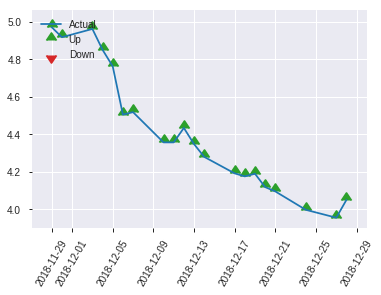


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514346951863491
RMSE: 0.5014326427211825
LogLoss: 0.6960310005488157
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 346.81644986094483
Residual deviance: 349.4075622755055
AIC: 2435.4075622755054
AUC: 0.4381803047765399
pr_auc: 0.4953355822688185
Gini: -0.12363939044692018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47112377062453775: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471124     0.706186  249
max f2                       0.471124     0.857322  249
max f0point5                 0.489171     0.603039  227
max accuracy                 0.489171     0.553785  227
max precision                0.578955     1         0
max recall                   0.471124     1         249
max specificity              0.578955     1         0
max absolute_mcc             0.520827     0.165972  78
max min_per_class_accuracy   0.513327     0.429825  122
max mean_per_class_accuracy  0.489171     0.516135  227

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.574302           1.22141   1.22141            0.666667         0.577519  0.666667                    0.577519            0.0145985       0.0145985                  22.1411   22.1411
    2        0.0239044                   0.568995           0         0.610706           0                0.570599  0.333333                    0.574059            0               0.0145985                  -100      -38.9294
    3        0.0318725                   0.562107           0.916058  0.687044           0.5              0.562741  0.375                       0.57123             0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.557553           0.610706  0.666224           0.333333         0.560031  0.363636                    0.568175            0.00729927      0.0291971                  -38.9294  -33.3776
    5        0.0517928                   0.553185           0.916058  0.70466            0.5              0.55542   0.384615                    0.566213            0.00729927      0.0364964                  -8.39416  -29.534
    6        0.103586                    0.540747           0.845592  0.775126           0.461538         0.546188  0.423077                    0.556201            0.0437956       0.080292                   -15.4408  -22.4874
    7        0.151394                    0.534761           0.916058  0.819631           0.5              0.537875  0.447368                    0.550414            0.0437956       0.124088                   -8.39416  -18.0369
    8        0.203187                    0.529823           0.70466   0.790325           0.384615         0.532131  0.431373                    0.545753            0.0364964       0.160584                   -29.534   -20.9675
    9        0.302789                    0.522893           0.806131  0.795524           0.44             0.525659  0.434211                    0.539143            0.080292        0.240876                   -19.3869  -20.4476
    10       0.40239                     0.517961           1.17255   0.888849           0.64             0.519509  0.485149                    0.534283            0.116788        0.357664                   17.2555   -11.1151
    11       0.501992                    0.513037           0.879416  0.886977           0.48             0.515377  0.484127                    0.530532            0.0875912       0.445255                   -12.0584  -11.3023
    12       0.601594                    0.508539           1.17255   0.934258           0.64             0.510797  0.509934                    0.527265            0.116788        0.562044                   17.2555   -6.57418
    13       0.701195                    0.502201           1.39241   0.999336           0.76             0.505358  0.545455                    0.524153            0.138686        0.70073                    39.2409   -0.066357
    14       0.800797                    0.495829           0.952701  0.993536           0.52             0.498557  0.542289                    0.520969            0.0948905       0.79562                    -4.72993  -0.646403
    15       0.900398                    0.489369           1.09927   1.00523            0.6              0.493334  0.548673                    0.517912            0.109489        0.905109                   9.92701   0.523222
    16       1                           0.471124           0.952701  1                  0.52             0.483997  0.545817                    0.

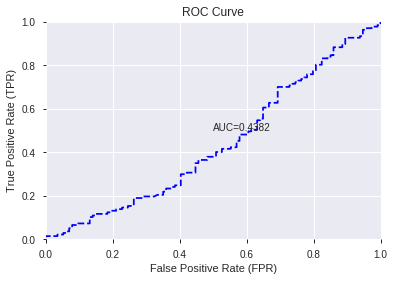

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


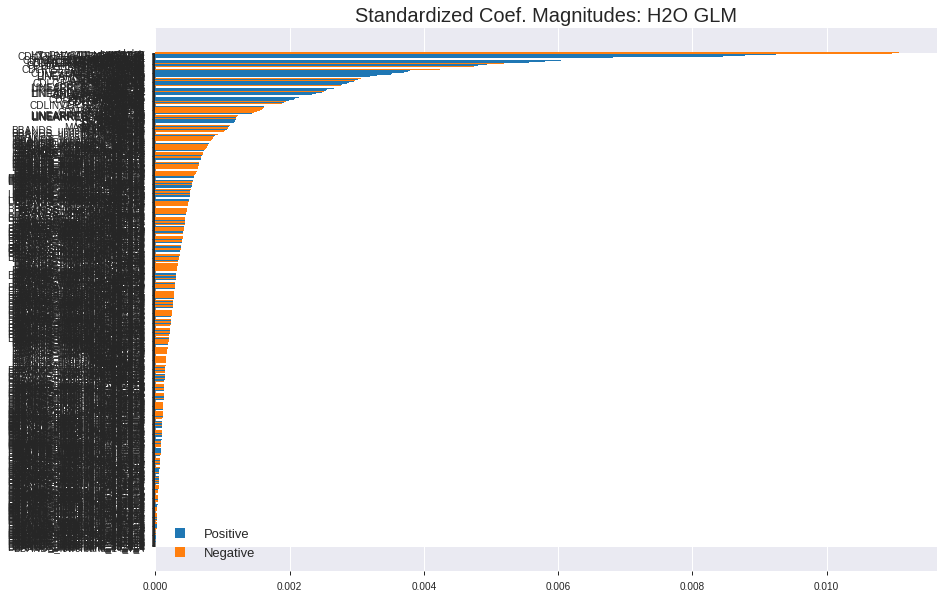

'log_likelihood'
--2019-09-03 03:13:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_031222_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_031222_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['weekday',
 'dayofweek',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'CDLLONGLINE',
 'CDLXSIDEGAP3METHODS',
 'CDLSTALLEDPATTERN',
 'aroondown_14',
 'BETA_14',
 'aroondown_12',
 'aroonup_24',
 'CDLTHRUSTING',
 'BETA_24',
 'CDLSTICKSANDWICH',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLTASUKIGAP',
 'CDLMORNINGDOJISTAR',
 'CDLHANGINGMAN',
 'is_quarter_end',
 'CDLSEPARATINGLINES',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'CDLHARAMI',
 'aroondown_20',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'BETA_12',
 'CDLDOJISTAR',
 'ADX_8',
 'CORREL_20',
 'CDLRISEFALL3METHODS',
 'MFI_20',
 'CDLHIGHWAVE',
 'TANH',
 'CDLENGULFING',
 'CDLHAMMER',
 'ADX_12',
 'AD',
 'CDLEVENINGDOJISTAR',
 'AROONOSC_30',
 'Volume',
 'DX_30',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'BETA_20',
 'MFI_30',
 'is_month_end',
 'MINUS_DI_8',
 'CDL3INSIDE',
 'CDLBELTHOLD',
 'DX_24',
 'CDLPIERCING',
 'CDLSPINNINGTOP',
 'AROONOSC_14',
 'CDLINNECK',
 'ADX_14',
 'CORREL_8',
 'aroonup_14',
 'SAREXT',
 'aroondown_30',
 'MI

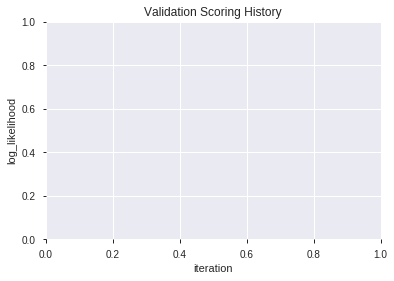

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_031318_model_6  0.519785  0.697234              0.486106  0.501808  0.251811
1               XGBoost_2_AutoML_20190903_031318  0.487322  0.707724              0.457581  0.506934  0.256982
2  XGBoost_grid_1_AutoML_20190903_031318_model_1  0.482744  0.705336              0.467826  0.505716  0.255749
3  XGBoost_grid_1_AutoML_20190903_031318_model_3  0.475349  0.707970              0.491228  0.506908  0.256956
4  XGBoost_grid_1_AutoML_20190903_031318_model_7  0.472532  0.729038              0.482456  0.515991  0.266247
5  XGBoost_grid_1_AutoML_20190903_031318_model_4  0.467153  0.708574              0.494878  0.507449  0.257504
6               XGBoost_1_AutoML_20190903_031318  0.455692  0.717970              0.461967  0.511575  0.261709
7               XGBoost_3_AutoML_20190903_031318  0.446728  0.719844              0.486842  0.512110  0.262256
8  XGBoost_grid_1_AutoML_20190903_031318_model_5  0.435011  0.754476              0.490492  0.527074  0.277807
9  XGBoost_grid_1_AutoML_20190903_031318_model_2  0.406262  0.718924              0.490492  0.512431  0.262585

variable  relative_importance  scaled_importance  percentage
0                   CORREL_8           136.268082           1.000000    0.019330
1                        BOP           122.807892           0.901223    0.017420
2                     ADX_24           117.269585           0.860580    0.016635
3                     Volume           107.347954           0.787770    0.015227
4                     ADXR_8           105.977135           0.777711    0.015033
..                       ...                  ...                ...         ...
303  BBANDS_lowerband_24_1_4             2.823604           0.020721    0.000401
304   BBANDS_lowerband_8_1_3             2.738153           0.020094    0.000388
305   BBANDS_lowerband_8_8_5             2.523397           0.018518    0.000358
306  BBANDS_upperband_14_1_3             2.429855           0.017831    0.000345
307              aroondown_8             2.175873           0.015968    0.000309

[308 rows x 4 columns]

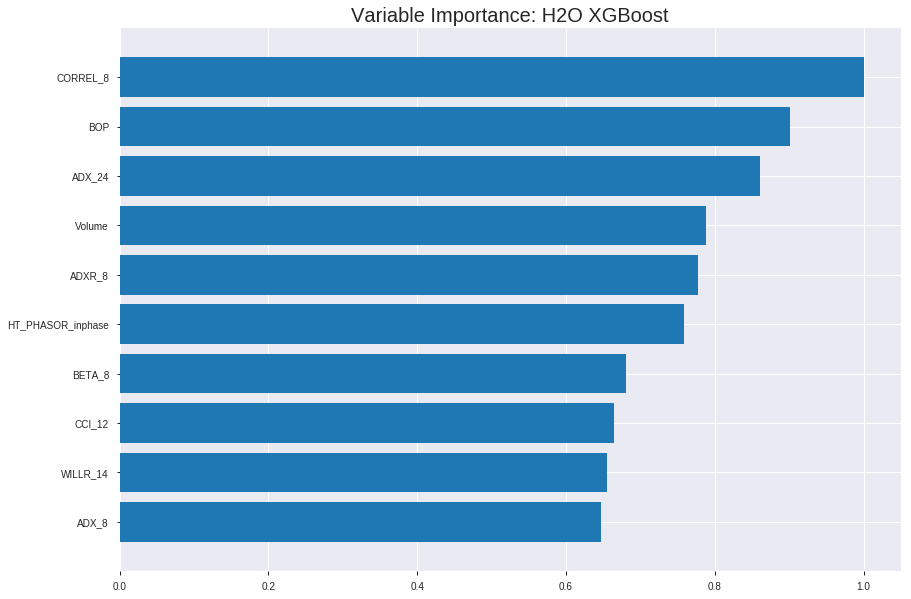

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_031318_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17921112960749697
RMSE: 0.4233333551794578
LogLoss: 0.5475429970441168
Mean Per-Class Error: 0.1264208741458488
AUC: 0.9459368367356233
pr_auc: 0.9449027701523244
Gini: 0.8918736734712467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48996271938085556: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      686  165  0.1939   (165.0/851.0)
1      69   834  0.0764   (69.0/903.0)
Total  755  999  0.1334   (234.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489963     0.876972  222
max f2                       0.459093     0.924607  252
max f0point5                 0.548467     0.892127  168
max accuracy                 0.516553     0.872862  197
max precision                0.814713     1         0
max recall                   0.354082     1         355
max specificity              0.814713     1         0
max absolute_mcc             0.516553     0.747087  197
max min_per_class_accuracy   0.508395     0.870432  204
max mean_per_class_accuracy  0.516553     0.873579  197

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.752727           1.94241    1.94241            1                0.772746  1                           0.772746            0.0199336       0.0199336                  94.2414   94.2414
    2        0.0205245                   0.733792           1.94241    1.94241            1                0.741944  1                           0.757345            0.0199336       0.0398671                  94.2414   94.2414
    3        0.0302166                   0.715954           1.94241    1.94241            1                0.722746  1                           0.746247            0.0188261       0.0586932                  94.2414   94.2414
    4        0.0404789                   0.705086           1.94241    1.94241            1                0.711699  1                           0.737488            0.0199336       0.0786268                  94.2414   94.2414
    5        0.050171                    0.693573           1.94241    1.94241            1                0.700092  1                           0.730264            0.0188261       0.0974529                  94.2414   94.2414
    6        0.100342                    0.661784           1.89827    1.92034            0.977273         0.675882  0.988636                    0.703073            0.0952381       0.192691                   89.8268   92.0341
    7        0.149943                    0.636023           1.92009    1.92026            0.988506         0.647928  0.988593                    0.684831            0.0952381       0.287929                   92.0088   92.0257
    8        0.200114                    0.615483           1.80998    1.89261            0.931818         0.625427  0.974359                    0.669938            0.0908084       0.378738                   80.9977   89.2609
    9        0.299886                    0.581376           1.85362    1.87964            0.954286         0.598439  0.967681                    0.64615             0.184939        0.563677                   85.3618   87.9637
    10       0.400228                    0.546058           1.67754    1.82897            0.863636         0.563806  0.941595                    0.625506            0.168328        0.732004                   67.754    82.8968
    11       0.5                         0.51189            1.29864    1.72315            0.668571         0.52909   0.887115                    0.606267            0.129568        0.861573                   29.8643   72.3145
    12       0.599772                    0.480254           0.821364   1.57313            0.422857         0.495609  0.809886                    0.587859            0.0819491       0.943522                   -17.8636  57.3134
    13       0.700114                    0.44768            0.419385   1.40778            0.215909         0.463741  0.724756                    0.57007             0.0420819       0.985604                   -58.0615  40.7776
    14       0.799886                    0.410586           0.0998956  1.24464            0.0514286        0.429072  0.64077                     0.552483            0.00996678      0.99557                    -90.0104  24.464
    15       0.899658                    0.366048           0.0332985  1.1103             0.0171429        0.389252  0.57161                     0.534381            0.00332226      0.998893                   -96.6701  11.0303
    16       1                           0.217788           0.0110364  1                  0.00568182       0.333695  0.514823                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2517085792209544
RMSE: 0.5017056699111088
LogLoss: 0.6967594120426474
Mean Per-Class Error: 0.470879059439945
AUC: 0.5136739029727959
pr_auc: 0.5492459055505546
Gini: 0.02734780594559183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3172776401042938: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    230  0.9957   (230.0/231.0)
1      0    271  0        (0.0/271.0)
Total  1    501  0.4582   (230.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.317278     0.702073   398
max f2                       0.317278     0.85489    398
max f0point5                 0.415645     0.601017   371
max accuracy                 0.442683     0.553785   347
max precision                0.748982     1          0
max recall                   0.317278     1          398
max specificity              0.748982     1          0
max absolute_mcc             0.415645     0.0797514  371
max min_per_class_accuracy   0.520845     0.510823   196
max mean_per_class_accuracy  0.559694     0.529121   121

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 52.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.696341           0.926199  0.926199           0.5              0.721787  0.5                         0.721787            0.0110701       0.0110701                  -7.38007   -7.38007
    2        0.0219124                   0.686808           1.48192   1.1788             0.8              0.692072  0.636364                    0.70828             0.0147601       0.0258303                  48.1919    17.8799
    3        0.0318725                   0.664152           0.740959  1.04197            0.4              0.671371  0.5625                      0.696746            0.00738007      0.0332103                  -25.9041   4.19742
    4        0.0418327                   0.654291           1.11144   1.05851            0.6              0.656932  0.571429                    0.687266            0.0110701       0.0442804                  11.1439    5.85134
    5        0.0517928                   0.649886           0.740959  0.997445           0.4              0.650838  0.538462                    0.680261            0.00738007      0.0516605                  -25.9041   -0.255464
    6        0.101594                    0.618364           0.889151  0.94436            0.48             0.634017  0.509804                    0.657592            0.0442804       0.095941                   -11.0849   -5.564
    7        0.151394                    0.601821           1.25963   1.04807            0.68             0.60915   0.565789                    0.641657            0.0627306       0.158672                   25.9631    4.80676
    8        0.201195                    0.585129           0.889151  1.00873            0.48             0.59213   0.544554                    0.629398            0.0442804       0.202952                   -11.0849   0.873187
    9        0.300797                    0.554913           1.14849   1.05501            0.62             0.568859  0.569536                    0.609352            0.114391        0.317343                   14.8487    5.50084
    10       0.400398                    0.536792           1.0003    1.0414             0.54             0.544238  0.562189                    0.593154            0.099631        0.416974                   0.0295203  4.13982
    11       0.5                         0.520845           0.926199  1.01845            0.5              0.52827   0.549801                    0.580229            0.0922509       0.509225                   -7.38007   1.84502
    12       0.599602                    0.50414            0.778007  0.97851            0.42             0.512849  0.528239                    0.569037            0.0774908       0.586716                   -22.1993   -2.14905
    13       0.699203                    0.484124           1.18554   1.008              0.64             0.49334   0.54416                     0.558254            0.118081        0.704797                   18.5535    0.800034
    14       0.798805                    0.465066           0.963247  1.00242            0.52             0.474608  0.541147                    0.547824            0.095941        0.800738                   -3.67528   0.242015
    15       0.898406                    0.439104           1.11144   1.01451            0.6              0.452536  0.547672                    0.53726             0.110701        0.911439                   11.1439    1.45065
    16       1                           0.275051           0.871717  1                  0.470588         0.402409  0.539841              


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:14:04  28.741 sec  0                  0.5              0.693147            0.5             0                  1                0.485177                         0.5                0.693147              0.5               0                    1                  0.460159
    2019-09-03 03:14:05  29.893 sec  5                  0.49013          0.673559            0.752088        0.767481           1.94241          0.333523                         0.499188           0.691521              0.517875          0.550485             0.926199           0.440239
    2019-09-03 03:14:05  30.137 sec  10                 0.480979         0.655661            0.822804        0.833927           1.94241          0.285063                         0.498832           0.690797              0.520151          0.576853             1.54367            0.460159
    2019-09-03 03:14:05  30.374 sec  15                 0.473246         0.640694            0.854823        0.865699           1.94241          0.22862                          0.49947            0.692109              0.518123          0.543896             0.926199           0.458167
    2019-09-03 03:14:06  30.620 sec  20                 0.465988         0.626742            0.875927        0.883309           1.94241          0.205245                         0.499538           0.692223              0.514033          0.557767             1.23493            0.460159
    2019-09-03 03:14:06  30.887 sec  25                 0.458692         0.612877            0.889242        0.892307           1.94241          0.188712                         0.500607           0.694382              0.509585          0.555607             1.54367            0.458167
    2019-09-03 03:14:06  31.147 sec  30                 0.451229         0.598828            0.905398        0.907996           1.94241          0.168187                         0.500603           0.694404              0.51107           0.553923             0.926199           0.458167
    2019-09-03 03:14:06  31.393 sec  35                 0.444534         0.586351            0.917512        0.918876           1.94241          0.161345                         0.499621           0.692429              0.525             0.561794             1.23493            0.458167
    2019-09-03 03:14:07  31.648 sec  40                 0.437659         0.573591            0.92713         0.928014           1.94241          0.149943                         0.500417           0.694039              0.517787          0.558115             0.926199           0.458167
    2019-09-03 03:14:07  31.910 sec  45                 0.431323         0.561987            0.937071        0.936095           1.94241          0.141961                         0.499781           0.692723              0.525519          0.561914             1.23493            0.458167
    2019-09-03 03:14:07  32.178 sec  50                 0.423333         0.547543            0.945937        0.944903           1.94241          0.133409                         0.501706           0.696759              0.513674          0.549246             0.926199           0.458167

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_8                 136.26808166503906     1.0                   0.019329524676597445
BOP                      122.80789184570312     0.9012227246845489    0.017420206895900375
ADX_24                   117.26958465576172     0.8605799921952553    0.016634602195324224
Volume                   107.34795379638672     0.7877703456650913    0.015227226336025083
ADXR_8                   105.97713470458984     0.7777106231310463    0.015032776681063538
---                      ---                    ---                   ---
BBANDS_lowerband_24_1_4  2.823603630065918      0.020720946501665928  0.00040052604672640704
BBANDS_lowerband_8_1_3   2.7381534576416016     0.020093872491522     0.0003884050041732771
BBANDS_lowerband_8_8_5   2.5233969688415527     0.018517887226477008  0.000357941958102636
BBANDS_upperband_14_1_3  2.4298553466796875     0.01783143430941166   0.00034467314950289903
aroondown_8              2.175873041152954      0.01596759134322793   0.000308645950894748


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5816733067729084)

('F1', 0.710182767624021)

('auc', 0.5197848636189013)

('logloss', 0.6972338093844799)

('mean_per_class_error', 0.43770008964015883)

('rmse', 0.501808114019438)

('mse', 0.2518113832957454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


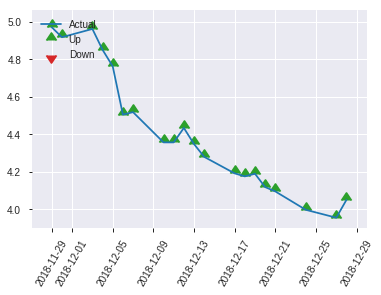


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2518113832957454
RMSE: 0.501808114019438
LogLoss: 0.6972338093844799
Mean Per-Class Error: 0.43770008964015883
AUC: 0.5197848636189013
pr_auc: 0.5306405614916367
Gini: 0.03956972723780261
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3807324171066284: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    110  0.9649   (110.0/114.0)
1      1    136  0.0073   (1.0/137.0)
Total  5    246  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380732     0.710183  245
max f2                       0.369004     0.859473  248
max f0point5                 0.479676     0.618497  181
max accuracy                 0.480441     0.581673  179
max precision                0.48439      0.589595  172
max recall                   0.369004     1         248
max specificity              0.716145     0.991228  0
max absolute_mcc             0.480441     0.137741  179
max min_per_class_accuracy   0.520816     0.525547  125
max mean_per_class_accuracy  0.480441     0.5623    179

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.678398           0.610706  0.610706           0.333333         0.69952   0.333333                    0.69952             0.00729927      0.00729927                 -38.9294  -38.9294
    2        0.0239044                   0.66224            0.610706  0.610706           0.333333         0.668859  0.333333                    0.68419             0.00729927      0.0145985                  -38.9294  -38.9294
    3        0.0318725                   0.651071           0.916058  0.687044           0.5              0.654327  0.375                       0.676724            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.649749           1.22141   0.83278            0.666667         0.650095  0.454545                    0.669462            0.0145985       0.0364964                  22.1411   -16.722
    5        0.0517928                   0.643333           0         0.70466            0                0.645506  0.384615                    0.665776            0               0.0364964                  -100      -29.534
    6        0.103586                    0.626143           0.845592  0.775126           0.461538         0.633732  0.423077                    0.649754            0.0437956       0.080292                   -15.4408  -22.4874
    7        0.151394                    0.604339           1.06873   0.867845           0.583333         0.613624  0.473684                    0.638344            0.0510949       0.131387                   6.87348   -13.2155
    8        0.203187                    0.589913           0.986524  0.898096           0.538462         0.596597  0.490196                    0.627703            0.0510949       0.182482                   -1.34756  -10.1904
    9        0.302789                    0.567589           0.952701  0.916058           0.52             0.577229  0.5                         0.6111              0.0948905       0.277372                   -4.72993  -8.39416
    10       0.40239                     0.54253            1.17255   0.979548           0.64             0.553329  0.534653                    0.5968              0.116788        0.394161                   17.2555   -2.04524
    11       0.501992                    0.520816           1.31912   1.04692            0.72             0.53064   0.571429                    0.583673            0.131387        0.525547                   31.9124   4.69239
    12       0.601594                    0.501658           1.09927   1.05559            0.6              0.510526  0.576159                    0.571563            0.109489        0.635036                   9.92701   5.55905
    13       0.701195                    0.481507           1.09927   1.06179            0.6              0.491742  0.579545                    0.560225            0.109489        0.744526                   9.92701   6.1795
    14       0.800797                    0.458288           0.806131  1.03               0.44             0.471216  0.562189                    0.549154            0.080292        0.824818                   -19.3869  2.9996
    15       0.900398                    0.433265           1.09927   1.03766            0.6              0.446     0.566372                    0.537743            0.109489        0.934307                   9.92701   3.76591
    16       1                           0.356434           0.659562  1                  0.36             0.405738  0.545817                    0.524595   

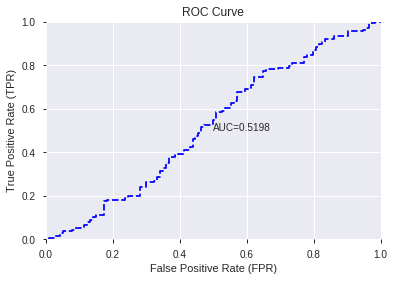

This function is available for GLM models only


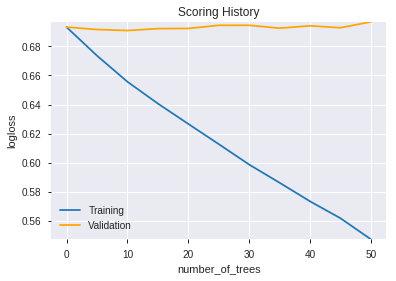

--2019-09-03 03:14:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_031318_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_031318_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_8',
 'BOP',
 'ADX_24',
 'Volume',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'BETA_8',
 'CCI_12',
 'WILLR_14',
 'ADX_8',
 'AROONOSC_30',
 'CORREL_24',
 'DX_24',
 'BETA_24',
 'DIV',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'WILLR_20',
 'PLUS_DM_8',
 'HT_DCPERIOD',
 'BETA_20',
 'DX_12',
 'ULTOSC',
 'STOCH_slowd',
 'CORREL_20',
 'BETA_14',
 'CORREL_12',
 'MINUS_DI_24',
 'PLUS_DI_14',
 'STOCHRSI_fastd',
 'dayofweek',
 'aroonup_30',
 'CORREL_14',
 'OBV',
 'MFI_30',
 'STDDEV_30',
 'MOM_24',
 'CMO_8',
 'DX_20',
 'WILLR_30',
 'MFI_20',
 'ROC_14',
 'ADX_12',
 'weekday_name',
 'MFI_12',
 'MINUS_DI_8',
 'LINEARREG_ANGLE_14',
 'STDDEV_12',
 'CMO_12',
 'MACDFIX_signal_20',
 'LINEARREG_ANGLE_12',
 'MFI_14',
 'dayofyear',
 'ADOSC',
 'TAN',
 'PLUS_DI_12',
 'WILLR_12',
 'DX_30',
 'MOM_12',
 'DX_8',
 'MACDFIX_hist_24',
 'WILLR_8',
 'STOCHF_fastk',
 'PLUS_DI_30',
 'STOCH_slowk',
 'LINEARREG_ANGLE_24',
 'MACDEXT_hist',
 'AD',
 'MACDFIX_signal_24',
 'aroonup_8',
 'SUB',
 'NATR_30',
 'MINUS_DI_20',
 'ROC_30',
 '

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

207

['BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'WMA_14',
 'MA_14_0',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_middleband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_middleband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_lowerband_14_2_5',
 'BBANDS_upperband_14_3_3',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_14_4_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_5_3',


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_031601_model_3  0.538161  0.858515              0.450282  0.563479  0.317508
1  DeepLearning_grid_1_AutoML_20190903_031601_model_4  0.507299  0.877361              0.486106  0.552422  0.305170
2  DeepLearning_grid_1_AutoML_20190903_031601_model_9  0.501409  0.691465              0.490492  0.499158  0.249159
3  DeepLearning_grid_1_AutoML_20190903_031601_model_5  0.500192  0.692276              0.486842  0.499501  0.249501
4  DeepLearning_grid_1_AutoML_20190903_031601_model_8  0.500000  0.688943              0.500000  0.497896  0.247901
5  DeepLearning_grid_1_AutoML_20190903_031601_model_1  0.490396  1.052008              0.495614  0.584995  0.342219
6  DeepLearning_grid_1_AutoML_20190903_031601_model_7  0.489371  0.849913              0.500000  0.551869  0.304559
7  DeepLearning_grid_1_AutoML_20190903_031601_model_2  0.483160  0.717665              0.494878  0.511544  0.261677
8               DeepLearning_1_AutoML_20190903_031601  0.478807  0.767081              0.486106  0.531519  0.282512
9  DeepLearning_grid_1_AutoML_20190903_031601_model_6  0.463984  0.701180              0.494878  0.503782  0.253797

variable  relative_importance  scaled_importance  percentage
0             CDLSHOOTINGSTAR             1.000000           1.000000    0.007263
1                     ADXR_14             0.966421           0.966421    0.007020
2                   CDLTAKURI             0.950964           0.950964    0.006907
3              CDLMATCHINGLOW             0.949956           0.949956    0.006900
4                      ADX_20             0.948095           0.948095    0.006886
..                        ...                  ...                ...         ...
202  BBANDS_middleband_20_3_5             0.580510           0.580510    0.004217
203                    RSI_14             0.570503           0.570503    0.004144
204   BBANDS_upperband_14_1_2             0.557799           0.557799    0.004052
205                   KAMA_14             0.556904           0.556904    0.004045
206       CDLXSIDEGAP3METHODS             0.555243           0.555243    0.004033

[207 rows x 4 columns]

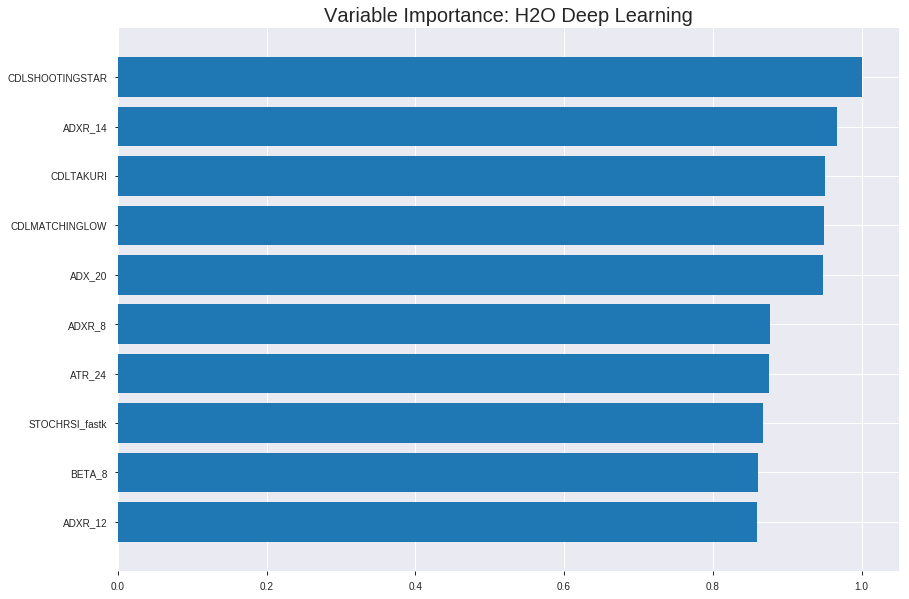

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_031601_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.31790883093623196
RMSE: 0.5638340455632597
LogLoss: 0.9567187735081297
Mean Per-Class Error: 0.4493618998169049
AUC: 0.5595970085353301
pr_auc: 0.5738569223277689
Gini: 0.11919401707066024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004033719466283015: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    851   1        (851.0/851.0)
1      0    903   0        (0.0/903.0)
Total  0    1754  0.4852   (851.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00403372   0.679714  399
max f2                       0.00403372   0.841409  399
max f0point5                 0.0957978    0.573191  352
max accuracy                 0.294209     0.551311  268
max precision                0.961475     0.875     5
max recall                   0.00403372   1         399
max specificity              0.987083     0.998825  0
max absolute_mcc             0.630382     0.103499  148
max min_per_class_accuracy   0.427049     0.547591  225
max mean_per_class_accuracy  0.449334     0.550638  216

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 44.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102623                   0.959299           1.61868   1.61868            0.833333         0.971691   0.833333                    0.971691            0.0166113       0.0166113                  61.8678    61.8678
    2        0.0205245                   0.948254           1.18703   1.40285            0.611111         0.95431    0.722222                    0.963               0.0121816       0.0287929                  18.7031    40.2855
    3        0.0302166                   0.942286           1.59964   1.46597            0.823529         0.945331   0.754717                    0.957333            0.0155039       0.0442968                  59.9635    46.5973
    4        0.0404789                   0.933992           0.863295  1.31318            0.444444         0.937952   0.676056                    0.952419            0.00885936      0.0531561                  -13.6705   31.3181
    5        0.050171                    0.927636           1.59964   1.36852            0.823529         0.930989   0.704545                    0.948279            0.0155039       0.06866                    59.9635    36.8519
    6        0.100342                    0.883448           1.0595    1.21401            0.545455         0.90414    0.625                       0.92621             0.0531561       0.121816                   5.94986    21.4009
    7        0.149943                    0.831715           1.07168   1.16693            0.551724         0.858215   0.60076                     0.903717            0.0531561       0.174972                   7.16768    16.6926
    8        0.200114                    0.78133            1.0595    1.13999            0.545455         0.806603   0.586895                    0.87937             0.0531561       0.228128                   5.94986    13.9992
    9        0.299886                    0.676124           1.07665   1.11892            0.554286         0.733376   0.576046                    0.830798            0.10742         0.335548                   7.66524    11.8919
    10       0.400228                    0.562394           1.07054   1.10679            0.551136         0.621217   0.569801                    0.778253            0.10742         0.442968                   7.05351    10.6789
    11       0.5                         0.427484           1.04335   1.09413            0.537143         0.497824   0.563284                    0.722295            0.104097        0.547065                   4.33539    9.41307
    12       0.599772                    0.292978           0.998956  1.0783             0.514286         0.359687   0.555133                    0.661975            0.0996678       0.646733                   -0.104414  7.82984
    13       0.700114                    0.190786           0.860843  1.04713            0.443182         0.234598   0.539088                    0.600723            0.0863787       0.733112                   -13.9157   4.71321
    14       0.799886                    0.105821           0.89906   1.02866            0.462857         0.144746   0.529579                    0.543847            0.089701        0.822813                   -10.094    2.86627
    15       0.899658                    0.0526988          0.876861  1.01183            0.451429         0.0776174  0.520913                    0.492143            0.0874862       0.910299                   -12.3139   1.18279
    16       1                           0.00337648         0.893952  1                  0.460227         0.0287648  0.514823  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27474635151527477
RMSE: 0.5241625239515648
LogLoss: 0.7746972263565083
Mean Per-Class Error: 0.4343061612434307
AUC: 0.5739764540502548
pr_auc: 0.6095055419415017
Gini: 0.14795290810050954
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.061522851260702636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    229  0.9913   (229.0/231.0)
1      0    271  0        (0.0/271.0)
Total  2    500  0.4562   (229.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0615229    0.702983  397
max f2                       0.0615229    0.855429  397
max f0point5                 0.427323     0.614035  294
max accuracy                 0.427323     0.579681  294
max precision                0.956378     1         0
max recall                   0.0615229    1         397
max specificity              0.956378     1         0
max absolute_mcc             0.427323     0.138464  294
max min_per_class_accuracy   0.602944     0.549815  197
max mean_per_class_accuracy  0.573228     0.565694  217

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 59.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.935538           1.54367   1.54367            0.833333         0.943119  0.833333                    0.943119            0.0184502       0.0184502                  54.3665    54.3665
    2        0.0219124                   0.924021           1.48192   1.5156             0.8              0.927691  0.818182                    0.936106            0.0147601       0.0332103                  48.1919    51.5599
    3        0.0318725                   0.920261           0.740959  1.27352            0.4              0.921597  0.6875                      0.931572            0.00738007      0.0405904                  -25.9041   27.3524
    4        0.0418327                   0.91614            1.11144   1.23493            0.6              0.917513  0.666667                    0.928224            0.0110701       0.0516605                  11.1439    23.4932
    5        0.0517928                   0.911341           1.48192   1.28243            0.8              0.91394   0.692308                    0.925477            0.0147601       0.0664207                  48.1919    28.243
    6        0.101594                    0.878935           1.25963   1.27125            0.68             0.900542  0.686275                    0.913254            0.0627306       0.129151                   25.9631    27.1254
    7        0.151394                    0.855213           1.03734   1.19431            0.56             0.868735  0.644737                    0.898609            0.0516605       0.180812                   3.73432    19.431
    8        0.201195                    0.822277           1.18554   1.19214            0.64             0.838171  0.643564                    0.88365             0.0590406       0.239852                   18.5535    19.2138
    9        0.300797                    0.742994           0.815055  1.06728            0.44             0.787129  0.576159                    0.851689            0.0811808       0.321033                   -18.4945   6.7276
    10       0.400398                    0.665198           1.29668   1.12434            0.7              0.700506  0.606965                    0.814082            0.129151        0.450185                   29.6679    12.4341
    11       0.5                         0.604148           0.963247  1.09225            0.52             0.63504   0.589641                    0.778416            0.095941        0.546125                   -3.67528   9.22509
    12       0.599602                    0.543081           1.0003    1.07698            0.54             0.575551  0.581395                    0.744717            0.099631        0.645756                   0.0295203  7.69759
    13       0.699203                    0.468338           1.0003    1.06605            0.54             0.508492  0.575499                    0.711067            0.099631        0.745387                   0.0295203  6.60527
    14       0.798805                    0.379959           0.852103  1.03938            0.46             0.426407  0.561097                    0.675573            0.0848708       0.830258                   -14.7897   3.93757
    15       0.898406                    0.31774            0.852103  1.01861            0.46             0.34879   0.549889                    0.639345            0.0848708       0.915129                   -14.7897   1.86138
    16       1                           0.0445849          0.835395  1                  0.45098          0.198628  0.539841                    0.5


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:17:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 03:17:21  1 min 18.588 sec  2059 obs/sec      2         1             3508       0.638532         2.06375             -0.632328      0.534676        0.537741           1.07912          0.485177                         0.607913           1.71282               -0.487676        0.554863          0.591959             1.54367            0.460159
    2019-09-03 03:17:27  1 min 24.961 sec  2232 obs/sec      10        5             17540      0.60164          1.37614             -0.449157      0.552544        0.565402           1.61868          0.485177                         0.573127           1.05833               -0.322293        0.564416          0.590253             1.23493            0.458167
    2019-09-03 03:17:33  1 min 30.835 sec  2335 obs/sec      18        9             31572      0.563834         0.956719            -0.272754      0.559597        0.573857           1.61868          0.485177                         0.524163           0.774697              -0.106008        0.573976          0.609506             1.54367            0.456175
    2019-09-03 03:17:38  1 min 36.365 sec  2421 obs/sec      26        13            45604      0.570323         1.01057             -0.302218      0.558961        0.568744           1.51077          0.484036                         0.53059            0.797355              -0.133299        0.561908          0.595937             0.926199           0.450199
    2019-09-03 03:17:44  1 min 41.608 sec  2499 obs/sec      34        17            59636      0.566933         1.00183             -0.286782      0.56527         0.573795           1.51077          0.485177                         0.535032           0.82347               -0.152352        0.566085          0.592266             1.23493            0.456175
    2019-09-03 03:17:49  1 min 46.651 sec  2568 obs/sec      42        21            73668      0.543376         0.875366            -0.182067      0.583505        0.580939           1.51077          0.485177                         0.52606            0.779733              -0.114029        0.555782          0.587272             1.23493            0.456175
    2019-09-03 03:17:55  1 min 52.545 sec  2655 obs/sec      52        26            91208      0.54271          0.89087             -0.179171      0.594459        0.609548           1.72659          0.485177                         0.527485           0.785009              -0.120072        0.566868          0.590166             1.23493            0.456175
    2019-09-03 03:18:00  1 min 58.216 sec  2732 obs/sec      62        31            108748     0.520026         0.784475            -0.0826588     0.618491        0.62029            1.61868          0.468073                         0.52437            0.779619              -0.106883        0.572523          0.589129             1.23493            0.458167
    2019-09-03 03:18:01

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSHOOTINGSTAR           1.0                    1.0                  0.007263477546979795
ADXR_14                   0.9664205312728882     0.9664205312728882   0.007019573829840908
CDLTAKURI                 0.9509637951850891     0.9509637951850891   0.006907304174317587
CDLMATCHINGLOW            0.9499555230140686     0.9499555230140686   0.006899980612042135
ADX_20                    0.9480951428413391     0.9480951428413391   0.006886467782428668
---                       ---                    ---                  ---
BBANDS_middleband_20_3_5  0.5805103182792664     0.5805103182792664   0.004216523662611545
RSI_14                    0.5705029964447021     0.5705029964447021   0.004143835705160788
BBANDS_upperband_14_1_2   0.5577986836433411     0.5577986836433411   0.004051558214378293
KAMA_14                   0.5569039583206177     0.5569039583206177   0.004045059397085978
CDLXSIDEGAP3METHODS       0.5552434921264648     0.5552434921264648   0.0040329986381672294


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.7238605898123325)

('auc', 0.5381610961710847)

('logloss', 0.8585154909010243)

('mean_per_class_error', 0.4397810218978102)

('rmse', 0.5634785940965511)

('mse', 0.3175081260050258)

deeplearning prediction progress: |███████████████████████████████████████| 100%


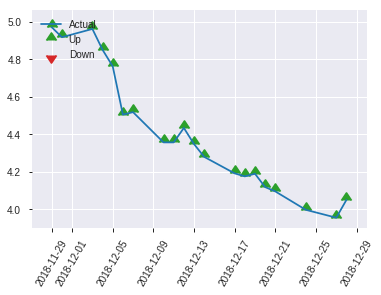


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3175081260050258
RMSE: 0.5634785940965511
LogLoss: 0.8585154909010243
Mean Per-Class Error: 0.4397810218978102
AUC: 0.5381610961710847
pr_auc: 0.5389816045698932
Gini: 0.0763221923421693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13147890950998678: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   101  0.886    (101.0/114.0)
1      2    135  0.0146   (2.0/137.0)
Total  15   236  0.4104   (103.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.131479     0.723861  235
max f2                       0.124479     0.864041  238
max f0point5                 0.131479     0.624422  235
max accuracy                 0.148217     0.589641  227
max precision                0.92477      1         0
max recall                   0.0847935    1         248
max specificity              0.92477      1         0
max absolute_mcc             0.131479     0.208861  235
max min_per_class_accuracy   0.309697     0.532847  124
max mean_per_class_accuracy  0.282873     0.560219  141

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 35.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.896276           1.22141   1.22141            0.666667         0.908883  0.666667                    0.908883            0.0145985       0.0145985                  22.1411   22.1411
    2        0.0239044                   0.888099           0         0.610706           0                0.890591  0.333333                    0.899737            0               0.0145985                  -100      -38.9294
    3        0.0318725                   0.863795           0.916058  0.687044           0.5              0.882124  0.375                       0.895334            0.00729927      0.0218978                  -8.39416  -31.2956
    4        0.0438247                   0.791193           0.610706  0.666224           0.333333         0.818362  0.363636                    0.874342            0.00729927      0.0291971                  -38.9294  -33.3776
    5        0.0517928                   0.715715           0         0.563728           0                0.76077   0.307692                    0.856869            0               0.0291971                  -100      -43.6272
    6        0.103586                    0.598858           1.12746   0.845592           0.615385         0.654116  0.461538                    0.755492            0.0583942       0.0875912                  12.7456   -15.4408
    7        0.151394                    0.550923           0.458029  0.723204           0.25             0.578781  0.394737                    0.699689            0.0218978       0.109489                   -54.1971  -27.6796
    8        0.203187                    0.513291           1.12746   0.826249           0.615385         0.52789   0.45098                     0.655897            0.0583942       0.167883                   12.7456   -17.3751
    9        0.302789                    0.424939           1.46569   1.03659            0.8              0.460961  0.565789                    0.591774            0.145985        0.313869                   46.5693   3.65924
    10       0.40239                     0.364365           1.09927   1.05211            0.6              0.397044  0.574257                    0.543573            0.109489        0.423358                   9.92701   5.21067
    11       0.501992                    0.307257           1.09927   1.06146            0.6              0.334493  0.579365                    0.502089            0.109489        0.532847                   9.92701   6.14645
    12       0.601594                    0.26335            1.17255   1.07986            0.64             0.285387  0.589404                    0.466211            0.116788        0.649635                   17.2555   7.98569
    13       0.701195                    0.233361           0.952701  1.06179            0.52             0.247199  0.579545                    0.435102            0.0948905       0.744526                   -4.72993  6.1795
    14       0.800797                    0.199848           0.952701  1.04823            0.52             0.218396  0.572139                    0.408148            0.0948905       0.839416                   -4.72993  4.8226
    15       0.900398                    0.153224           1.02599   1.04577            0.56             0.173407  0.570796                    0.382181            0.10219         0.941606                   2.59854   4.57658
    16       1                           0.0808319          0.586277  1                  0.32             0.120887  0.545817                    0.356156    

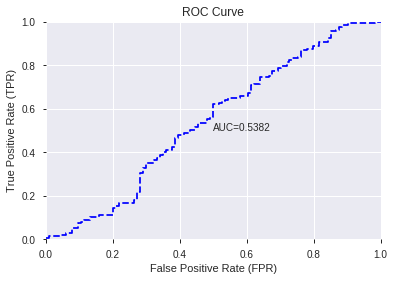

This function is available for GLM models only


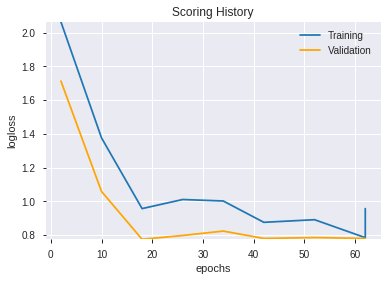

--2019-09-03 03:26:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_031601_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_031601_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSHOOTINGSTAR',
 'ADXR_14',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'ADX_20',
 'ADXR_8',
 'ATR_24',
 'STOCHRSI_fastk',
 'BETA_8',
 'ADXR_12',
 'ADX_12',
 'aroondown_12',
 'BOP',
 'aroondown_14',
 'AD',
 'DX_12',
 'DX_8',
 'AROONOSC_24',
 'aroondown_30',
 'aroonup_24',
 'ATR_14',
 'aroonup_8',
 'AROONOSC_30',
 'PLUS_DM_24',
 'CORREL_8',
 'ATR_8',
 'STOCHF_fastk',
 'NATR_20',
 'OBV',
 'DX_30',
 'AROONOSC_12',
 'HT_DCPERIOD',
 'MFI_20',
 'TRANGE',
 'CCI_8',
 'CDLRICKSHAWMAN',
 'ROCR_30',
 'STOCHRSI_fastd',
 'MACDFIX_signal_12',
 'AROONOSC_14',
 'MACDFIX_signal_20',
 'ROCP_24',
 'MINUS_DI_30',
 'STOCH_slowd',
 'PLUS_DM_12',
 'PLUS_DM_8',
 'NATR_12',
 'PLUS_DI_30',
 'PLUS_DI_8',
 'MFI_14',
 'APO',
 'HT_TRENDMODE',
 'ROCP_14',
 'KAMA_20',
 'LINEARREG_ANGLE_8',
 'MINUS_DM_14',
 'MFI_8',
 'WILLR_8',
 'LINEARREG_SLOPE_8',
 'ROCP_20',
 'CCI_30',
 'BBANDS_upperband_20_0_5',
 'MFI_12',
 'STOCHF_fastd',
 'MOM_30',
 'BBANDS_lowerband_20_2_5',
 'WILLR_14',
 'BBANDS_upperband_30_0_4',
 'BBANDS_middleban

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190903_032629_model_1  0.42323  0.701193                   0.5  0.503954  0.25397

variable  relative_importance  scaled_importance  percentage
0                      BETA_8             0.054649           1.000000    0.050067
1         CDLXSIDEGAP3METHODS             0.039283           0.718827    0.035989
2                aroondown_14             0.037773           0.691200    0.034606
3                  aroonup_24             0.032760           0.599468    0.030013
4                      ADXR_8             0.028774           0.526526    0.026361
..                        ...                  ...                ...         ...
202  BBANDS_middleband_12_7_4             0.000094           0.001713    0.000086
203   BBANDS_upperband_14_7_5             0.000080           0.001463    0.000073
204   BBANDS_upperband_14_7_4             0.000070           0.001276    0.000064
205               AROONOSC_12             0.000069           0.001257    0.000063
206   BBANDS_lowerband_20_5_5             0.000013           0.000239    0.000012

[207 rows x 4 columns]

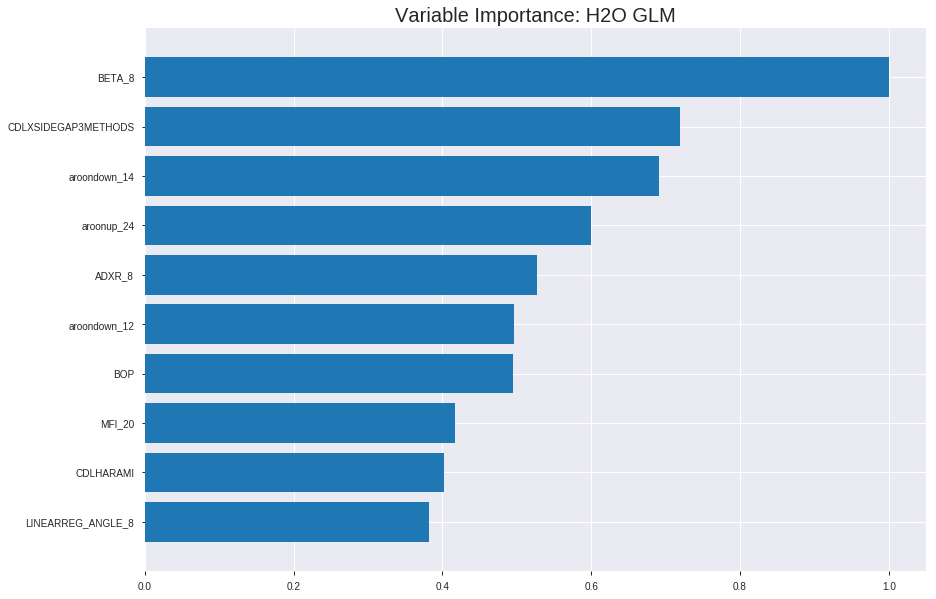

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_032629_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24546923907900448
RMSE: 0.4954485231373735
LogLoss: 0.6840420366155978
Null degrees of freedom: 1753
Residual degrees of freedom: 1546
Null deviance: 2430.0184643429493
Residual deviance: 2399.6194644475167
AIC: 2815.6194644475167
AUC: 0.5875310526473317
pr_auc: 0.5868509001348216
Gini: 0.17506210529466348
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4503580970856238: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      52   799   0.9389   (799.0/851.0)
1      17   886   0.0188   (17.0/903.0)
Total  69   1685  0.4652   (816.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450358     0.684699  361
max f2                       0.405984     0.84188   396
max f0point5                 0.493028     0.591036  264
max accuracy                 0.504387     0.570696  229
max precision                0.636555     1         0
max recall                   0.405984     1         396
max specificity              0.636555     1         0
max absolute_mcc             0.504136     0.138664  230
max min_per_class_accuracy   0.517237     0.562569  190
max mean_per_class_accuracy  0.504387     0.566715  229

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.595331           1.40285   1.40285            0.722222         0.612093  0.722222                    0.612093            0.0143965       0.0143965                  40.2855   40.2855
    2        0.0205245                   0.581743           1.40285   1.40285            0.722222         0.58906   0.722222                    0.600576            0.0143965       0.0287929                  40.2855   40.2855
    3        0.0302166                   0.573851           1.25686   1.35602            0.647059         0.577459  0.698113                    0.593161            0.0121816       0.0409745                  25.6856   35.6025
    4        0.0404789                   0.570165           1.40285   1.3679             0.722222         0.572064  0.704225                    0.587813            0.0143965       0.055371                   40.2855   36.7897
    5        0.050171                    0.567154           1.02834   1.3023             0.529412         0.568485  0.670455                    0.584079            0.00996678      0.0653378                  2.83369   30.23
    6        0.100342                    0.556597           1.10364   1.20297            0.568182         0.561463  0.619318                    0.572771            0.055371        0.120709                   10.3644   20.2972
    7        0.149943                    0.549697           1.16098   1.18908            0.597701         0.553169  0.612167                    0.566287            0.0575858       0.178295                   16.0983   18.9082
    8        0.200114                    0.543298           1.28023   1.21193            0.659091         0.5466    0.623932                    0.561351            0.0642303       0.242525                   28.0228   21.1934
    9        0.299886                    0.535041           1.02115   1.14846            0.525714         0.53936   0.591255                    0.554035            0.101883        0.344408                   2.11549   14.8462
    10       0.400228                    0.525761           1.0595    1.12616            0.545455         0.53059   0.579772                    0.548157            0.106312        0.45072                    5.94986   12.6158
    11       0.5                         0.516789           1.12105   1.12514            0.577143         0.521566  0.579247                    0.542851            0.111849        0.562569                   12.105    12.5138
    12       0.599772                    0.508292           0.965657  1.09861            0.497143         0.51308   0.565589                    0.537898            0.0963455       0.658915                   -3.43427  9.86088
    13       0.700114                    0.497558           0.960171  1.07877            0.494318         0.502842  0.555375                    0.532874            0.0963455       0.75526                    -3.98294  7.87675
    14       0.799886                    0.484964           0.91016   1.05774            0.468571         0.491423  0.544547                    0.527704            0.0908084       0.846069                   -8.98402  5.77366
    15       0.899658                    0.467422           0.821364  1.03152            0.422857         0.477166  0.531052                    0.522099            0.0819491       0.928018                   -17.8636  3.15229
    16       1                           0.35569            0.717369  1                  0.369318         0.449589  0.514823                    0.514823           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24703316348186222
RMSE: 0.49702430874340764
LogLoss: 0.6871285059229536
Null degrees of freedom: 501
Residual degrees of freedom: 294
Null deviance: 693.9887622709523
Residual deviance: 689.8770199466454
AIC: 1105.8770199466453
AUC: 0.5360058146036006
pr_auc: 0.5949764774896298
Gini: 0.07201162920720128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.429552611234888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    231  1        (231.0/231.0)
1      0    271  0        (0.0/271.0)
Total  0    502  0.4602   (231.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429553     0.701164  399
max f2                       0.429553     0.854351  399
max f0point5                 0.489        0.600191  357
max accuracy                 0.512476     0.559761  290
max precision                0.646074     1         0
max recall                   0.429553     1         399
max specificity              0.646074     1         0
max absolute_mcc             0.605239     0.144766  15
max min_per_class_accuracy   0.534312     0.515152  199
max mean_per_class_accuracy  0.512476     0.540495  290

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 53.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.625752           1.54367   1.54367            0.833333         0.632593  0.833333                    0.632593            0.0184502       0.0184502                  54.3665    54.3665
    2        0.0219124                   0.613317           1.8524    1.684              1                0.617194  0.909091                    0.625594            0.0184502       0.0369004                  85.2399    68.3999
    3        0.0318725                   0.605207           1.8524    1.73662            1                0.608965  0.9375                      0.620397            0.0184502       0.0553506                  85.2399    73.6624
    4        0.0418327                   0.600495           0.37048   1.41135            0.2              0.60251   0.761905                    0.616139            0.00369004      0.0590406                  -62.952    41.1351
    5        0.0517928                   0.597033           1.48192   1.42492            0.8              0.598835  0.769231                    0.612811            0.0147601       0.0738007                  48.1919    42.4922
    6        0.101594                    0.585873           1.18554   1.30758            0.64             0.591666  0.705882                    0.602446            0.0590406       0.132841                   18.5535    30.7575
    7        0.151394                    0.575084           0.889151  1.16994            0.48             0.580847  0.631579                    0.595341            0.0442804       0.177122                   -11.0849   16.9936
    8        0.201195                    0.56723            1.03734   1.13712            0.56             0.571541  0.613861                    0.58945             0.0516605       0.228782                   3.73432    13.7116
    9        0.300797                    0.552842           0.815055  1.03047            0.44             0.559331  0.556291                    0.579477            0.0811808       0.309963                   -18.4945   3.04734
    10       0.400398                    0.542612           0.815055  0.976887           0.44             0.547863  0.527363                    0.571613            0.0811808       0.391144                   -18.4945   -2.31132
    11       0.5                         0.534411           1.22258   1.02583            0.66             0.538695  0.553785                    0.565055            0.121771        0.512915                   22.2583    2.58303
    12       0.599602                    0.526304           1.07439   1.0339             0.58             0.530055  0.55814                     0.559241            0.107011        0.619926                   7.43911    3.38969
    13       0.699203                    0.516995           1.14849   1.05022            0.62             0.521623  0.566952                    0.553883            0.114391        0.734317                   14.8487    5.02202
    14       0.798805                    0.504427           0.815055  1.0209             0.44             0.511612  0.551122                    0.548612            0.0811808       0.815498                   -18.4945   2.08979
    15       0.898406                    0.490172           1.0003    1.01861            0.54             0.497481  0.549889                    0.542943            0.099631        0.915129                   0.0295203  1.86138
    16       1                           0.429553           0.835395  1                  0.45098          0.471348  0.539841                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 03:26:30  0.000 sec   2            3.1       208           1.38091           1.37781
    2019-09-03 03:26:30  0.116 sec   4            2.3       208           1.37979           1.37702
    2019-09-03 03:26:30  0.236 sec   6            1.7       208           1.37847           1.37644
    2019-09-03 03:26:30  0.355 sec   8            1.2       208           1.37689           1.37578
    2019-09-03 03:26:30  0.476 sec   10           0.88      208           1.37505           1.37518
    2019-09-03 03:26:31  0.591 sec   12           0.64      208           1.37296           1.37468
    2019-09-03 03:26:31  0.709 sec   14           0.47      208           1.37063           1.37434
    2019-09-03 03:26:31  0.833 sec   16           0.34      208           1.36808           1.37426
    2019-09-03 03:26:31  0.958 sec   18           0.25      208           1.36534           1.3745
    2019-09-03 03:26:31  1.100 sec   20           0.18      208           1.36243           1.37518
    2019-09-03 03:26:31  1.246 sec   22           0.13      208           1.35939           1.37634
    2019-09-03 03:26:31  1.385 sec   24           0.095     208           1.35627           1.37803
    2019-09-03 03:26:31  1.515 sec   26           0.069     208           1.35313           1.38029

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7061855670103092)

('auc', 0.423229606863875)

('logloss', 0.7011926400938845)

('mean_per_class_error', 0.4934370598027916)

('rmse', 0.5039544739717268)

('mse', 0.25397011183611984)

glm prediction progress: |████████████████████████████████████████████████| 100%


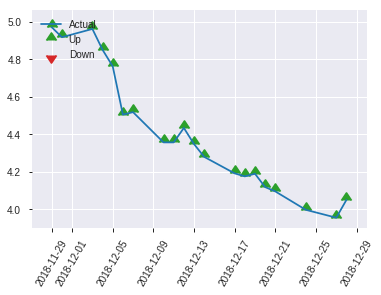


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25397011183611984
RMSE: 0.5039544739717268
LogLoss: 0.7011926400938845
Null degrees of freedom: 250
Residual degrees of freedom: 43
Null deviance: 346.81644986094483
Residual deviance: 351.99870532713004
AIC: 767.99870532713
AUC: 0.423229606863875
pr_auc: 0.4855762657832835
Gini: -0.15354078627224998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4493065267823478: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    114  1        (114.0/114.0)
1      0    137  0        (0.0/137.0)
Total  0    251  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449307     0.706186  250
max f2                       0.449307     0.857322  250
max f0point5                 0.449307     0.600351  250
max accuracy                 0.460848     0.545817  246
max precision                0.635195     1         0
max recall                   0.449307     1         250
max specificity              0.635195     1         0
max absolute_mcc             0.520612     0.177042  131
max min_per_class_accuracy   0.523853     0.421053  123
max mean_per_class_accuracy  0.609325     0.506563  3

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 52.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.611193           1.22141   1.22141            0.666667         0.624797  0.666667                    0.624797            0.0145985       0.0145985                  22.1411   22.1411
    2        0.0239044                   0.605498           0.610706  0.916058           0.333333         0.607762  0.5                         0.61628             0.00729927      0.0218978                  -38.9294  -8.39416
    3        0.0318725                   0.600839           0         0.687044           0                0.602672  0.375                       0.612878            0               0.0218978                  -100      -31.2956
    4        0.0438247                   0.598389           0         0.499668           0                0.599347  0.272727                    0.609188            0               0.0218978                  -100      -50.0332
    5        0.0517928                   0.593831           0         0.422796           0                0.595822  0.230769                    0.607131            0               0.0218978                  -100      -57.7204
    6        0.103586                    0.574242           0.986524  0.70466            0.538462         0.582227  0.384615                    0.594679            0.0510949       0.0729927                  -1.34756  -29.534
    7        0.151394                    0.558518           1.22141   0.867845           0.666667         0.565667  0.473684                    0.585517            0.0583942       0.131387                   22.1411   -13.2155
    8        0.203187                    0.547911           0.845592  0.862173           0.461538         0.552373  0.470588                    0.577069            0.0437956       0.175182                   -15.4408  -13.7827
    9        0.302789                    0.538071           0.806131  0.843738           0.44             0.542638  0.460526                    0.565743            0.080292        0.255474                   -19.3869  -15.6262
    10       0.40239                     0.530681           0.879416  0.852569           0.48             0.534476  0.465347                    0.558004            0.0875912       0.343066                   -12.0584  -14.7431
    11       0.501992                    0.523539           0.806131  0.843355           0.44             0.527236  0.460317                    0.551899            0.080292        0.423358                   -19.3869  -15.6645
    12       0.601594                    0.514776           1.31912   0.922125           0.72             0.518218  0.503311                    0.546323            0.131387        0.554745                   31.9124   -7.7875
    13       0.701195                    0.509903           1.24584   0.968107           0.68             0.512432  0.528409                    0.541509            0.124088        0.678832                   24.5839   -3.18928
    14       0.800797                    0.496222           1.02599   0.975306           0.56             0.502782  0.532338                    0.536692            0.10219         0.781022                   2.59854   -2.4694
    15       0.900398                    0.487603           1.17255   0.997126           0.64             0.492504  0.544248                    0.531804            0.116788        0.89781                    17.2555   -0.287449
    16       1                           0.449307           1.02599   1                  0.56             0.473423  0.545817                    0.525

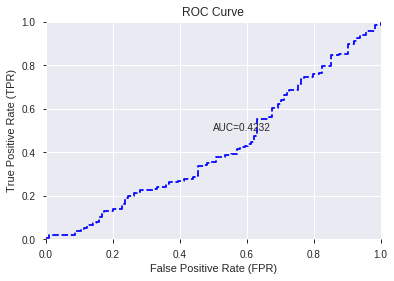

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


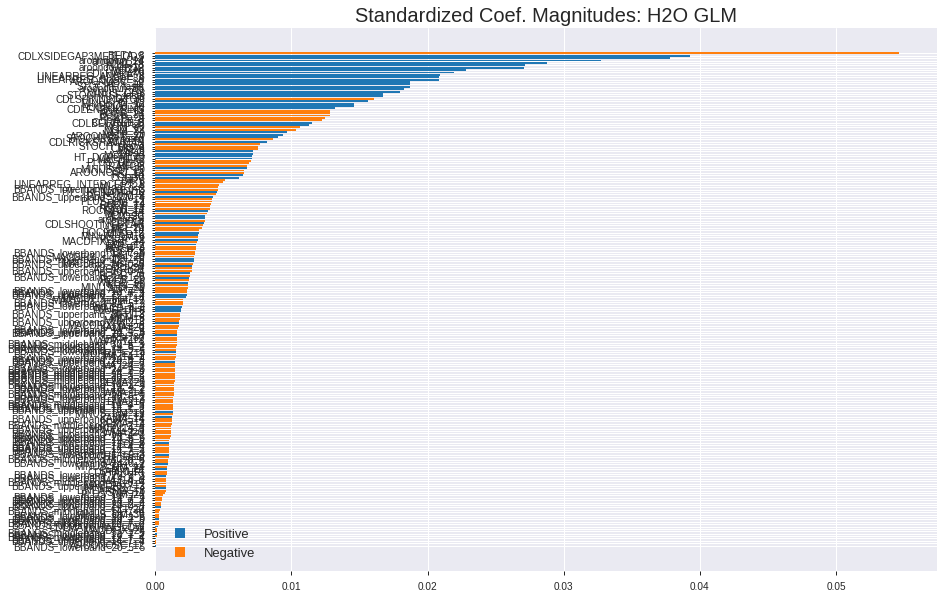

'log_likelihood'
--2019-09-03 03:26:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.72.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.72.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_032629_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_032629_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BETA_8',
 'CDLXSIDEGAP3METHODS',
 'aroondown_14',
 'aroonup_24',
 'ADXR_8',
 'aroondown_12',
 'BOP',
 'MFI_20',
 'CDLHARAMI',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'AROONOSC_30',
 'ADX_12',
 'STOCHF_fastk',
 'aroondown_30',
 'AD',
 'MINUS_DI_8',
 'STOCHRSI_fastk',
 'DX_30',
 'CDLSPINNINGTOP',
 'MINUS_DI_12',
 'ROCR_30',
 'ROCR100_30',
 'CDLENGULFING',
 'ADXR_14',
 'ROCR_24',
 'ROCP_24',
 'ATR_8',
 'CORREL_8',
 'CDLBELTHOLD',
 'MOM_30',
 'CCI_12',
 'MOM_24',
 'NATR_20',
 'AROONOSC_24',
 'STOCHRSI_fastd',
 'ATR_14',
 'CDLRICKSHAWMAN',
 'STOCH_slowd',
 'CMO_8',
 'RSI_8',
 'APO',
 'MOM_20',
 'HT_DCPERIOD',
 'MACDEXT',
 'PLUS_DI_30',
 'MFI_8',
 'TRANGE',
 'MINUS_DI_20',
 'AROONOSC_14',
 'RSI_14',
 'CCI_30',
 'OBV',
 'DX_8',
 'LINEARREG_INTERCEPT_8',
 'WILLR_24',
 'BBANDS_lowerband_30_0_3',
 'HT_TRENDMODE',
 'NATR_12',
 'PLUS_DM_8',
 'BBANDS_upperband_30_0_4',
 'PLUS_DM_12',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'MOM_14',
 'ADX_20',
 'ULTOSC',
 'aroonup_8',
 'CCI_14',
 

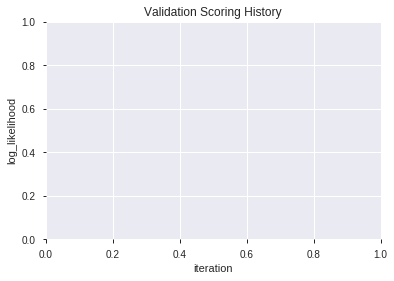

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_032649_model_7  0.520617  0.703761              0.458317  0.504537  0.254557
1  XGBoost_grid_1_AutoML_20190903_032649_model_1  0.515815  0.700408              0.491228  0.503055  0.253065
2  XGBoost_grid_1_AutoML_20190903_032649_model_6  0.500576  0.701606              0.491228  0.503837  0.253851
3  XGBoost_grid_1_AutoML_20190903_032649_model_5  0.497631  0.728216              0.480983  0.514357  0.264563
4               XGBoost_1_AutoML_20190903_032649  0.482008  0.719993              0.495614  0.511468  0.261599
5  XGBoost_grid_1_AutoML_20190903_032649_model_2  0.469010  0.707103              0.480247  0.506740  0.256785
6  XGBoost_grid_1_AutoML_20190903_032649_model_3  0.467537  0.719748              0.500000  0.511800  0.261940
7               XGBoost_3_AutoML_20190903_032649  0.461135  0.712451              0.500000  0.509078  0.259161
8  XGBoost_grid_1_AutoML_20190903_032649_model_4  0.458894  0.705911              0.480983  0.506151  0.256189
9               XGBoost_2_AutoML_20190903_032649  0.427007  0.726234              0.495614  0.515746  0.265994

variable  relative_importance  scaled_importance  percentage
0                      BETA_8           243.022522           1.000000    0.026722
1                      MFI_14           189.941818           0.781581    0.020885
2                      ADXR_8           179.816681           0.739918    0.019772
3                       CMO_8           166.009872           0.683105    0.018254
4                      CCI_12           153.453293           0.631437    0.016873
..                        ...                  ...                ...         ...
173               MIDPRICE_14             3.725888           0.015331    0.000410
174  BBANDS_middleband_14_5_4             3.705366           0.015247    0.000407
175   BBANDS_lowerband_24_2_2             3.278728           0.013491    0.000361
176                   ROCR_20             2.727094           0.011222    0.000300
177   BBANDS_lowerband_14_4_3             2.407679           0.009907    0.000265

[178 rows x 4 columns]

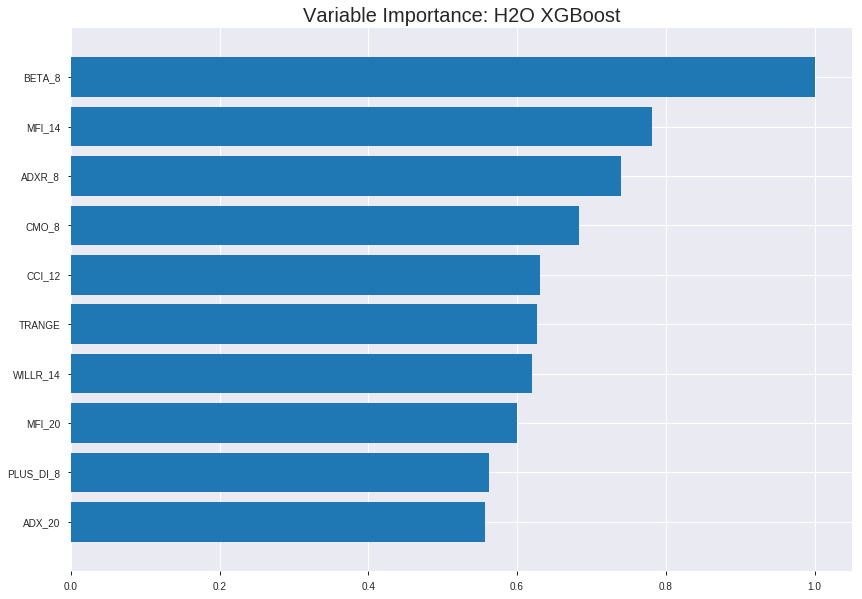

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_032649_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13952720019092502
RMSE: 0.3735333990300265
LogLoss: 0.46068232740387954
Mean Per-Class Error: 0.07241887272220948
AUC: 0.9774761761617171
pr_auc: 0.9785889681995945
Gini: 0.9549523523234342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48193155725797016: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      757  94   0.1105   (94.0/851.0)
1      35   868  0.0388   (35.0/903.0)
Total  792  962  0.0735   (129.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481932     0.930831  213
max f2                       0.469621     0.952226  220
max f0point5                 0.551182     0.941693  171
max accuracy                 0.509608     0.927594  197
max precision                0.842889     1         0
max recall                   0.317925     1         329
max specificity              0.842889     1         0
max absolute_mcc             0.509608     0.85508   197
max min_per_class_accuracy   0.509608     0.927145  197
max mean_per_class_accuracy  0.509608     0.927581  197

Gains/Lift Table: Avg response rate: 51.48 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.796717           1.94241    1.94241            1                0.81141   1                           0.81141             0.0199336       0.0199336                  94.2414   94.2414
    2        0.0205245                   0.784606           1.94241    1.94241            1                0.791665  1                           0.801537            0.0199336       0.0398671                  94.2414   94.2414
    3        0.0302166                   0.775761           1.94241    1.94241            1                0.779934  1                           0.794608            0.0188261       0.0586932                  94.2414   94.2414
    4        0.0404789                   0.763465           1.94241    1.94241            1                0.769498  1                           0.788242            0.0199336       0.0786268                  94.2414   94.2414
    5        0.050171                    0.756037           1.94241    1.94241            1                0.759404  1                           0.782671            0.0188261       0.0974529                  94.2414   94.2414
    6        0.100342                    0.72958            1.94241    1.94241            1                0.742092  1                           0.762381            0.0974529       0.194906                   94.2414   94.2414
    7        0.149943                    0.704994           1.94241    1.94241            1                0.718326  1                           0.747808            0.0963455       0.291251                   94.2414   94.2414
    8        0.200114                    0.681635           1.94241    1.94241            1                0.694542  1                           0.734453            0.0974529       0.388704                   94.2414   94.2414
    9        0.299886                    0.636395           1.88692    1.92395            0.971429         0.659461  0.990494                    0.709503            0.188261        0.576966                   88.6917   92.395
    10       0.400228                    0.588024           1.84309    1.90368            0.948864         0.612325  0.980057                    0.68514             0.184939        0.761905                   84.3086   90.3677
    11       0.5                         0.520067           1.47623    1.81838            0.76             0.554489  0.936146                    0.659069            0.147287        0.909192                   47.6235   81.8383
    12       0.599772                    0.446913           0.67707    1.62853            0.348571         0.481772  0.838403                    0.629576            0.0675526       0.976744                   -32.293   62.8526
    13       0.700114                    0.397538           0.15451    1.41727            0.0795455        0.421937  0.729642                    0.599817            0.0155039       0.992248                   -84.549   41.7266
    14       0.799886                    0.349657           0.0554975  1.24741            0.0285714        0.372951  0.642195                    0.571519            0.0055371       0.997785                   -94.4502  24.7409
    15       0.899658                    0.29463            0.022199   1.11153            0.0114286        0.322744  0.572243                    0.54393             0.00221484      1                          -97.7801  11.1534
    16       1                           0.165023           0          1                  0                0.247666  0.514823                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25298448056976564
RMSE: 0.5029756262183741
LogLoss: 0.7000803317806085
Mean Per-Class Error: 0.44769252887334066
AUC: 0.5413811280969952
pr_auc: 0.5561160527491296
Gini: 0.08276225619399047
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33051788806915283: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   215  0.9307   (215.0/231.0)
1      6    265  0.0221   (6.0/271.0)
Total  22   480  0.4402   (221.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330518     0.705726  377
max f2                       0.213585     0.85489   398
max f0point5                 0.414333     0.613625  320
max accuracy                 0.414333     0.577689  320
max precision                0.792208     1         0
max recall                   0.213585     1         398
max specificity              0.792208     1         0
max absolute_mcc             0.387486     0.136754  340
max min_per_class_accuracy   0.517255     0.538745  197
max mean_per_class_accuracy  0.414333     0.552307  320

Gains/Lift Table: Avg response rate: 53.98 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0119522                   0.756282           1.23493   1.23493            0.666667         0.778777  0.666667                    0.778777            0.0147601       0.0147601                  23.4932    23.4932
    2        0.0219124                   0.73173            1.48192   1.3472             0.8              0.738038  0.727273                    0.760259            0.0147601       0.0295203                  48.1919    34.7199
    3        0.0318725                   0.718767           0.37048   1.04197            0.2              0.726408  0.5625                      0.749681            0.00369004      0.0332103                  -62.952    4.19742
    4        0.0418327                   0.702167           0.740959  0.970304           0.4              0.711312  0.52381                     0.740545            0.00738007      0.0405904                  -25.9041   -2.9696
    5        0.0517928                   0.691535           0.740959  0.926199           0.4              0.696554  0.5                         0.732085            0.00738007      0.0479705                  -25.9041   -7.38007
    6        0.101594                    0.661634           0.963247  0.94436            0.52             0.675151  0.509804                    0.704177            0.0479705       0.095941                   -3.67528   -5.564
    7        0.151394                    0.631064           0.963247  0.950573           0.52             0.645937  0.513158                    0.685019            0.0479705       0.143911                   -3.67528   -4.94271
    8        0.201195                    0.607494           0.889151  0.93537            0.48             0.617411  0.50495                     0.668284            0.0442804       0.188192                   -11.0849   -6.46304
    9        0.300797                    0.568632           1.18554   1.01821            0.64             0.585577  0.549669                    0.640898            0.118081        0.306273                   18.5535    1.82058
    10       0.400398                    0.539935           1.22258   1.06905            0.66             0.553672  0.577114                    0.6192              0.121771        0.428044                   22.2583    6.90459
    11       0.5                         0.516979           1.11144   1.07749            0.6              0.52846   0.581673                    0.601124            0.110701        0.538745                   11.1439    7.74908
    12       0.599602                    0.483322           0.963247  1.05851            0.52             0.49803   0.571429                    0.583999            0.095941        0.634686                   -3.67528   5.85134
    13       0.699203                    0.456262           1.0003    1.05022            0.54             0.468293  0.566952                    0.567517            0.099631        0.734317                   0.0295203  5.02202
    14       0.798805                    0.422085           1.03734   1.04861            0.56             0.441202  0.566085                    0.551767            0.103321        0.837638                   3.73432    4.86146
    15       0.898406                    0.365629           0.889151  1.03094            0.48             0.396307  0.556541                    0.534532            0.0885609       0.926199                   -11.0849   3.09358
    16       1                           0.20719            0.726431  1                  0.392157         0.323224  0.539841                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 03:27:07  11.221 sec  0                  0.5              0.693147            0.5             0                  1                0.485177                         0.5                0.693147              0.5               0                    1                  0.460159
    2019-09-03 03:27:07  11.506 sec  5                  0.482448         0.658545            0.822194        0.833403           1.94241          0.263398                         0.499551           0.692245              0.52373           0.564884             1.54367            0.442231
    2019-09-03 03:27:07  11.621 sec  10                 0.466542         0.627954            0.880388        0.888815           1.94241          0.201824                         0.497928           0.689012              0.545351          0.56824              0.926199           0.460159
    2019-09-03 03:27:07  11.726 sec  15                 0.45419          0.604546            0.899844        0.906597           1.94241          0.18187                          0.498284           0.689743              0.541006          0.571835             1.23493            0.454183
    2019-09-03 03:27:08  11.842 sec  20                 0.440636         0.57943             0.924789        0.928321           1.94241          0.147092                         0.498784           0.690741              0.538306          0.5639               0.926199           0.444223
    2019-09-03 03:27:08  11.957 sec  25                 0.428408         0.556898            0.936958        0.942036           1.94241          0.13512                          0.498717           0.690584              0.53702           0.560081             1.23493            0.440239
    2019-09-03 03:27:08  12.187 sec  30                 0.415811         0.534143            0.949862        0.954567           1.94241          0.121437                         0.500263           0.69374               0.529848          0.553322             1.23493            0.446215
    2019-09-03 03:27:08  12.316 sec  35                 0.402986         0.511399            0.960119        0.963561           1.94241          0.104333                         0.501354           0.696215              0.530607          0.549047             0.617466           0.434263
    2019-09-03 03:27:08  12.432 sec  40                 0.393425         0.494683            0.965556        0.968563           1.94241          0.0957811                        0.501215           0.695938              0.537467          0.555685             1.23493            0.452191
    2019-09-03 03:27:08  12.560 sec  45                 0.382492         0.475812            0.972391        0.974288           1.94241          0.0843786                        0.503026           0.699887              0.534049          0.553375             1.54367            0.442231
    2019-09-03 03:27:08  12.675 sec  50                 0.373533         0.460682            0.977476        0.978589           1.94241          0.0735462                        0.502976           0.70008               0.541381          0.556116             1.23493            0.440239

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ----------------------
BETA_8                    243.02252197265625     1.0                   0.026721604324313277
MFI_14                    189.9418182373047      0.7815811336970491    0.02088510180200074
ADXR_8                    179.81668090820312     0.739917763376825     0.019771789705486376
CMO_8                     166.00987243652344     0.683104887106727     0.01825365850527065
CCI_12                    153.4532928466797      0.6314365088514122    0.016872996545453177
---                       ---                    ---                   ---
MIDPRICE_14               3.72588849067688       0.015331453481896214  0.00040968103365984575
BBANDS_middleband_14_5_4  3.7053658962249756     0.015247006187524817  0.00040742446647339445
BBANDS_lowerband_24_2_2   3.2787275314331055     0.013491455461901645  0.000360513334612031
ROCR_20                   2.7270936965942383     0.011221567756181371  0.0002998582934791506
BBANDS_lowerband_14_4_3   2.4076786041259766     0.009907224172403565  0.0002647369242872401


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5976095617529881)

('F1', 0.7184986595174262)

('auc', 0.5206172365219619)

('logloss', 0.703761264311099)

('mean_per_class_error', 0.43561915738250734)

('rmse', 0.5045368623121868)

('mse', 0.25455744543182646)

xgboost prediction progress: |████████████████████████████████████████████| 100%


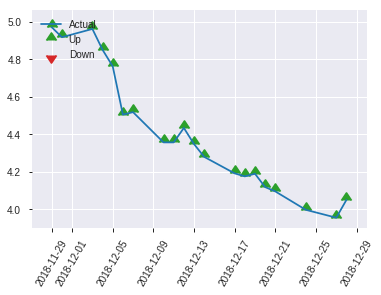


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25455744543182646
RMSE: 0.5045368623121868
LogLoss: 0.703761264311099
Mean Per-Class Error: 0.43561915738250734
AUC: 0.5206172365219619
pr_auc: 0.5521827944514085
Gini: 0.0412344730439238
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3833789825439453: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   102  0.8947   (102.0/114.0)
1      3    134  0.0219   (3.0/137.0)
Total  15   236  0.4183   (105.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383379     0.718499  235
max f2                       0.302311     0.857322  250
max f0point5                 0.425074     0.629336  217
max accuracy                 0.425074     0.59761   217
max precision                0.815527     1         0
max recall                   0.302311     1         250
max specificity              0.815527     1         0
max absolute_mcc             0.425074     0.18972   217
max min_per_class_accuracy   0.553604     0.518248  123
max mean_per_class_accuracy  0.425074     0.564381  217

Gains/Lift Table: Avg response rate: 54.58 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.791974           1.83212   1.83212            1                0.806341  1                           0.806341            0.0218978       0.0218978                  83.2117   83.2117
    2        0.0239044                   0.772067           0.610706  1.22141            0.333333         0.780198  0.666667                    0.79327             0.00729927      0.0291971                  -38.9294  22.1411
    3        0.0318725                   0.747872           0.916058  1.14507            0.5              0.750697  0.625                       0.782626            0.00729927      0.0364964                  -8.39416  14.5073
    4        0.0438247                   0.734756           0         0.83278            0                0.738604  0.454545                    0.77062             0               0.0364964                  -100      -16.722
    5        0.0517928                   0.720141           1.83212   0.986524           1                0.723156  0.538462                    0.763318            0.0145985       0.0510949                  83.2117   -1.34756
    6        0.103586                    0.676015           0.563728  0.775126           0.307692         0.702612  0.423077                    0.732965            0.0291971       0.080292                   -43.6272  -22.4874
    7        0.151394                    0.657814           1.37409   0.964272           0.75             0.667375  0.526316                    0.712252            0.0656934       0.145985                   37.4088   -3.5728
    8        0.203187                    0.639044           0.845592  0.93402            0.461538         0.647955  0.509804                    0.695863            0.0437956       0.189781                   -15.4408  -6.59797
    9        0.302789                    0.60224            1.02599   0.964272           0.56             0.618701  0.526316                    0.670481            0.10219         0.291971                   2.59854   -3.5728
    10       0.40239                     0.583374           1.24584   1.03397            0.68             0.591772  0.564356                    0.650998            0.124088        0.416058                   24.5839   3.39669
    11       0.501992                    0.553144           1.02599   1.03238            0.56             0.566588  0.563492                    0.63425             0.10219         0.518248                   2.59854   3.23833
    12       0.601594                    0.521682           0.806131  0.994924           0.44             0.539239  0.543046                    0.61852             0.080292        0.59854                    -19.3869  -0.507565
    13       0.701195                    0.49629            1.02599   0.999336           0.56             0.510354  0.545455                    0.603156            0.10219         0.70073                    2.59854   -0.066357
    14       0.800797                    0.453907           1.24584   1.03               0.68             0.470969  0.562189                    0.586714            0.124088        0.824818                   24.5839   2.9996
    15       0.900398                    0.414435           1.09927   1.03766            0.6              0.433809  0.566372                    0.5698              0.109489        0.934307                   9.92701   3.76591
    16       1                           0.302311           0.659562  1                  0.36             0.371309  0.545817                    0.55003    

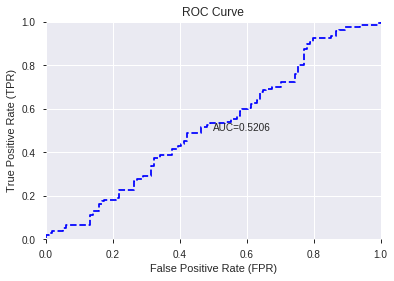

This function is available for GLM models only


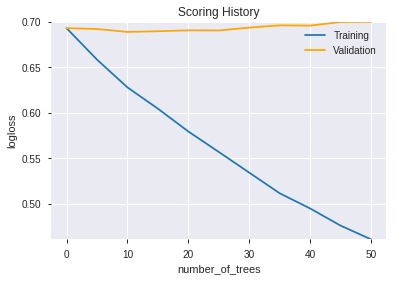

--2019-09-03 03:27:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_032649_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_032649_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_984b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BETA_8',
 'MFI_14',
 'ADXR_8',
 'CMO_8',
 'CCI_12',
 'TRANGE',
 'WILLR_14',
 'MFI_20',
 'PLUS_DI_8',
 'ADX_20',
 'BOP',
 'AROONOSC_30',
 'CORREL_8',
 'ADXR_14',
 'WILLR_8',
 'MACDFIX_hist_24',
 'MFI_12',
 'MOM_20',
 'STOCHF_fastk',
 'STOCH_slowd',
 'HT_DCPERIOD',
 'ADXR_12',
 'PLUS_DM_8',
 'STOCHF_fastd',
 'MOM_30',
 'PLUS_DI_30',
 'MOM_8',
 'DX_30',
 'ATR_8',
 'CCI_8',
 'PLUS_DM_12',
 'AD',
 'OBV',
 'ULTOSC',
 'STOCHRSI_fastk',
 'ROCP_8',
 'DX_12',
 'ROCR_30',
 'LINEARREG_ANGLE_8',
 'aroonup_8',
 'DX_8',
 'MINUS_DI_8',
 'MINUS_DI_30',
 'WILLR_24',
 'ATR_24',
 'STOCHRSI_fastd',
 'RSI_14',
 'MINUS_DI_12',
 'ROC_20',
 'MOM_12',
 'CCI_24',
 'PLUS_DM_24',
 'ADX_12',
 'APO',
 'MACDFIX_signal_12',
 'MOM_24',
 'NATR_20',
 'MFI_8',
 'MACDFIX_signal_20',
 'BBANDS_lowerband_12_7_5',
 'aroondown_30',
 'ROC_14',
 'BBANDS_lowerband_30_0_3',
 'AROONOSC_24',
 'ATR_14',
 'CCI_30',
 'MACD_hist',
 'MINUS_DI_20',
 'ROC_12',
 'MINUS_DM_14',
 'aroonup_24',
 'MACDEXT',
 'CMO_24',
 'MACDFIX_12',
 'aroondow

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.590
GLM             0.554
XGBoost         0.598
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.554    0.582
DLF          0.558  0.546    0.570
Fwe          0.570  0.554    0.582
RFE          0.590  0.546    0.598
XGBF         0.574  0.546    0.570





F1


DeepLearning    0.724
GLM             0.706
XGBoost         0.718
dtype: float64

DeepLearning    GLM  XGBoost
All          0.707  0.706    0.710
DLF          0.710  0.706    0.706
Fwe          0.709  0.706    0.710
RFE          0.724  0.706    0.718
XGBF         0.713  0.706    0.706





auc


DeepLearning    0.538
GLM             0.438
XGBoost         0.521
dtype: float64

DeepLearning    GLM  XGBoost
All          0.516  0.438    0.520
DLF          0.479  0.403    0.506
Fwe          0.524  0.438    0.520
RFE          0.538  0.423    0.521
XGBF         0.503  0.403    0.506





logloss


DeepLearning    1.365
GLM             0.701
XGBoost         0.711
dtype: float64

DeepLearning    GLM  XGBoost
All          0.750  0.696    0.697
DLF          1.003  0.693    0.711
Fwe          1.085  0.696    0.697
RFE          0.859  0.701    0.704
XGBF         1.365  0.693    0.711





mean_per_class_error


DeepLearning    0.476
GLM             0.495
XGBoost         0.460
dtype: float64

DeepLearning    GLM  XGBoost
All          0.451  0.484    0.438
DLF          0.476  0.495    0.460
Fwe          0.442  0.484    0.438
RFE          0.440  0.493    0.436
XGBF         0.452  0.495    0.460





rmse


DeepLearning    0.596
GLM             0.504
XGBoost         0.508
dtype: float64

DeepLearning    GLM  XGBoost
All          0.522  0.501    0.502
DLF          0.572  0.500    0.508
Fwe          0.577  0.501    0.502
RFE          0.563  0.504    0.505
XGBF         0.596  0.500    0.508





mse


DeepLearning    0.356
GLM             0.254
XGBoost         0.258
dtype: float64

DeepLearning    GLM  XGBoost
All          0.272  0.251    0.252
DLF          0.327  0.250    0.258
Fwe          0.333  0.251    0.252
RFE          0.318  0.254    0.255
XGBF         0.356  0.250    0.258

{'F1':       DeepLearning    GLM  XGBoost
 All          0.707    NaN      NaN
 DLF          0.710    NaN      NaN
 DLF            NaN  0.706      NaN
 DLF            NaN    NaN    0.706
 All            NaN  0.706      NaN
 All            NaN    NaN    0.710
 XGBF         0.713    NaN      NaN
 XGBF           NaN  0.706      NaN
 XGBF           NaN    NaN    0.706
 Fwe          0.709    NaN      NaN
 Fwe            NaN  0.706      NaN
 Fwe            NaN    NaN    0.710
 RFE          0.724    NaN      NaN
 RFE            NaN  0.706      NaN
 RFE            NaN    NaN    0.718,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.558    NaN      NaN
 DLF            NaN  0.546      NaN
 DLF            NaN    NaN    0.570
 All            NaN  0.554      NaN
 All            NaN    NaN    0.582
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.546      NaN
 XGBF           NaN    NaN    0.570
 Fwe          0.570    NaN      NaN
 Fwe     